In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import os

In [3]:
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print('✓ Librerías básicas importadas')

# Librerías de Machine Learning
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print('✓ Librerías de ML importadas')

# Librerías específicas para series de tiempo
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf

print('✓ Librerías de series temporales importadas')

✓ Librerías básicas importadas
✓ Librerías de ML importadas
✓ Librerías de series temporales importadas


Carga de Datos

In [4]:
print('='*60)
print('CARGA DE DATOS')
print('='*60)

train_path = "dataset_consumo_electrico/train.csv"
test_path = "dataset_consumo_electrico/test.csv"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print(f'✓ Train: {train.shape[0]:,} filas × {train.shape[1]} columnas')
print(f'✓ Test:  {test.shape[0]:,} filas × {test.shape[1]} columnas')


CARGA DE DATOS
✓ Train: 244,391 filas × 3 columnas
✓ Test:  61,313 filas × 3 columnas


Preparación de data

In [5]:
# Parsear fechas y ordenar
train['fecha'] = pd.to_datetime(train['fecha'], errors='coerce')
test['fecha'] = pd.to_datetime(test['fecha'], errors='coerce')

train = train.sort_values('fecha').reset_index(drop=True)
test = test.sort_values('fecha').reset_index(drop=True)

print(f'\nRango temporal train: {train["fecha"].min()} a {train["fecha"].max()}')
print(f'Rango temporal test:  {test["fecha"].min()} a {test["fecha"].max()}')

# Calcular duración
duracion_train = (train['fecha'].max() - train['fecha'].min()).days
duracion_test = (test['fecha'].max() - test['fecha'].min()).days
print(f'\nDuración train: {duracion_train} días')
print(f'Duración test:  {duracion_test} días')


Rango temporal train: 2018-01-01 00:00:00 a 2021-12-31 23:00:00
Rango temporal test:  2022-01-01 00:00:00 a 2022-12-31 23:00:00

Duración train: 1460 días
Duración test:  364 días


In [6]:
print('\n' + '='*60)
print('VISTA PREVIA DE LOS DATOS')
print('='*60)
print('\nTrain:')
display(train.head(10))

print('\nTest:')
display(test.head(10))


VISTA PREVIA DE LOS DATOS

Train:


subestacion               fecha     consumo
0     AJAHUEL 2018-01-01 00:00:00  137.330840
1     FLORIDA 2018-01-01 00:00:00    0.219616
2       CHENA 2018-01-01 00:00:00  164.664089
3      CNAVIA 2018-01-01 00:00:00  323.805217
4     ELSALTO 2018-01-01 00:00:00  212.495636
5        BUIN 2018-01-01 00:00:00   -1.469724
6     LOSALME 2018-01-01 00:00:00  218.675048
7     FLORIDA 2018-01-01 01:00:00    0.102980
8       CHENA 2018-01-01 01:00:00  151.831422
9     ELSALTO 2018-01-01 01:00:00  200.802108


Test:


subestacion               fecha     consumo
0     AJAHUEL 2022-01-01 00:00:00  102.093131
1     LOSALME 2022-01-01 00:00:00  156.682860
2        BUIN 2022-01-01 00:00:00   -1.489727
3     FLORIDA 2022-01-01 00:00:00   -8.948805
4      CNAVIA 2022-01-01 00:00:00  338.675033
5     ELSALTO 2022-01-01 00:00:00  359.832168
6       CHENA 2022-01-01 00:00:00  171.734369
7      CNAVIA 2022-01-01 01:00:00  314.566837
8     LOSALME 2022-01-01 01:00:00  143.469506
9     AJAHUEL 2022-01-01 01:00:00   82.379086

Información del dataset

In [7]:
print('\n' + '='*60)
print('INFORMACIÓN DEL DATASET')
print('='*60)
print(train.info())

print('\nNulos en train:')
print(train.isnull().sum())

print('\nEstadísticas descriptivas:')
display(train.describe())


INFORMACIÓN DEL DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244391 entries, 0 to 244390
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   subestacion  244391 non-null  object        
 1   fecha        244391 non-null  datetime64[ns]
 2   consumo      244391 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 5.6+ MB
None

Nulos en train:
subestacion    0
fecha          0
consumo        0
dtype: int64

Estadísticas descriptivas:


fecha        consumo
count                         244391  244391.000000
mean   2019-12-30 23:32:51.219889408     179.548024
min              2018-01-01 00:00:00    -199.000000
25%              2018-12-31 06:00:00       0.181926
50%              2019-12-29 23:00:00     172.099977
75%              2020-12-27 18:00:00     262.179646
max              2021-12-31 23:00:00     752.006309
std                              NaN     156.018729

Visualizacion de Series Temporales - DATA COMPLETA

VISUALIZACIÓN DE SERIES TEMPORALES

Puntos temporales en train: 34,913
Puntos temporales en test:  8,759
✓ Gráfico guardado: 01_serie_temporal_completa.png


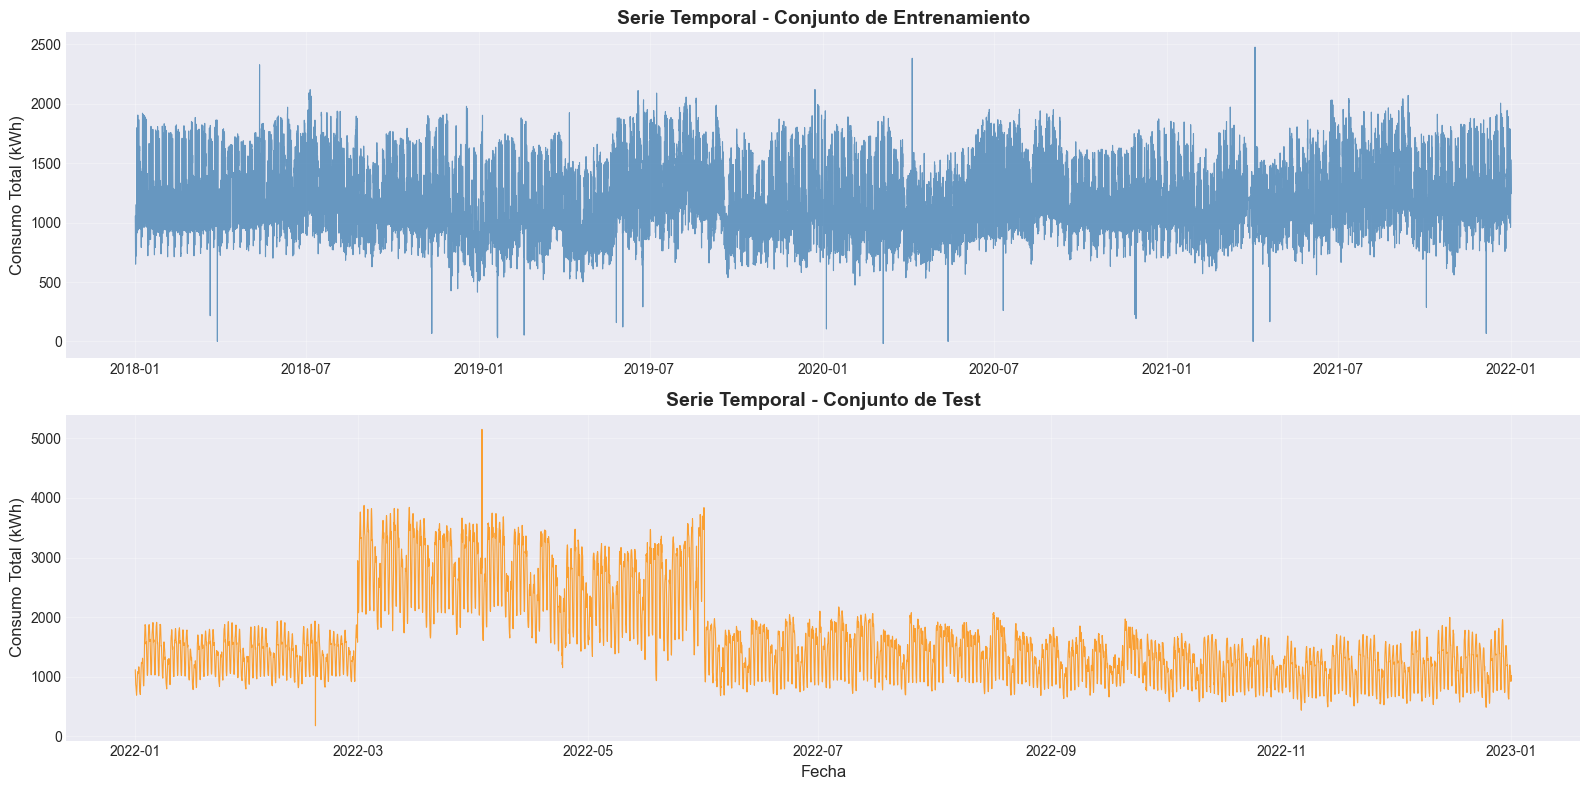

✓ Gráfico guardado: 02_patron_diario_detalle.png


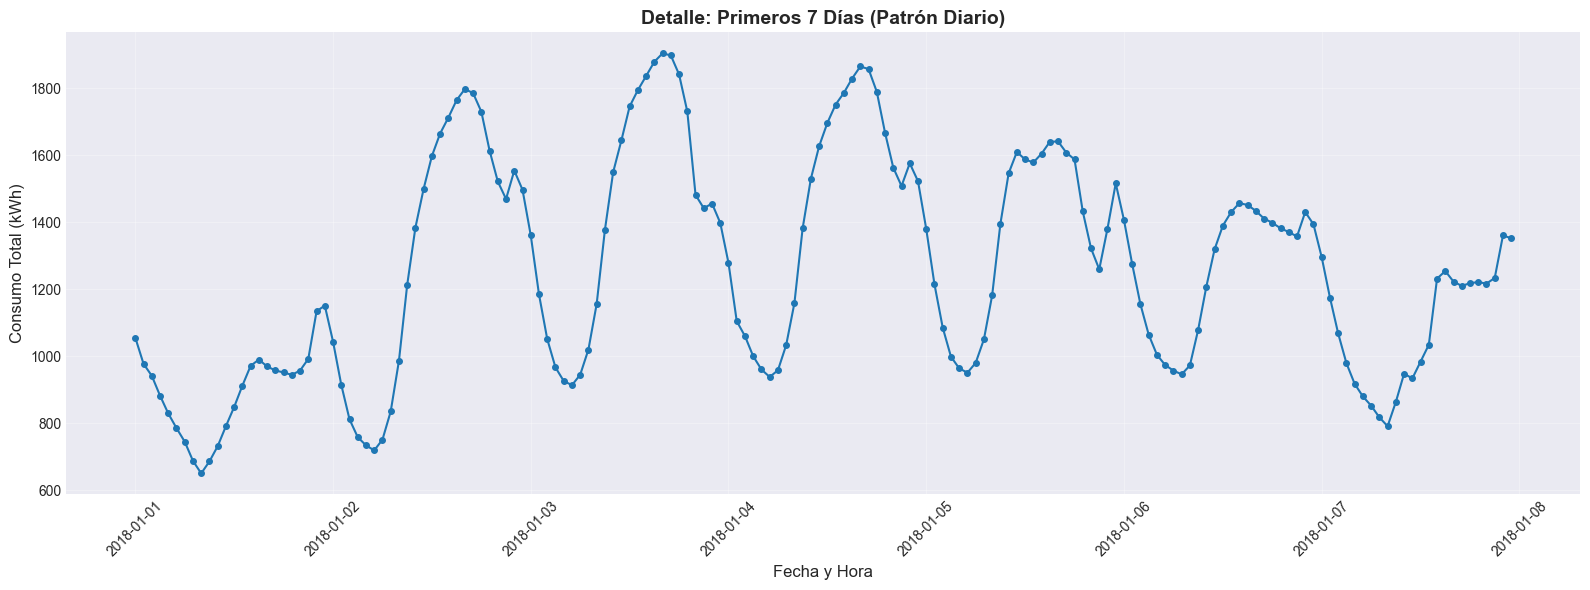

In [9]:
print('='*60)
print('VISUALIZACIÓN DE SERIES TEMPORALES')
print('='*60)

# Crear serie temporal agregada (total por hora)
ts_train = train.groupby('fecha')['consumo'].sum().sort_index()
ts_test = test.groupby('fecha')['consumo'].sum().sort_index()

print(f'\nPuntos temporales en train: {len(ts_train):,}')
print(f'Puntos temporales en test:  {len(ts_test):,}')

# Gráfico de series completas
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# Train
axes[0].plot(ts_train.index, ts_train.values, linewidth=0.8, alpha=0.8, color='steelblue')
axes[0].set_ylabel('Consumo Total (kWh)', fontsize=12)
axes[0].set_title('Serie Temporal - Conjunto de Entrenamiento', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Test
axes[1].plot(ts_test.index, ts_test.values, linewidth=0.8, alpha=0.8, color='darkorange')
axes[1].set_xlabel('Fecha', fontsize=12)
axes[1].set_ylabel('Consumo Total (kWh)', fontsize=12)
axes[1].set_title('Serie Temporal - Conjunto de Test', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('01_serie_temporal_completa.png', dpi=200, bbox_inches='tight')
print('✓ Gráfico guardado: 01_serie_temporal_completa.png')
plt.show()

# Zoom en primeros días para ver patrón diario
fig, ax = plt.subplots(figsize=(16, 6))

# Mostrar solo primeros 7 días
dias_mostrar = 7
mask = ts_train.index < (ts_train.index.min() + pd.Timedelta(days=dias_mostrar))
ts_zoom = ts_train[mask]

ax.plot(ts_zoom.index, ts_zoom.values, linewidth=1.5, marker='o', markersize=4)
ax.set_xlabel('Fecha y Hora', fontsize=12)
ax.set_ylabel('Consumo Total (kWh)', fontsize=12)
ax.set_title(f'Detalle: Primeros {dias_mostrar} Días (Patrón Diario)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('02_patron_diario_detalle.png', dpi=200, bbox_inches='tight')
print('✓ Gráfico guardado: 02_patron_diario_detalle.png')
plt.show()

Descomposicion temporal

DESCOMPOSICIÓN DE SERIES TEMPORALES
✓ Gráfico guardado: 03_descomposicion_temporal.png


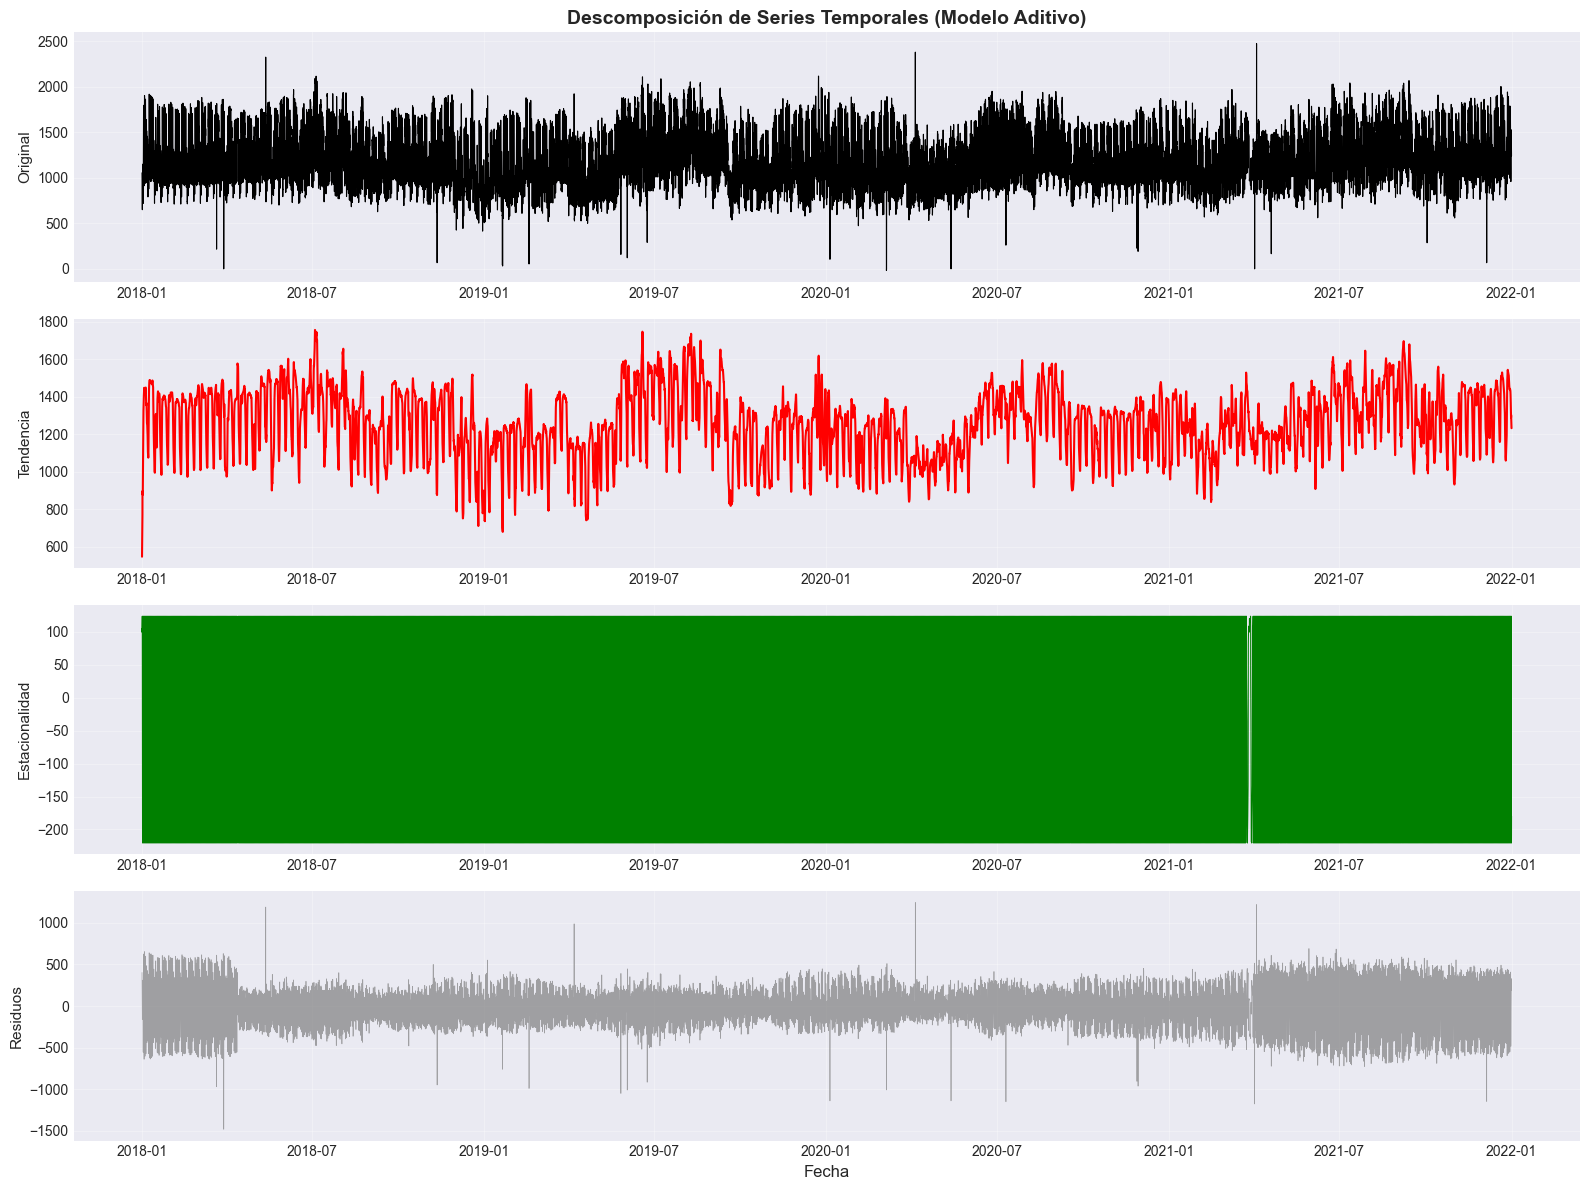


📊 Estadísticas de Componentes:
  Tendencia - Rango: [547.71, 1756.24]
  Tendencia - Variación (std): 178.68
  Estacionalidad - Amplitud: 344.21
  Residuos - Std: 228.33

  🔍 Fuerza de estacionalidad: 0.2365
     → Estacionalidad DÉBIL


In [10]:
print('='*60)
print('DESCOMPOSICIÓN DE SERIES TEMPORALES')
print('='*60)

try:
    periodo = 24  # Cambia esto según tus datos (24=horario, 7=diario, etc.)

    decomposition = seasonal_decompose(
        ts_train,
        model='additive',  # o 'multiplicative' si varianza crece con nivel
        period=periodo,
        extrapolate_trend='freq'
    )

    # Gráfico de descomposición
    fig, axes = plt.subplots(4, 1, figsize=(16, 12))

    # Serie original
    axes[0].plot(decomposition.observed, linewidth=0.8, color='black')
    axes[0].set_ylabel('Original', fontsize=11)
    axes[0].set_title('Descomposición de Series Temporales (Modelo Aditivo)',
                     fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)

    # Tendencia
    axes[1].plot(decomposition.trend, linewidth=1.5, color='red')
    axes[1].set_ylabel('Tendencia', fontsize=11)
    axes[1].grid(True, alpha=0.3)

    # Estacionalidad
    axes[2].plot(decomposition.seasonal, linewidth=0.8, color='green')
    axes[2].set_ylabel('Estacionalidad', fontsize=11)
    axes[2].grid(True, alpha=0.3)

    # Residuos
    axes[3].plot(decomposition.resid, linewidth=0.5, color='gray', alpha=0.7)
    axes[3].set_ylabel('Residuos', fontsize=11)
    axes[3].set_xlabel('Fecha', fontsize=12)
    axes[3].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('03_descomposicion_temporal.png', dpi=200, bbox_inches='tight')
    print('✓ Gráfico guardado: 03_descomposicion_temporal.png')
    plt.show()

    # Estadísticas de componentes
    print('\n📊 Estadísticas de Componentes:')
    print(f'  Tendencia - Rango: [{decomposition.trend.min():.2f}, {decomposition.trend.max():.2f}]')
    print(f'  Tendencia - Variación (std): {decomposition.trend.std():.2f}')
    print(f'  Estacionalidad - Amplitud: {decomposition.seasonal.max() - decomposition.seasonal.min():.2f}')
    print(f'  Residuos - Std: {decomposition.resid.std():.2f}')

    # Fuerza de estacionalidad (1 = perfecta, 0 = ninguna)
    var_resid = decomposition.resid.var()
    var_seasonal_resid = (decomposition.seasonal + decomposition.resid).var()
    seasonal_strength = max(0, 1 - (var_resid / var_seasonal_resid))

    print(f'\n  🔍 Fuerza de estacionalidad: {seasonal_strength:.4f}')
    if seasonal_strength > 0.6:
        print('     → Estacionalidad FUERTE detectada')
    elif seasonal_strength > 0.3:
        print('     → Estacionalidad MODERADA detectada')
    else:
        print('     → Estacionalidad DÉBIL')

except Exception as e:
    print(f'⚠ Error en descomposición: {e}')
    print('  Sugerencias:')
    print('  - Ajusta el parámetro "periodo" según frecuencia de datos')
    print('  - Verifica que no haya valores faltantes')
    print('  - Asegúrate de tener suficientes observaciones (mínimo 2*periodo)')

Patrones de estacionalidad

PATRONES DE ESTACIONALIDAD (Solo Train)
✓ Features temporales creados
✓ Gráfico guardado: 04_patrones_estacionalidad.png


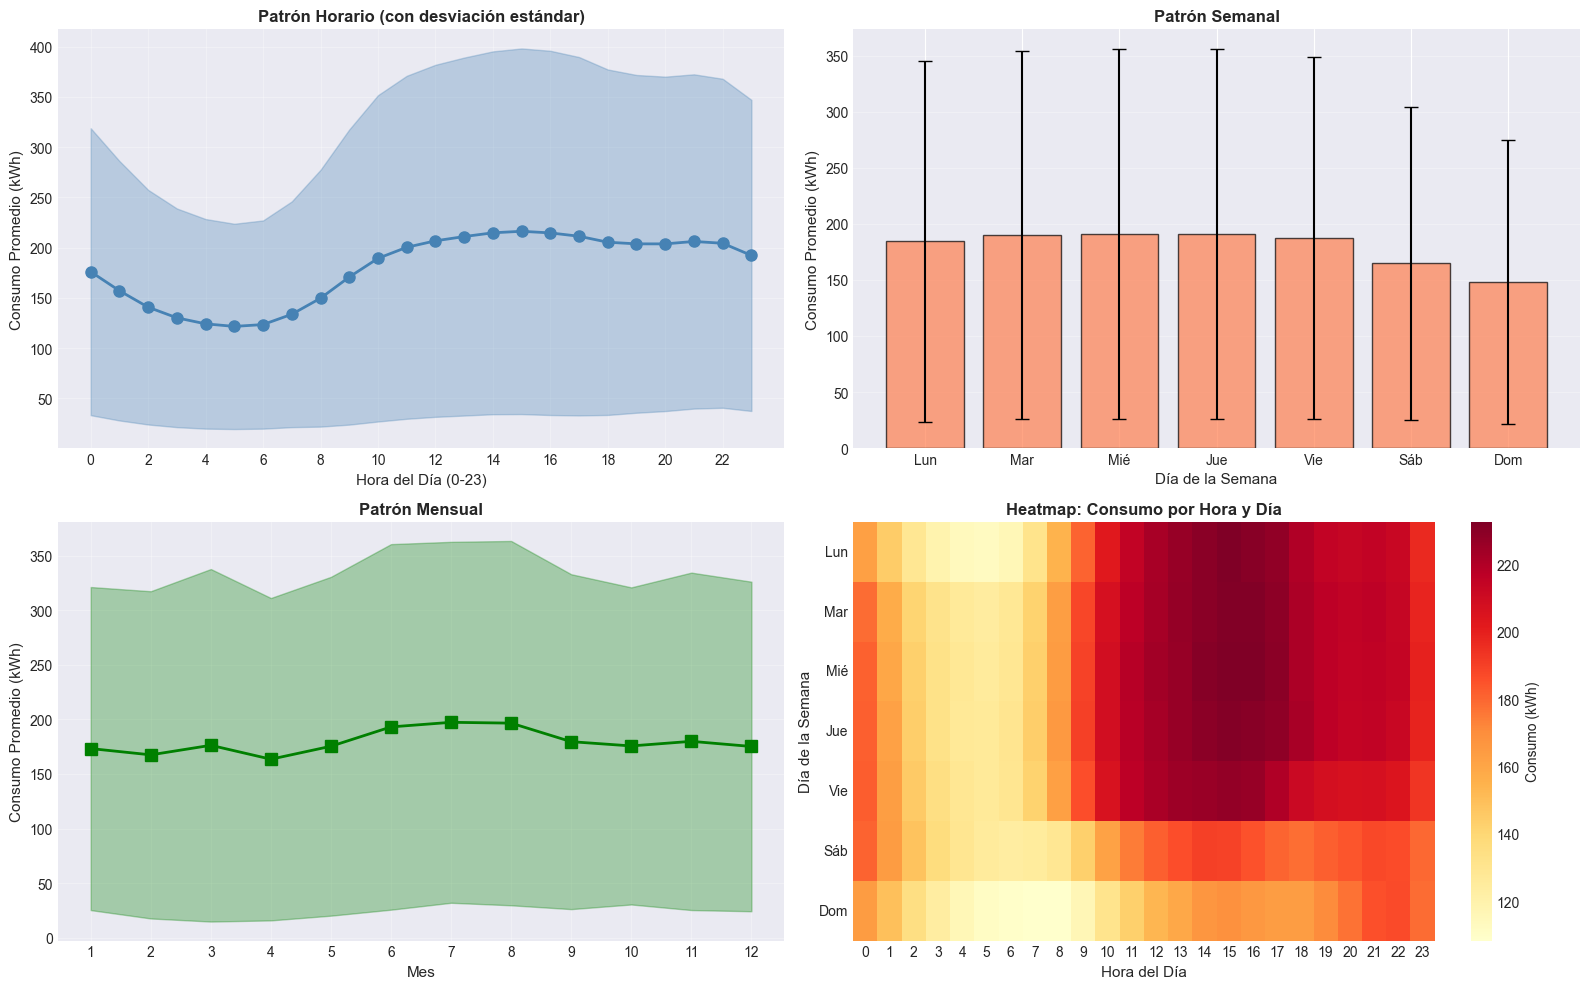


📊 Variabilidad por Dimensión Temporal:
  Por Hora:    CV = 83.37%
  Por Día:     CV = 86.12%
  Por Mes:     CV = 86.64%

  CV = Coeficiente de Variación (mayor = más variabilidad)


In [11]:
print('='*60)
print('PATRONES DE ESTACIONALIDAD (Solo Train)')
print('='*60)

# Agregar features temporales
train['hour'] = train['fecha'].dt.hour
train['weekday'] = train['fecha'].dt.weekday
train['month'] = train['fecha'].dt.month
train['day'] = train['fecha'].dt.day

print('✓ Features temporales creados')

# %%
# Gráfico de patrones múltiples
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Consumo promedio por HORA del día
consumo_hora = train.groupby('hour')['consumo'].agg(['mean', 'std']).reset_index()
axes[0, 0].plot(consumo_hora['hour'], consumo_hora['mean'],
                marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0, 0].fill_between(consumo_hora['hour'],
                        consumo_hora['mean'] - consumo_hora['std'],
                        consumo_hora['mean'] + consumo_hora['std'],
                        alpha=0.3, color='steelblue')
axes[0, 0].set_xlabel('Hora del Día (0-23)', fontsize=11)
axes[0, 0].set_ylabel('Consumo Promedio (kWh)', fontsize=11)
axes[0, 0].set_title('Patrón Horario (con desviación estándar)', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(range(0, 24, 2))

# 2. Consumo promedio por DÍA de la semana
dias_semana = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']
consumo_dia = train.groupby('weekday')['consumo'].agg(['mean', 'std']).reset_index()
axes[0, 1].bar(consumo_dia['weekday'], consumo_dia['mean'],
               color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].errorbar(consumo_dia['weekday'], consumo_dia['mean'],
                    yerr=consumo_dia['std'], fmt='none', color='black', capsize=5)
axes[0, 1].set_xlabel('Día de la Semana', fontsize=11)
axes[0, 1].set_ylabel('Consumo Promedio (kWh)', fontsize=11)
axes[0, 1].set_title('Patrón Semanal', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(dias_semana)
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Consumo promedio por MES
consumo_mes = train.groupby('month')['consumo'].agg(['mean', 'std']).reset_index()
axes[1, 0].plot(consumo_mes['month'], consumo_mes['mean'],
                marker='s', linewidth=2, markersize=8, color='green')
axes[1, 0].fill_between(consumo_mes['month'],
                        consumo_mes['mean'] - consumo_mes['std'],
                        consumo_mes['mean'] + consumo_mes['std'],
                        alpha=0.3, color='green')
axes[1, 0].set_xlabel('Mes', fontsize=11)
axes[1, 0].set_ylabel('Consumo Promedio (kWh)', fontsize=11)
axes[1, 0].set_title('Patrón Mensual', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(range(1, 13))

# 4. Heatmap: Hora vs Día de semana
pivot_heatmap = train.groupby(['weekday', 'hour'])['consumo'].mean().reset_index()
pivot_table = pivot_heatmap.pivot(index='weekday', columns='hour', values='consumo')
sns.heatmap(pivot_table, cmap='YlOrRd', ax=axes[1, 1], cbar_kws={'label': 'Consumo (kWh)'})
axes[1, 1].set_xlabel('Hora del Día', fontsize=11)
axes[1, 1].set_ylabel('Día de la Semana', fontsize=11)
axes[1, 1].set_title('Heatmap: Consumo por Hora y Día', fontsize=12, fontweight='bold')
axes[1, 1].set_yticklabels(dias_semana, rotation=0)

plt.tight_layout()
plt.savefig('04_patrones_estacionalidad.png', dpi=200, bbox_inches='tight')
print('✓ Gráfico guardado: 04_patrones_estacionalidad.png')
plt.show()

# %%
# Estadísticas de variabilidad
print('\n📊 Variabilidad por Dimensión Temporal:')
print(f'  Por Hora:    CV = {(consumo_hora["std"].mean() / consumo_hora["mean"].mean()):.2%}')
print(f'  Por Día:     CV = {(consumo_dia["std"].mean() / consumo_dia["mean"].mean()):.2%}')
print(f'  Por Mes:     CV = {(consumo_mes["std"].mean() / consumo_mes["mean"].mean()):.2%}')
print('\n  CV = Coeficiente de Variación (mayor = más variabilidad)')

ANÁLISIS DE AUTOCORRELACIÓN

🔍 Test de Estacionariedad (ADF Test):
------------------------------------------------------------
  ADF Statistic: -18.6757
  p-value: 0.0000
  Valores críticos:
    1%: -3.4305
    5%: -2.8616
    10%: -2.5668

  ✓ Serie ESTACIONARIA (p < 0.05)
    → No necesita diferenciación

✓ Gráfico guardado: 05_autocorrelacion_acf_pacf.png


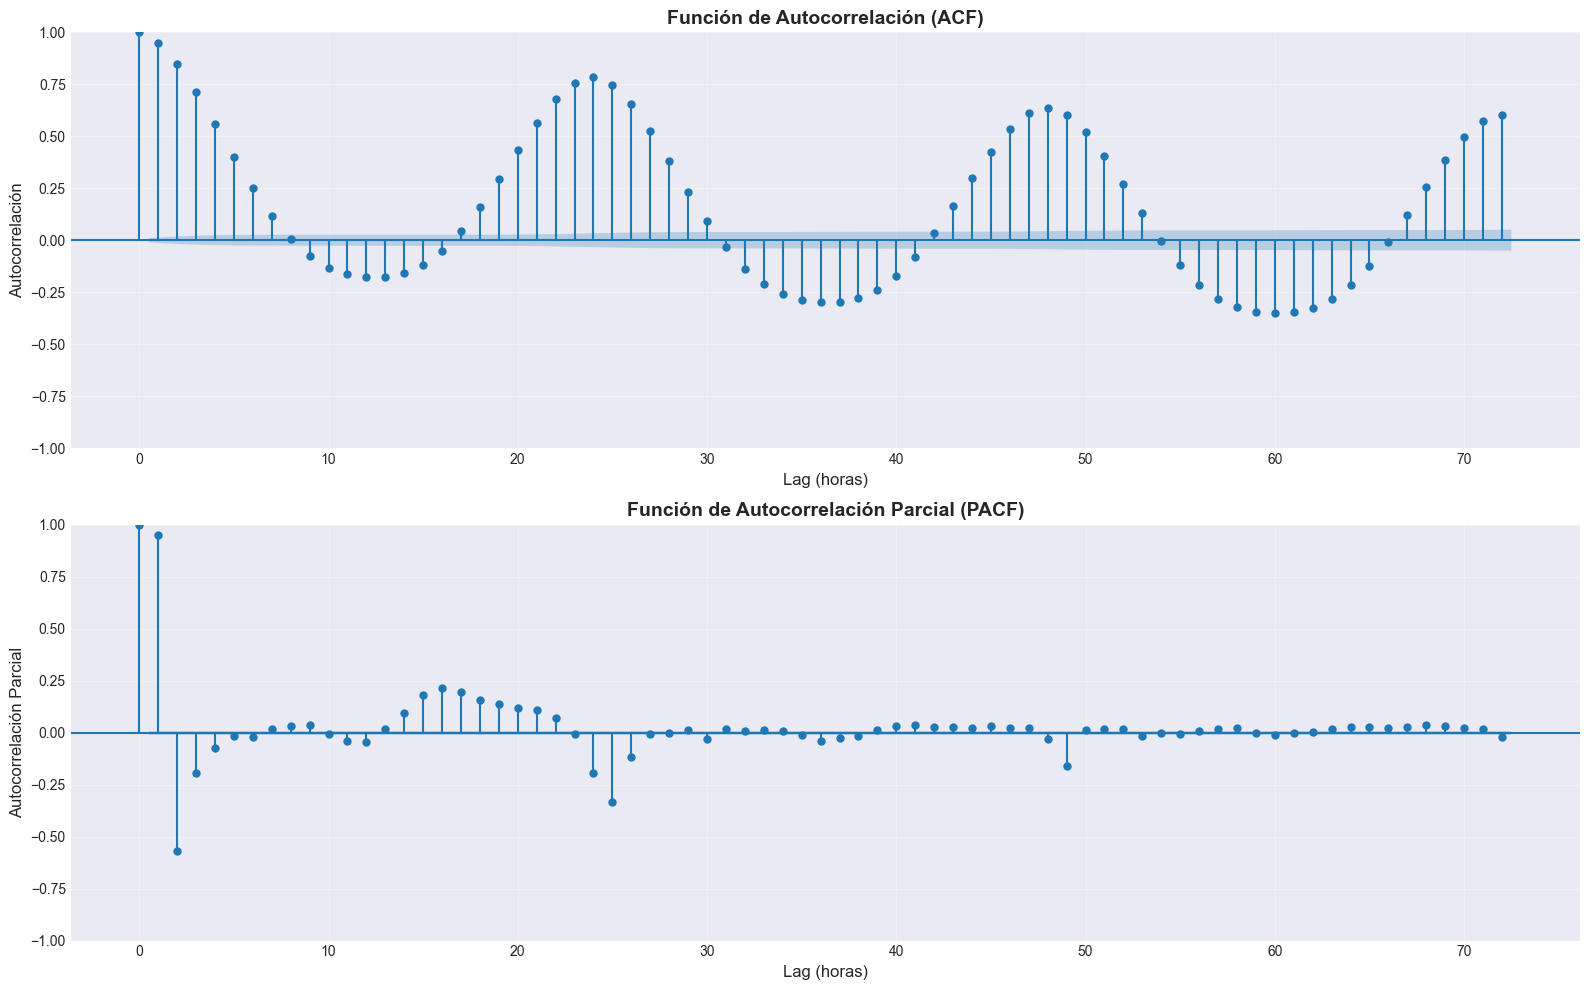


📊 Interpretación de ACF:
------------------------------------------------------------
  Lags con autocorrelación significativa (primeros 20):
    Lag 0: 1.000
    Lag 1: 0.951
    Lag 2: 0.850
    Lag 3: 0.714
    Lag 4: 0.560
    Lag 5: 0.402
    Lag 6: 0.250
    Lag 7: 0.115
    Lag 9: -0.078
    Lag 10: -0.132
    Lag 11: -0.164
    Lag 12: -0.178
    Lag 13: -0.177
    Lag 14: -0.160
    Lag 15: -0.120
    Lag 16: -0.053
    Lag 17: 0.042
    Lag 18: 0.160
    Lag 19: 0.294
    Lag 20: 0.432

  ✓ Ciclo DIARIO detectado (lag 24)

AUTOCORRELACIÓN POR SUBESTACIÓN
✓ Gráfico guardado: 06_autocorrelacion_por_subestacion.png


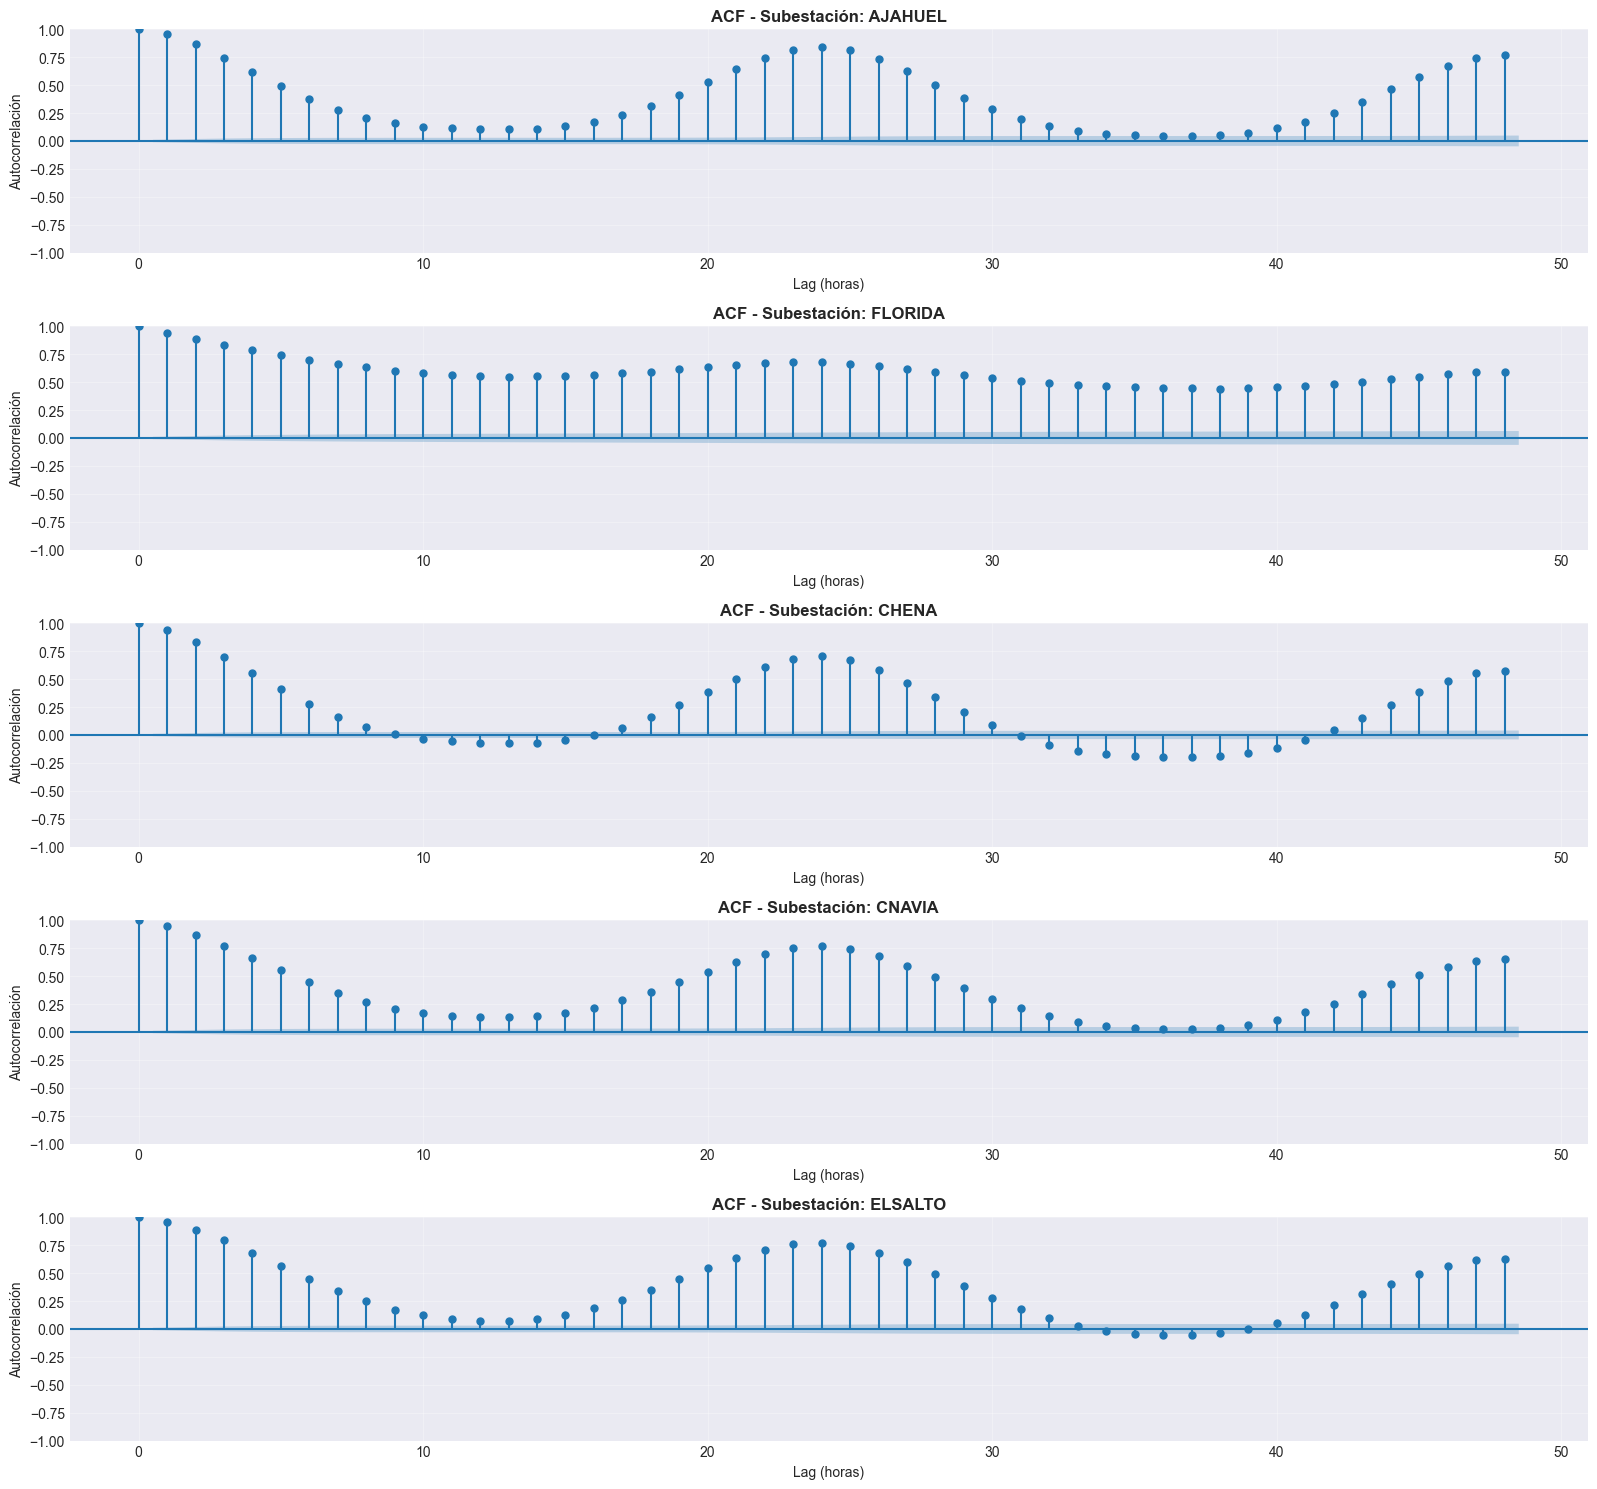


MATRIZ DE CORRELACIÓN DE LAGS
✓ Gráfico guardado: 07_correlacion_lags.png


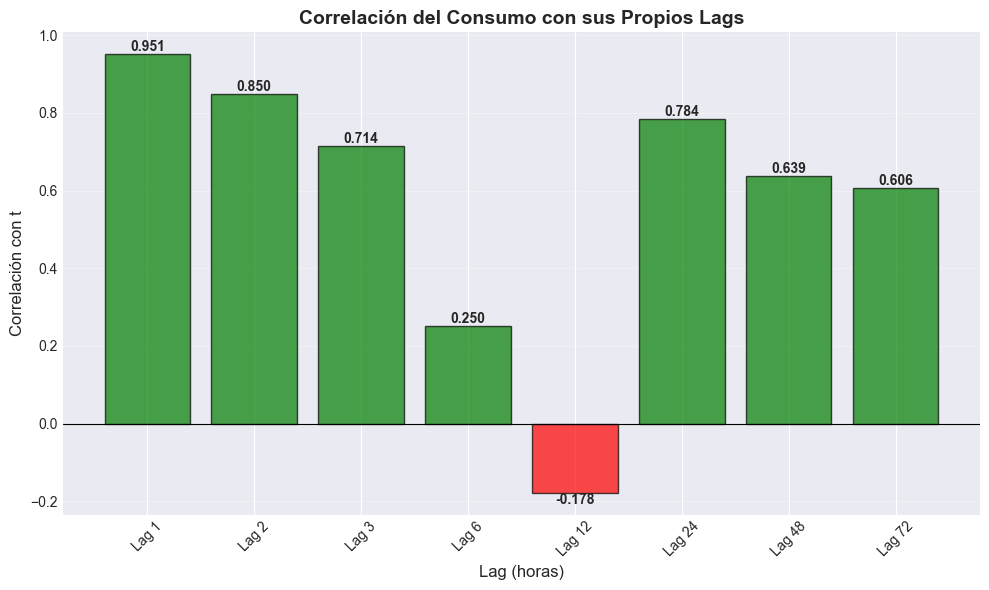


📊 Correlaciones por Lag:
  Lag   1h: +0.9509
  Lag   2h: +0.8498
  Lag   3h: +0.7141
  Lag   6h: +0.2503
  Lag  12h: -0.1781
  Lag  24h: +0.7841
  Lag  48h: +0.6387
  Lag  72h: +0.6058

📋 RESUMEN DE AUTOCORRELACIÓN

1. Estacionariedad:
   ✓ Serie estacionaria - lista para modelar

2. Autocorrelación detectada:
   ✓ Fuerte dependencia temporal (70 lags significativos)

3. Patrones periódicos:
   ✓ Ciclo diario (24h) confirmado

4. Recomendaciones:
   → Lag 1 muy fuerte: usar modelos AR o ARIMA
   → Estacionalidad diaria: incluir lag_24 como feature


/var/folders/3w/gct2rxtd1tn13mk3vwd7f9xh0000gn/T/ipykernel_51601/2813727517.py:169: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if correlaciones[1] > 0.8:
/var/folders/3w/gct2rxtd1tn13mk3vwd7f9xh0000gn/T/ipykernel_51601/2813727517.py:171: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if 24 in lags_analizar and correlaciones[lags_analizar.index(24)] > 0.5:


In [12]:
print('='*60)
print('ANÁLISIS DE AUTOCORRELACIÓN')
print('='*60)

# Test de Estacionariedad (Augmented Dickey-Fuller)
print('\n🔍 Test de Estacionariedad (ADF Test):')
print('-' * 60)

adf_result = adfuller(ts_train.dropna())

print(f'  ADF Statistic: {adf_result[0]:.4f}')
print(f'  p-value: {adf_result[1]:.4f}')
print(f'  Valores críticos:')
for key, value in adf_result[4].items():
    print(f'    {key}: {value:.4f}')

if adf_result[1] < 0.05:
    print('\n  ✓ Serie ESTACIONARIA (p < 0.05)')
    print('    → No necesita diferenciación')
else:
    print('\n  ✗ Serie NO ESTACIONARIA (p >= 0.05)')
    print('    → Requiere diferenciación o transformación')

# %%
# Gráficos ACF y PACF
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# ACF (Autocorrelation Function)
plot_acf(ts_train.dropna(), lags=72, ax=axes[0], alpha=0.05)
axes[0].set_xlabel('Lag (horas)', fontsize=12)
axes[0].set_ylabel('Autocorrelación', fontsize=12)
axes[0].set_title('Función de Autocorrelación (ACF)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# PACF (Partial Autocorrelation Function)
plot_pacf(ts_train.dropna(), lags=72, ax=axes[1], alpha=0.05, method='ywm')
axes[1].set_xlabel('Lag (horas)', fontsize=12)
axes[1].set_ylabel('Autocorrelación Parcial', fontsize=12)
axes[1].set_title('Función de Autocorrelación Parcial (PACF)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('05_autocorrelacion_acf_pacf.png', dpi=200, bbox_inches='tight')
print('\n✓ Gráfico guardado: 05_autocorrelacion_acf_pacf.png')
plt.show()

# %%
# Interpretación de ACF
print('\n📊 Interpretación de ACF:')
print('-' * 60)

acf_values = acf(ts_train.dropna(), nlags=72)

# Encontrar lags significativos
significancia = 1.96 / np.sqrt(len(ts_train))  # Banda de confianza 95%
lags_significativos = np.where(np.abs(acf_values) > significancia)[0]

print(f'  Lags con autocorrelación significativa (primeros 20):')
lags_mostrar = lags_significativos[lags_significativos <= 72][:20]
for lag in lags_mostrar:
    print(f'    Lag {lag}: {acf_values[lag]:.3f}')

# Detectar periodicidad
if 24 in lags_significativos:
    print(f'\n  ✓ Ciclo DIARIO detectado (lag 24)')
if 168 in lags_significativos:  # 24*7 = 168 horas
    print(f'  ✓ Ciclo SEMANAL detectado (lag 168)')

# %%
# Autocorrelación por subestación (top 5)
print('\n' + '='*60)
print('AUTOCORRELACIÓN POR SUBESTACIÓN')
print('='*60)

top_subestaciones = train['subestacion'].value_counts().head(5).index

fig, axes = plt.subplots(len(top_subestaciones), 1, figsize=(16, 3*len(top_subestaciones)))

if len(top_subestaciones) == 1:
    axes = [axes]

for idx, subestacion in enumerate(top_subestaciones):
    # Serie temporal de esta subestación
    ts_sub = train[train['subestacion'] == subestacion].set_index('fecha')['consumo'].sort_index()

    if len(ts_sub) > 50:  # Necesitamos suficientes datos
        plot_acf(ts_sub.dropna(), lags=min(48, len(ts_sub)//2), ax=axes[idx], alpha=0.05)
        axes[idx].set_title(f'ACF - Subestación: {subestacion}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Lag (horas)', fontsize=10)
        axes[idx].set_ylabel('Autocorrelación', fontsize=10)
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('06_autocorrelacion_por_subestacion.png', dpi=200, bbox_inches='tight')
print('✓ Gráfico guardado: 06_autocorrelacion_por_subestacion.png')
plt.show()

# %%
# Matriz de correlación entre diferentes lags
print('\n' + '='*60)
print('MATRIZ DE CORRELACIÓN DE LAGS')
print('='*60)

# Crear dataframe con diferentes lags
lags_analizar = [1, 2, 3, 6, 12, 24, 48, 72]
df_lags = pd.DataFrame({'consumo': ts_train.values})

for lag in lags_analizar:
    df_lags[f'lag_{lag}'] = df_lags['consumo'].shift(lag)

# Calcular correlaciones
correlaciones = df_lags.corr()['consumo'].drop('consumo')

# Visualizar
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(range(len(correlaciones)), correlaciones.values,
              color=['red' if x < 0 else 'green' for x in correlaciones.values],
              alpha=0.7, edgecolor='black')

ax.set_xlabel('Lag (horas)', fontsize=12)
ax.set_ylabel('Correlación con t', fontsize=12)
ax.set_title('Correlación del Consumo con sus Propios Lags', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(correlaciones)))
ax.set_xticklabels([f'Lag {lag}' for lag in lags_analizar], rotation=45)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='y', alpha=0.3)

# Añadir valores sobre las barras
for i, (bar, val) in enumerate(zip(bars, correlaciones.values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.3f}', ha='center', va='bottom' if val > 0 else 'top',
            fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('07_correlacion_lags.png', dpi=200, bbox_inches='tight')
print('✓ Gráfico guardado: 07_correlacion_lags.png')
plt.show()

print('\n📊 Correlaciones por Lag:')
for lag, corr in zip(lags_analizar, correlaciones.values):
    print(f'  Lag {lag:3d}h: {corr:+.4f}')

# %%
# Resumen de hallazgos
print('\n' + '='*60)
print('📋 RESUMEN DE AUTOCORRELACIÓN')
print('='*60)

print('\n1. Estacionariedad:')
if adf_result[1] < 0.05:
    print('   ✓ Serie estacionaria - lista para modelar')
else:
    print('   ✗ Serie no estacionaria - considerar diferenciación')

print('\n2. Autocorrelación detectada:')
if len(lags_significativos) > 10:
    print(f'   ✓ Fuerte dependencia temporal ({len(lags_significativos)} lags significativos)')
else:
    print(f'   △ Dependencia temporal moderada ({len(lags_significativos)} lags significativos)')

print('\n3. Patrones periódicos:')
if 24 in lags_significativos:
    print('   ✓ Ciclo diario (24h) confirmado')
if any(lag in lags_significativos for lag in range(160, 176)):
    print('   ✓ Ciclo semanal (168h) confirmado')

print('\n4. Recomendaciones:')
if correlaciones[1] > 0.8:
    print('   → Lag 1 muy fuerte: usar modelos AR o ARIMA')
if 24 in lags_analizar and correlaciones[lags_analizar.index(24)] > 0.5:
    print('   → Estacionalidad diaria: incluir lag_24 como feature')
if not (adf_result[1] < 0.05):
    print('   → Aplicar diferenciación: df.diff() antes de modelar')

# SARIMA

PREPARACIÓN PARA MODELO SARIMA
✓ Librerías SARIMA importadas

CREACIÓN DE SERIE TEMPORAL

✓ Serie temporal train: 34,913 puntos
✓ Serie temporal test:  8,759 puntos

Frecuencia detectada: None
⚠ Frecuencia irregular detectada
  Reindexando a frecuencia horaria...
  ✓ Serie regularizada a frecuencia horaria

✓ Gráfico guardado: 13_serie_sarima.png


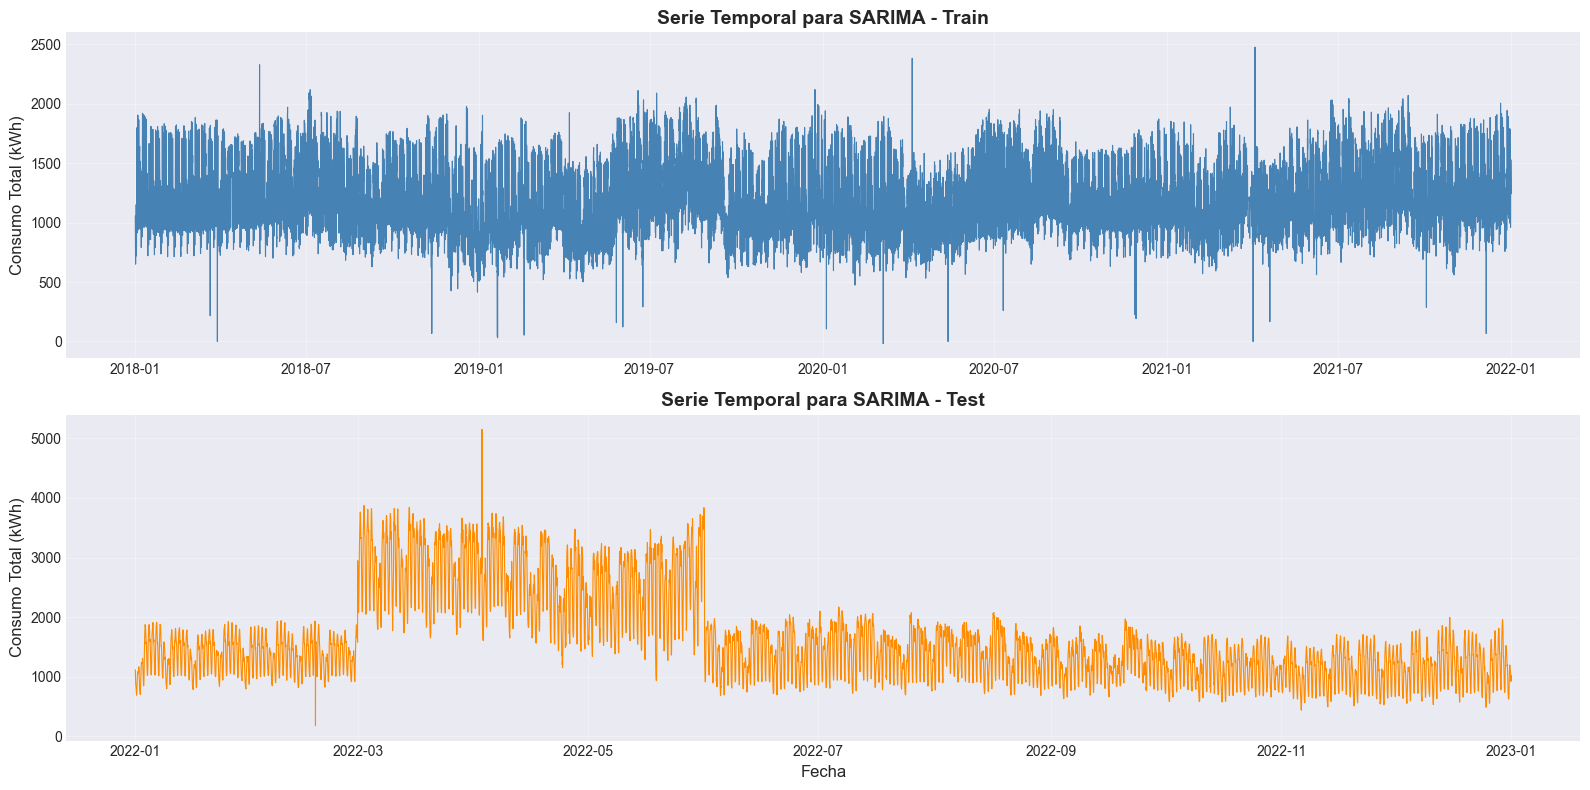


VERIFICACIÓN DE ESTACIONARIEDAD

ADF Statistic: -18.6943
p-value: 0.0000

✓ Serie ESTACIONARIA (p < 0.05)
  → Parámetro d = 0 (no necesita diferenciación)


In [13]:
print('='*60)
print('PREPARACIÓN PARA MODELO SARIMA')
print('='*60)

# Importar librerías adicionales para SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse
from itertools import product
import warnings
warnings.filterwarnings('ignore')

print('✓ Librerías SARIMA importadas')

# %%
# Crear serie temporal agregada para SARIMA
print('\n' + '='*60)
print('CREACIÓN DE SERIE TEMPORAL')
print('='*60)

# Opción 1: Agregada (suma de todas las subestaciones)
ts_train_sarima = train.groupby('fecha')['consumo'].sum().sort_index()
ts_test_sarima = test.groupby('fecha')['consumo'].sum().sort_index()

print(f'\n✓ Serie temporal train: {len(ts_train_sarima):,} puntos')
print(f'✓ Serie temporal test:  {len(ts_test_sarima):,} puntos')

# Verificar continuidad temporal
freq_train = pd.infer_freq(ts_train_sarima.index)
print(f'\nFrecuencia detectada: {freq_train}')

if freq_train is None:
    print('⚠ Frecuencia irregular detectada')
    print('  Reindexando a frecuencia horaria...')

    # Crear índice completo horario
    full_index = pd.date_range(
        start=ts_train_sarima.index.min(),
        end=ts_train_sarima.index.max(),
        freq='H'
    )
    ts_train_sarima = ts_train_sarima.reindex(full_index)

    # Interpolar valores faltantes
    ts_train_sarima = ts_train_sarima.interpolate(method='linear')
    print('  ✓ Serie regularizada a frecuencia horaria')

# %%
# Visualizar serie para SARIMA
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# Train
axes[0].plot(ts_train_sarima.index, ts_train_sarima.values,
             linewidth=0.8, color='steelblue')
axes[0].set_ylabel('Consumo Total (kWh)', fontsize=12)
axes[0].set_title('Serie Temporal para SARIMA - Train', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Test
axes[1].plot(ts_test_sarima.index, ts_test_sarima.values,
             linewidth=0.8, color='darkorange')
axes[1].set_xlabel('Fecha', fontsize=12)
axes[1].set_ylabel('Consumo Total (kWh)', fontsize=12)
axes[1].set_title('Serie Temporal para SARIMA - Test', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('13_serie_sarima.png', dpi=200, bbox_inches='tight')
print('\n✓ Gráfico guardado: 13_serie_sarima.png')
plt.show()

# %%
# Verificar estacionariedad (ya lo hicimos antes, pero confirmamos)
print('\n' + '='*60)
print('VERIFICACIÓN DE ESTACIONARIEDAD')
print('='*60)

adf_result = adfuller(ts_train_sarima.dropna())

print(f'\nADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')

if adf_result[1] < 0.05:
    print('\n✓ Serie ESTACIONARIA (p < 0.05)')
    print('  → Parámetro d = 0 (no necesita diferenciación)')
    d_sugerido = 0
else:
    print('\n✗ Serie NO ESTACIONARIA (p >= 0.05)')
    print('  → Parámetro d = 1 (aplicar diferenciación)')
    d_sugerido = 1

    # Probar con diferenciación
    ts_diff = ts_train_sarima.diff().dropna()
    adf_diff = adfuller(ts_diff)
    print(f'\n  Después de diferenciación:')
    print(f'  ADF Statistic: {adf_diff[0]:.4f}')
    print(f'  p-value: {adf_diff[1]:.4f}')

    if adf_diff[1] < 0.05:
        print('  ✓ Ahora es ESTACIONARIA')

In [17]:
print('\n' + '='*60)
print('BÚSQUEDA DE MEJORES PARÁMETROS SARIMA')
print('='*60)

print('\nParámetros SARIMA(p,d,q)(P,D,Q,s):')
print('  p: orden AR (usa ACF para estimarlo)')
print('  d: orden de diferenciación (d_sugerido =', d_sugerido, ')')
print('  q: orden MA (usa PACF para estimarlo)')
print('  P,D,Q: componentes estacionales')
print('  s: período estacional (24 para datos horarios)')

# %%
# Basándonos en ACF/PACF del análisis anterior
# Definir rangos de búsqueda

print('\n📊 Sugerencias basadas en ACF/PACF:')
print('  p (AR): 1-3 (lag 1 muy fuerte en PACF)')
print('  d: ', d_sugerido)
print('  q (MA): 1-2')
print('  P (SAR): 1-2 (estacionalidad detectada)')
print('  D: 0-1')
print('  Q (SMA): 1')
print('  s: 24 (ciclo diario)')

# %%
# Grid search para SARIMA (esto puede tardar)
print('\n' + '='*60)
print('GRID SEARCH DE PARÁMETROS')
print('='*60)
print('⚠ Esto puede tardar varios minutos...')

# Definir rangos limitados
p_range = [1, 2]
d_range = [d_sugerido]
q_range = [1, 2]

P_range = [1, 2]
D_range = [0, 1]
Q_range = [1]
s = 24 
# Generar todas las combinaciones
pdq_combinations = list(product(p_range, d_range, q_range))
PDQs_combinations = list(product(P_range, D_range, Q_range, [s]))

print(f'\nCombinaciones a probar: {len(pdq_combinations)} × {len(PDQs_combinations)} = {len(pdq_combinations) * len(PDQs_combinations)}')

# %%
# Búsqueda (versión simplificada - solo algunas combinaciones)
print('\nIniciando búsqueda...')

combinaciones_prueba = [
    # (p,d,q), (P,D,Q,s)
    ((1, d_sugerido, 1), (1, 0, 1, 24)),
    ((1, d_sugerido, 1), (1, 1, 1, 24)),
    ((2, d_sugerido, 1), (1, 0, 1, 24)),
    ((1, d_sugerido, 2), (1, 1, 1, 24)),
    ((2, d_sugerido, 2), (2, 0, 1, 24)),
]

resultados_sarima = []

for i, (pdq, PDQs) in enumerate(combinaciones_prueba, 1):
    try:
        print(f'\n[{i}/{len(combinaciones_prueba)}] Probando SARIMA{pdq}×{PDQs}...', end=' ')

        start = time.time()

        # Entrenar modelo
        model = SARIMAX(
            ts_train_sarima,
            order=pdq,
            seasonal_order=PDQs,
            enforce_stationarity=False,
            enforce_invertibility=False
        )

        fitted_model = model.fit(disp=False, maxiter=200)

        # Métricas en train
        aic = fitted_model.aic
        bic = fitted_model.bic

        elapsed = time.time() - start

        resultados_sarima.append({
            'pdq': pdq,
            'PDQs': PDQs,
            'AIC': aic,
            'BIC': bic,
            'tiempo': elapsed
        })

        print(f'✓ AIC: {aic:,.0f} | BIC: {bic:,.0f} | {elapsed:.1f}s')

    except Exception as e:
        print(f'✗ Error: {str(e)[:50]}')
        continue

# %%
# Resultados de la búsqueda
if resultados_sarima:
    print('\n' + '='*60)
    print('RESULTADOS DE BÚSQUEDA')
    print('='*60)

    df_resultados = pd.DataFrame(resultados_sarima).sort_values('AIC')
    print('\nMejores combinaciones por AIC:')
    print(df_resultados.to_string(index=False))

    # Mejor modelo
    best_params = df_resultados.iloc[0]
    best_pdq = best_params['pdq']
    best_PDQs = best_params['PDQs']

    print(f'\n🏆 Mejor configuración:')
    print(f'   SARIMA{best_pdq}×{best_PDQs}')
    print(f'   AIC: {best_params["AIC"]:,.0f}')
    print(f'   BIC: {best_params["BIC"]:,.0f}')

else:
    print('\n⚠ No se pudieron entrenar modelos')
    print('  Usando configuración por defecto...')
    best_pdq = (1, d_sugerido, 1)
    best_PDQs = (1, 1, 1, 24)


BÚSQUEDA DE MEJORES PARÁMETROS SARIMA

Parámetros SARIMA(p,d,q)(P,D,Q,s):
  p: orden AR (usa ACF para estimarlo)
  d: orden de diferenciación (d_sugerido = 0 )
  q: orden MA (usa PACF para estimarlo)
  P,D,Q: componentes estacionales
  s: período estacional (24 para datos horarios)

📊 Sugerencias basadas en ACF/PACF:
  p (AR): 1-3 (lag 1 muy fuerte en PACF)
  d:  0
  q (MA): 1-2
  P (SAR): 1-2 (estacionalidad detectada)
  D: 0-1
  Q (SMA): 1
  s: 24 (ciclo diario)

GRID SEARCH DE PARÁMETROS
⚠ Esto puede tardar varios minutos...

Combinaciones a probar: 4 × 4 = 16

Iniciando búsqueda...

[1/5] Probando SARIMA(1, 0, 1)×(1, 0, 1, 24)... ✓ AIC: 388,041 | BIC: 388,083 | 26.2s

[2/5] Probando SARIMA(1, 0, 1)×(1, 1, 1, 24)... ✓ AIC: 387,579 | BIC: 387,622 | 45.2s

[3/5] Probando SARIMA(2, 0, 1)×(1, 0, 1, 24)... ✓ AIC: 391,033 | BIC: 391,084 | 54.3s

[4/5] Probando SARIMA(1, 0, 2)×(1, 1, 1, 24)... ✓ AIC: 387,485 | BIC: 387,536 | 46.2s

[5/5] Probando SARIMA(2, 0, 2)×(2, 0, 1, 24)... ✓ AIC: 38

Entrenamiento Final y Predicciones con SARIMA

ENTRENAMIENTO FINAL SARIMA

Entrenando modelo final con:
  SARIMA(2, 0, 2)×(2, 0, 1, 24)

✓ Modelo entrenado en 80.9s

RESUMEN DEL MODELO
                                      SARIMAX Results                                       
Dep. Variable:                              consumo   No. Observations:                35064
Model:             SARIMAX(2, 0, 2)x(2, 0, [1], 24)   Log Likelihood             -193717.222
Date:                              Sun, 30 Nov 2025   AIC                         387450.445
Time:                                      14:30:19   BIC                         387518.153
Sample:                                  01-01-2018   HQIC                        387472.011
                                       - 12-31-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

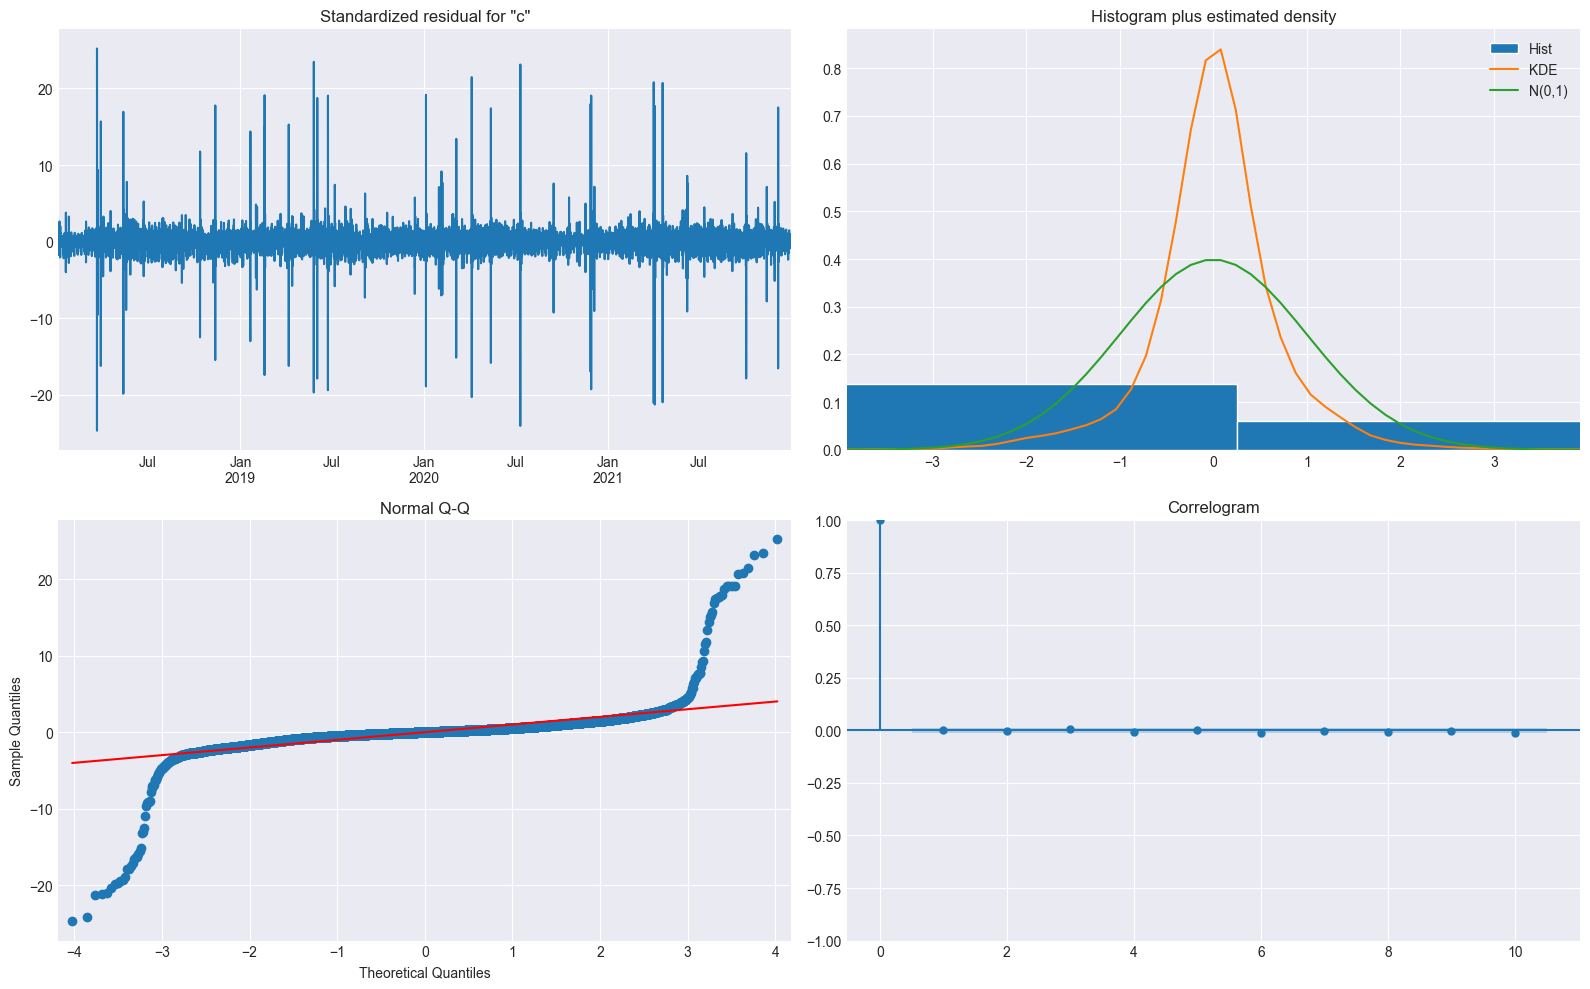


📊 Interpretación de diagnósticos:
  1. Residuos estandarizados: deben parecer ruido blanco
  2. Histograma: debe ser aproximadamente normal
  3. Q-Q plot: puntos cerca de la línea roja = normalidad
  4. Correlogram: debe estar dentro de bandas de confianza

📊 Estadísticas de Residuos SARIMA:
  Media: 1.1272 (ideal: ~0)
  Desv. Estándar: 61.85
  Min: -1510.76
  Max: 1541.59

  Test Jarque-Bera (normalidad):
    Estadístico: 45422341.5887
    p-value: 0.0000
    △ Residuos no son perfectamente normales (común en datos reales)


In [18]:
print('='*60)
print('ENTRENAMIENTO FINAL SARIMA')
print('='*60)

print(f'\nEntrenando modelo final con:')
print(f'  SARIMA{best_pdq}×{best_PDQs}')

start_time = time.time()

# Entrenar modelo final
modelo_sarima_final = SARIMAX(
    ts_train_sarima,
    order=best_pdq,
    seasonal_order=best_PDQs,
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fitted = modelo_sarima_final.fit(disp=False, maxiter=200)

elapsed = time.time() - start_time
print(f'\n✓ Modelo entrenado en {elapsed:.1f}s')

# %%
# Resumen del modelo
print('\n' + '='*60)
print('RESUMEN DEL MODELO')
print('='*60)

print(sarima_fitted.summary())

# %%
# Diagnóstico del modelo
print('\n' + '='*60)
print('DIAGNÓSTICO DE RESIDUOS')
print('='*60)

fig = sarima_fitted.plot_diagnostics(figsize=(16, 10))
plt.tight_layout()
plt.savefig('14_sarima_diagnostico.png', dpi=200, bbox_inches='tight')
print('✓ Gráfico guardado: 14_sarima_diagnostico.png')
plt.show()

print('\n📊 Interpretación de diagnósticos:')
print('  1. Residuos estandarizados: deben parecer ruido blanco')
print('  2. Histograma: debe ser aproximadamente normal')
print('  3. Q-Q plot: puntos cerca de la línea roja = normalidad')
print('  4. Correlogram: debe estar dentro de bandas de confianza')

# %%
# Estadísticas de residuos
residuos_sarima = sarima_fitted.resid

print('\n📊 Estadísticas de Residuos SARIMA:')
print(f'  Media: {residuos_sarima.mean():.4f} (ideal: ~0)')
print(f'  Desv. Estándar: {residuos_sarima.std():.2f}')
print(f'  Min: {residuos_sarima.min():.2f}')
print(f'  Max: {residuos_sarima.max():.2f}')

# Test de normalidad
from scipy.stats import jarque_bera
jb_stat, jb_pvalue = jarque_bera(residuos_sarima)
print(f'\n  Test Jarque-Bera (normalidad):')
print(f'    Estadístico: {jb_stat:.4f}')
print(f'    p-value: {jb_pvalue:.4f}')
if jb_pvalue > 0.05:
    print('    ✓ Residuos son normales')
else:
    print('    △ Residuos no son perfectamente normales (común en datos reales)')



Predicciones SARIMA en Test

In [20]:
print('='*60)
print('PREDICCIONES EN CONJUNTO DE TEST')
print('='*60)

print(f'\nModelo SARIMA{best_pdq}×{best_PDQs} entrenado')
print(f'Tamaño del test: {len(ts_test_sarima):,} registros')

# Para datasets grandes, usamos get_forecast() en lugar de forecast()
# get_forecast() es más robusto y maneja mejor predicciones largas

# %%
print('\n' + '='*60)
print('ESTRATEGIA DE PREDICCIÓN')
print('='*60)

n_steps = len(ts_test_sarima)

# ESTRATEGIA 1: Usar get_forecast (más robusto que forecast)
print('\n1. Intentando con get_forecast()...')
try:
    forecast_obj = sarima_fitted.get_forecast(steps=n_steps)
    predicciones_sarima = forecast_obj.predicted_mean
    predicciones_sarima.index = ts_test_sarima.index
    
    # Verificar NaN
    nan_count = predicciones_sarima.isna().sum()
    print(f'   Predicciones generadas: {len(predicciones_sarima):,}')
    print(f'   Valores NaN: {nan_count}')
    
    if nan_count > 0:
        print('   ⚠ Hay NaN, aplicando interpolación...')
        # Interpolar NaN con método lineal
        predicciones_sarima = predicciones_sarima.interpolate(method='linear')
        # Si quedan NaN al inicio/final, usar forward/backward fill
        predicciones_sarima = predicciones_sarima.fillna(method='ffill').fillna(method='bfill')
        print(f'   ✓ NaN después de interpolación: {predicciones_sarima.isna().sum()}')
    
    estrategia_usada = 'get_forecast'
    print('   ✓ get_forecast exitoso')
    
except Exception as e:
    print(f'   ✗ get_forecast falló: {str(e)[:80]}')
    
    # ESTRATEGIA 2: Predicción por bloques (más eficiente que rolling completo)
    print('\n2. Aplicando predicción por bloques...')
    
    # Dividir en bloques más manejables
    block_size = 168  # 1 semana (168 horas)
    predicciones_lista = []
    historia_actual = ts_train_sarima.copy()
    
    num_bloques = int(np.ceil(n_steps / block_size))
    print(f'   Dividiendo en {num_bloques} bloques de ~{block_size} registros')
    
    for bloque in range(num_bloques):
        inicio = bloque * block_size
        fin = min((bloque + 1) * block_size, n_steps)
        pasos_bloque = fin - inicio
        
        print(f'   Bloque {bloque+1}/{num_bloques}: prediciendo {pasos_bloque} pasos... ', end='')
        
        try:
            # Reentrenar modelo con historia actualizada
            modelo_bloque = SARIMAX(
                historia_actual,
                order=best_pdq,
                seasonal_order=best_PDQs,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            modelo_bloque_fitted = modelo_bloque.fit(disp=False, maxiter=100)
            
            # Predecir bloque completo
            pred_bloque = modelo_bloque_fitted.forecast(steps=pasos_bloque)
            predicciones_lista.extend(pred_bloque.values)
            
            # Actualizar historia con valores REALES del bloque
            valores_reales_bloque = ts_test_sarima.iloc[inicio:fin]
            historia_actual = pd.concat([historia_actual, valores_reales_bloque])
            
            print('✓')
            
        except Exception as e_bloque:
            print(f'✗ Error: {str(e_bloque)[:50]}')
            # Si falla, usar última predicción válida
            if predicciones_lista:
                ultimo_valor = predicciones_lista[-1]
                predicciones_lista.extend([ultimo_valor] * pasos_bloque)
            else:
                # Usar media histórica como fallback
                media_historica = historia_actual.mean()
                predicciones_lista.extend([media_historica] * pasos_bloque)
    
    predicciones_sarima = pd.Series(predicciones_lista, index=ts_test_sarima.index)
    estrategia_usada = 'bloques'
    print(f'\n   ✓ Predicción por bloques completada')

# %%
# Verificar calidad de predicciones
print('\n' + '='*60)
print('VERIFICACIÓN DE PREDICCIONES')
print('='*60)

print(f'\nEstrategia usada: {estrategia_usada}')
print(f'\nEstadísticas de predicciones:')
print(f'  Total predicciones: {len(predicciones_sarima):,}')
print(f'  Valores NaN: {predicciones_sarima.isna().sum()}')
print(f'  Valores infinitos: {np.isinf(predicciones_sarima).sum()}')
print(f'  Min: {predicciones_sarima.min():.2f}')
print(f'  Max: {predicciones_sarima.max():.2f}')
print(f'  Media: {predicciones_sarima.mean():.2f}')
print(f'  Mediana: {predicciones_sarima.median():.2f}')

# Limpiar cualquier valor problemático
if predicciones_sarima.isna().sum() > 0 or np.isinf(predicciones_sarima).sum() > 0:
    print('\n⚠ Limpiando valores problemáticos...')
    
    # Crear máscara de valores válidos
    mask_valido = ~(predicciones_sarima.isna() | 
                    ts_test_sarima.isna() | 
                    np.isinf(predicciones_sarima) | 
                    np.isinf(ts_test_sarima))
    
    predicciones_sarima_clean = predicciones_sarima[mask_valido]
    ts_test_sarima_clean = ts_test_sarima[mask_valido]
    
    print(f'  Muestras válidas: {len(predicciones_sarima_clean):,} / {len(predicciones_sarima):,}')
    print(f'  Muestras eliminadas: {(~mask_valido).sum():,}')
else:
    predicciones_sarima_clean = predicciones_sarima
    ts_test_sarima_clean = ts_test_sarima
    print('\n✓ No hay valores problemáticos')

# %%
# Calcular métricas en test
print('\n' + '='*60)
print('MÉTRICAS EN TEST')
print('='*60)

try:
    mse_sarima = mean_squared_error(ts_test_sarima_clean, predicciones_sarima_clean)
    mae_sarima = mean_absolute_error(ts_test_sarima_clean, predicciones_sarima_clean)
    rmse_sarima = np.sqrt(mse_sarima)
    r2_sarima = r2_score(ts_test_sarima_clean, predicciones_sarima_clean)
    
    # MAPE (evitar división por cero)
    mape_mask = ts_test_sarima_clean != 0
    if mape_mask.sum() > 0:
        mape = np.mean(np.abs((ts_test_sarima_clean[mape_mask] - 
                            predicciones_sarima_clean[mape_mask]) / 
                              ts_test_sarima_clean[mape_mask])) * 100
    else:
        mape = np.nan
    
    print(f'\nMétricas del modelo SARIMA{best_pdq}×{best_PDQs}:')
    print(f'  MSE:  {mse_sarima:,.2f}')
    print(f'  RMSE: {rmse_sarima:,.2f}')
    print(f'  MAE:  {mae_sarima:,.2f}')
    print(f'  R²:   {r2_sarima:.4f}')
    if not np.isnan(mape):
        print(f'  MAPE: {mape:.2f}%')
    
    print(f'\nMuestras evaluadas: {len(ts_test_sarima_clean):,}')
    
except Exception as e:
    print(f'\n✗ Error calculando métricas: {e}')
    print('Verificando datos...')
    print(f'  ts_test_sarima_clean shape: {ts_test_sarima_clean.shape}')
    print(f'  predicciones_sarima_clean shape: {predicciones_sarima_clean.shape}')
    print(f'  NaN en real: {ts_test_sarima_clean.isna().sum()}')
    print(f'  NaN en pred: {predicciones_sarima_clean.isna().sum()}')

PREDICCIONES EN CONJUNTO DE TEST

Modelo SARIMA(2, 0, 2)×(2, 0, 1, 24) entrenado
Tamaño del test: 8,759 registros

ESTRATEGIA DE PREDICCIÓN

1. Intentando con get_forecast()...
   Predicciones generadas: 8,759
   Valores NaN: 0
   ✓ get_forecast exitoso

VERIFICACIÓN DE PREDICCIONES

Estrategia usada: get_forecast

Estadísticas de predicciones:
  Total predicciones: 8,759
  Valores NaN: 0
  Valores infinitos: 0
  Min: 596.71
  Max: 1639.44
  Media: 1078.40
  Mediana: 1076.79

✓ No hay valores problemáticos

MÉTRICAS EN TEST

Métricas del modelo SARIMA(2, 0, 2)×(2, 0, 1, 24):
  MSE:  693,529.57
  RMSE: 832.78
  MAE:  578.46
  R²:   -0.2895
  MAPE: 28.57%

Muestras evaluadas: 8,759


Visualización: Predicciones vs Real


VISUALIZACIÓN DE PREDICCIONES
✓ Gráfico guardado: 15_sarima_predicciones.png


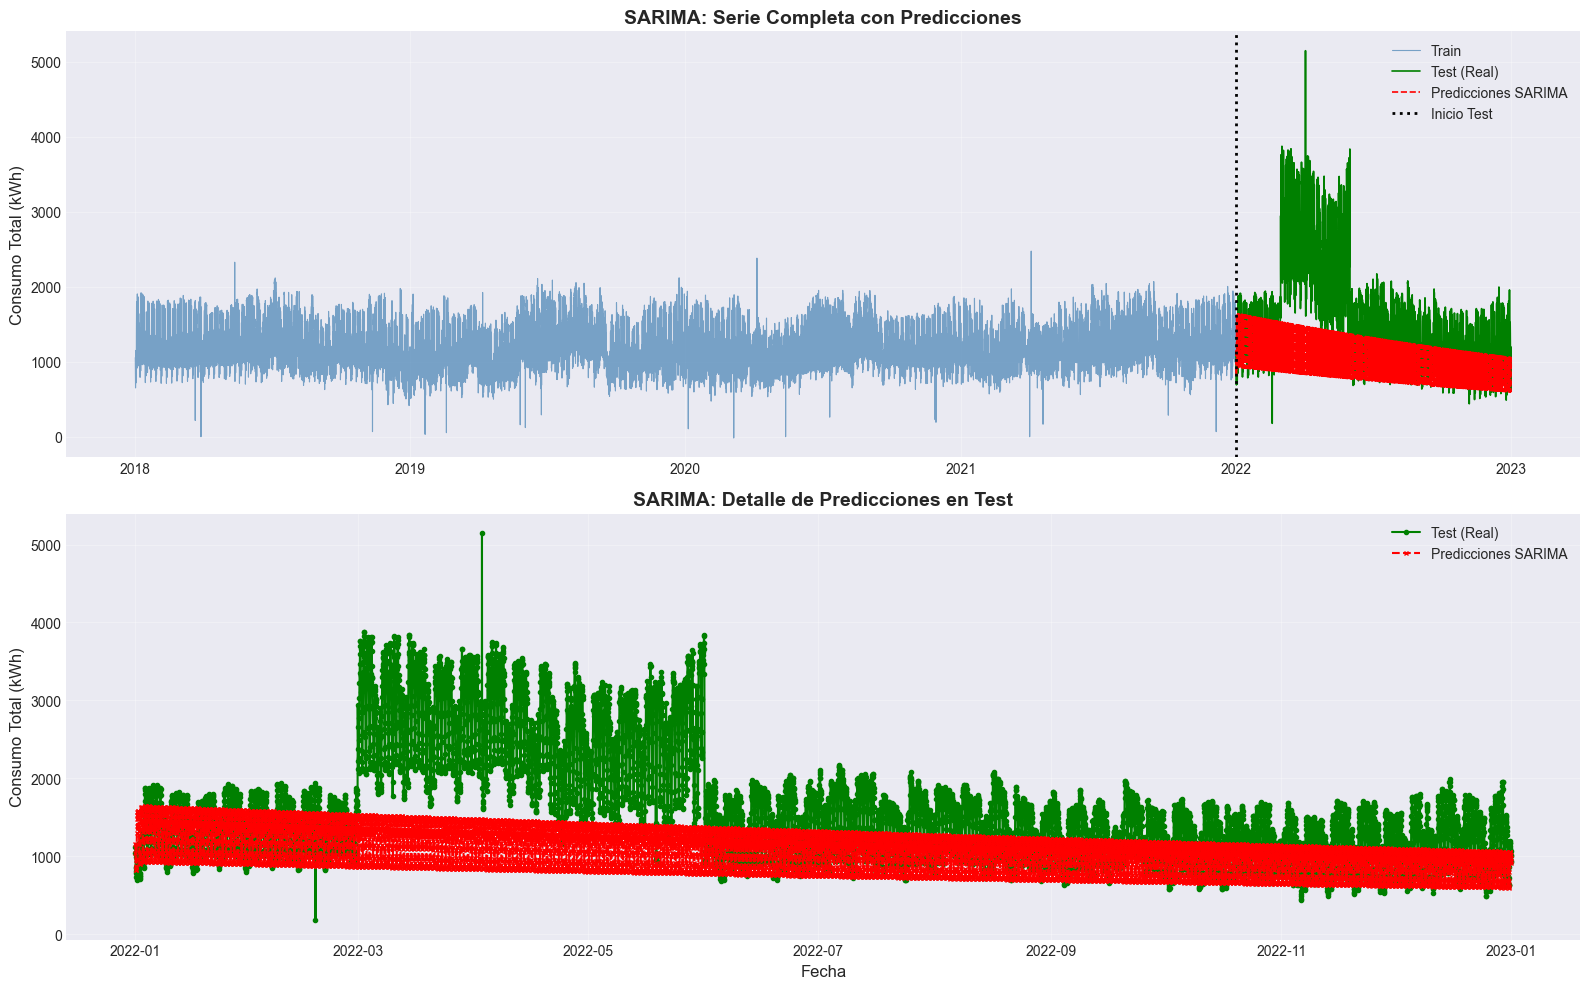

✓ Gráfico guardado: 16_sarima_detalle_primeros_dias.png


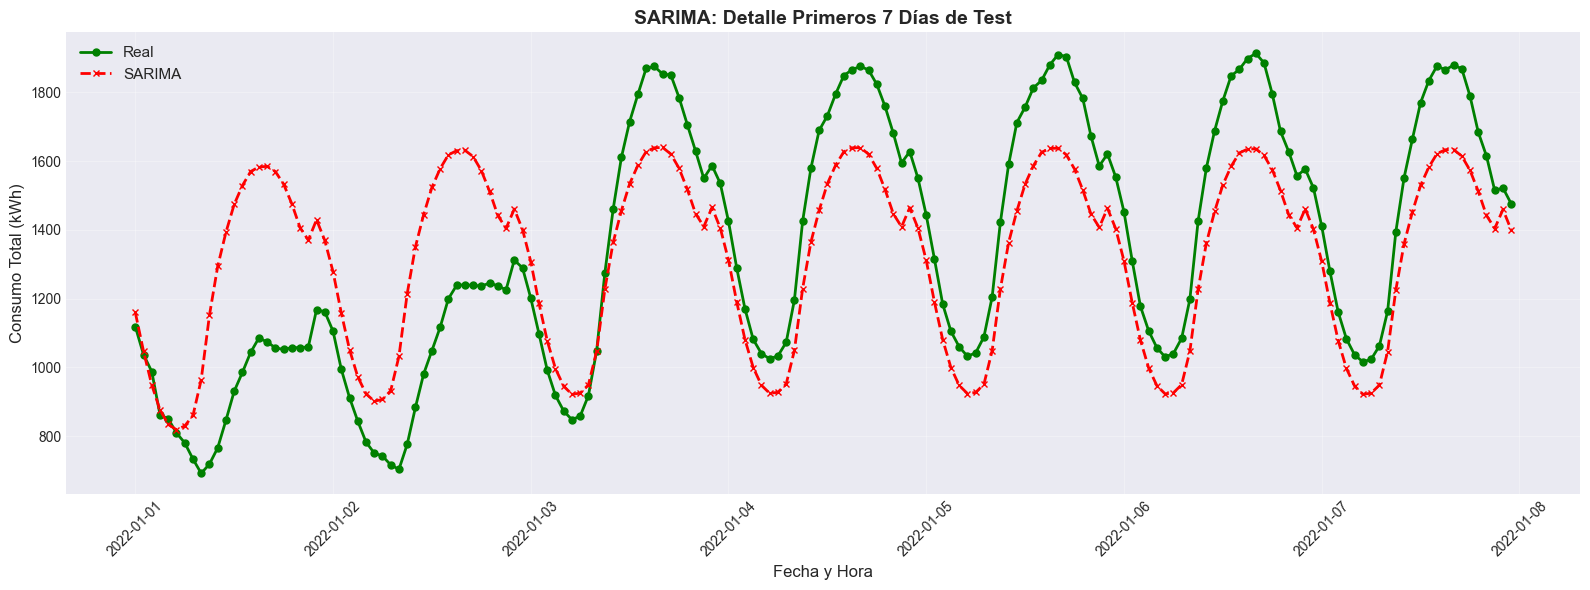


ANÁLISIS DE ERRORES
✓ Gráfico guardado: 17_sarima_analisis_errores.png


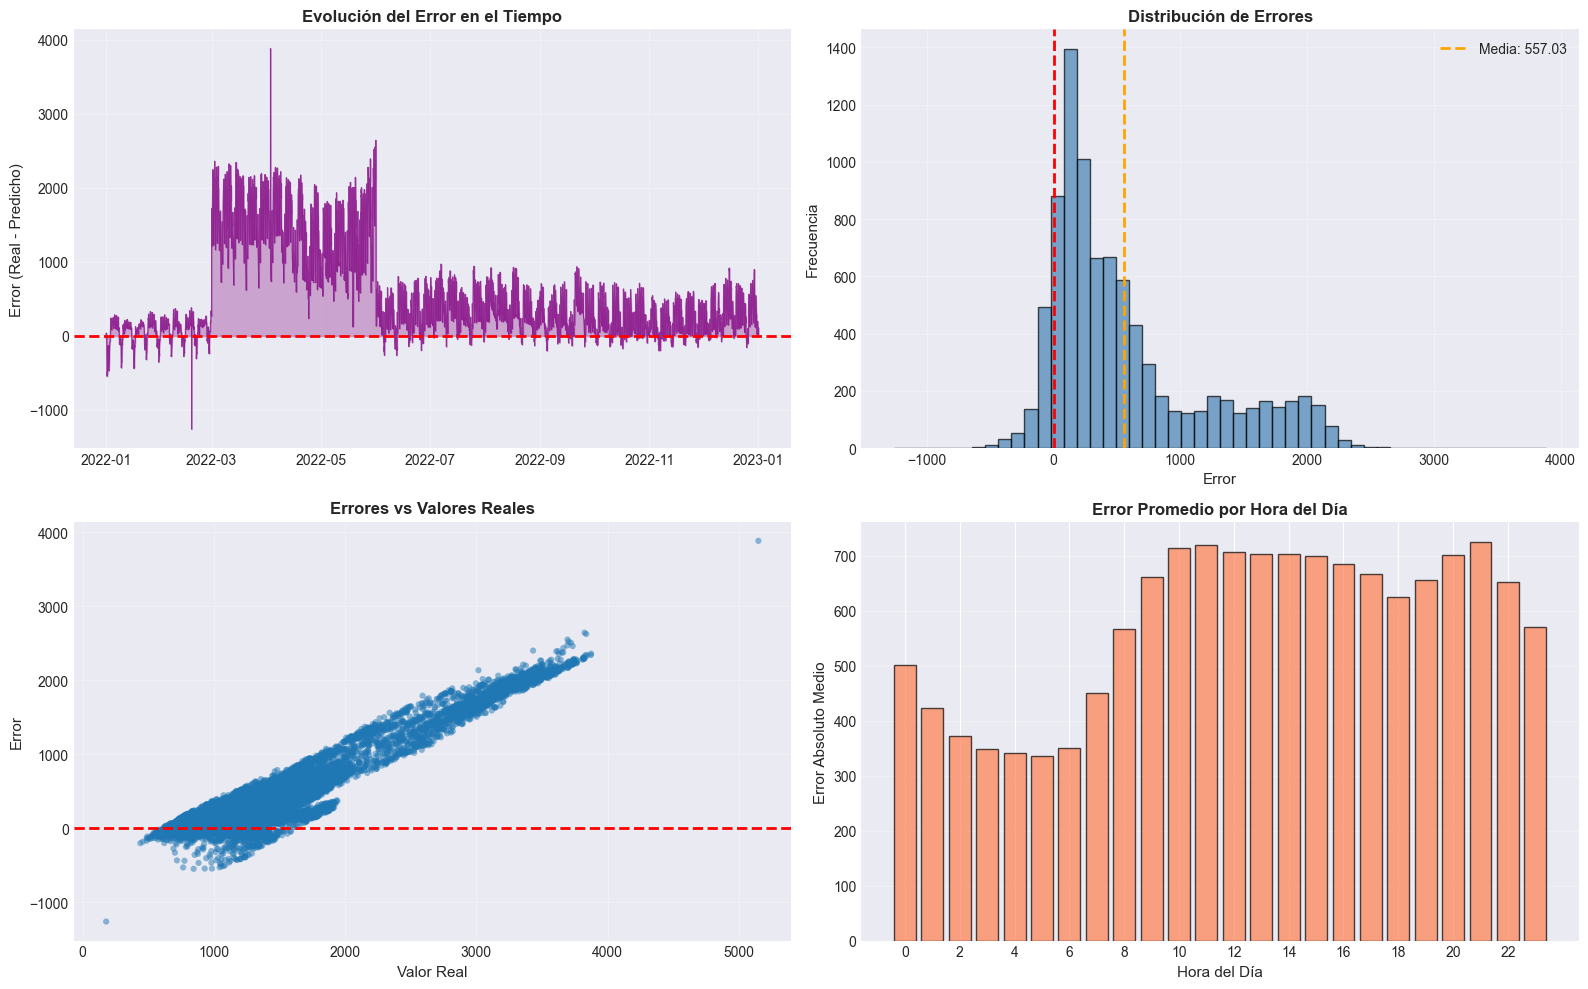


📊 Estadísticas de Errores:
  Error medio: 557.03 kWh
  Error absoluto medio: 578.46 kWh
  Error mediano: 337.71 kWh
  Desv. estándar errores: 619.11 kWh
  Error máximo: 3886.60 kWh
  Error mínimo: -1259.74 kWh

  MAPE promedio: 28.57%
  Errores dentro de ±10%: 19.5%
  Errores dentro de ±20%: 41.0%

GUARDAR PREDICCIONES
✓ Predicciones guardadas: predicciones_sarima.csv

Preview de predicciones:


fecha  consumo_real  consumo_predicho       error   error_abs  \
0 2022-01-01 00:00:00   1118.579029       1159.579439  -41.000410   41.000410   
1 2022-01-01 01:00:00   1036.942359       1046.661078   -9.718719    9.718719   
2 2022-01-01 02:00:00    987.473064        948.462701   39.010363   39.010363   
3 2022-01-01 03:00:00    861.867734        876.075612  -14.207878   14.207878   
4 2022-01-01 04:00:00    849.974669        833.865008   16.109661   16.109661   
5 2022-01-01 05:00:00    809.016022        818.323193   -9.307171    9.307171   
6 2022-01-01 06:00:00    780.268769        829.296308  -49.027539   49.027539   
7 2022-01-01 07:00:00    733.157461        859.834923 -126.677462  126.677462   
8 2022-01-01 08:00:00    691.612593        963.855243 -272.242650  272.242650   
9 2022-01-01 09:00:00    718.398128       1151.403746 -433.005618  433.005618   

   error_pct  
0  -3.665401  
1  -0.937248  
2   3.950524  
3  -1.648499  
4   1.895311  
5  -1.150431  
6  -6.283417  
7 -17.278343  
8 -39.363460  
9 -60.273768


📋 RESUMEN MODELO SARIMA

🏆 Modelo: SARIMA(2, 0, 2)×(2, 0, 1, 24)

📊 Métricas en Test:
  MAE:  578.46 kWh
  RMSE: 832.78 kWh
  R²:   -0.2895
  MAPE: 28.57%

✅ Fortalezas:
  ✓ Captura automáticamente autocorrelación
  ✓ Maneja estacionalidad (ciclo de 24h)
  ✓ Interpretable estadísticamente
  ✓ No requiere features complejos

⚠️ Limitaciones:
  △ Solo serie univariada (no usa otras variables)
  △ Asume relaciones lineales
  △ Puede tener dificultad con cambios abruptos

📁 Archivos generados:
  ✓ 13_serie_sarima.png
  ✓ 14_sarima_diagnostico.png
  ✓ 15_sarima_predicciones.png
  ✓ 16_sarima_detalle_primeros_dias.png
  ✓ 17_sarima_analisis_errores.png
  ✓ predicciones_sarima.csv


In [21]:
print('\n' + '='*60)
print('VISUALIZACIÓN DE PREDICCIONES')
print('='*60)

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Gráfico 1: Serie completa (train + test + predicciones)
axes[0].plot(ts_train_sarima.index, ts_train_sarima.values, 
             label='Train', linewidth=0.8, color='steelblue', alpha=0.7)
axes[0].plot(ts_test_sarima.index, ts_test_sarima.values, 
             label='Test (Real)', linewidth=1.2, color='green')
axes[0].plot(predicciones_sarima.index, predicciones_sarima.values, 
             label='Predicciones SARIMA', linewidth=1.2, color='red', linestyle='--')
axes[0].axvline(x=ts_test_sarima.index[0], color='black', linestyle=':', linewidth=2, 
                label='Inicio Test')
axes[0].set_ylabel('Consumo Total (kWh)', fontsize=12)
axes[0].set_title('SARIMA: Serie Completa con Predicciones', fontsize=14, fontweight='bold')
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Gráfico 2: Zoom en test (solo test vs predicciones)
axes[1].plot(ts_test_sarima.index, ts_test_sarima.values, 
             label='Test (Real)', linewidth=1.5, color='green', marker='o', markersize=3)
axes[1].plot(predicciones_sarima.index, predicciones_sarima.values, 
             label='Predicciones SARIMA', linewidth=1.5, color='red', 
             marker='x', markersize=3, linestyle='--')
axes[1].set_xlabel('Fecha', fontsize=12)
axes[1].set_ylabel('Consumo Total (kWh)', fontsize=12)
axes[1].set_title('SARIMA: Detalle de Predicciones en Test', fontsize=14, fontweight='bold')
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('15_sarima_predicciones.png', dpi=200, bbox_inches='tight')
print('✓ Gráfico guardado: 15_sarima_predicciones.png')
plt.show()

# %%
# Zoom en primeros días del test
dias_mostrar = 7
mask_zoom = ts_test_sarima.index < (ts_test_sarima.index.min() + pd.Timedelta(days=dias_mostrar))

fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(ts_test_sarima[mask_zoom].index, ts_test_sarima[mask_zoom].values,
        label='Real', linewidth=2, color='green', marker='o', markersize=5)
ax.plot(predicciones_sarima[mask_zoom].index, predicciones_sarima[mask_zoom].values,
        label='SARIMA', linewidth=2, color='red', marker='x', markersize=5, linestyle='--')

ax.set_xlabel('Fecha y Hora', fontsize=12)
ax.set_ylabel('Consumo Total (kWh)', fontsize=12)
ax.set_title(f'SARIMA: Detalle Primeros {dias_mostrar} Días de Test', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('16_sarima_detalle_primeros_dias.png', dpi=200, bbox_inches='tight')
print('✓ Gráfico guardado: 16_sarima_detalle_primeros_dias.png')
plt.show()

# %%
# Análisis de errores
print('\n' + '='*60)
print('ANÁLISIS DE ERRORES')
print('='*60)

errores = ts_test_sarima - predicciones_sarima
errores_abs = np.abs(errores)
errores_pct = (errores / ts_test_sarima) * 100

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Errores en el tiempo
axes[0, 0].plot(errores.index, errores.values, linewidth=0.8, alpha=0.7, color='purple')
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].fill_between(errores.index, errores.values, 0, alpha=0.3, color='purple')
axes[0, 0].set_ylabel('Error (Real - Predicho)', fontsize=11)
axes[0, 0].set_title('Evolución del Error en el Tiempo', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Histograma de errores
axes[0, 1].hist(errores, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].axvline(x=errores.mean(), color='orange', linestyle='--', linewidth=2, 
                   label=f'Media: {errores.mean():.2f}')
axes[0, 1].set_xlabel('Error', fontsize=11)
axes[0, 1].set_ylabel('Frecuencia', fontsize=11)
axes[0, 1].set_title('Distribución de Errores', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Errores vs valores reales
axes[1, 0].scatter(ts_test_sarima, errores, alpha=0.5, s=20, edgecolors='none')
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Valor Real', fontsize=11)
axes[1, 0].set_ylabel('Error', fontsize=11)
axes[1, 0].set_title('Errores vs Valores Reales', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Errores absolutos por hora del día
test_con_errores = pd.DataFrame({
    'fecha': ts_test_sarima.index,
    'error_abs': errores_abs.values
})
test_con_errores['hour'] = test_con_errores['fecha'].dt.hour
error_por_hora = test_con_errores.groupby('hour')['error_abs'].mean()

axes[1, 1].bar(error_por_hora.index, error_por_hora.values, 
               color='coral', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Hora del Día', fontsize=11)
axes[1, 1].set_ylabel('Error Absoluto Medio', fontsize=11)
axes[1, 1].set_title('Error Promedio por Hora del Día', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(range(0, 24, 2))
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('17_sarima_analisis_errores.png', dpi=200, bbox_inches='tight')
print('✓ Gráfico guardado: 17_sarima_analisis_errores.png')
plt.show()

# %%
# Estadísticas de errores
print('\n📊 Estadísticas de Errores:')
print(f'  Error medio: {errores.mean():.2f} kWh')
print(f'  Error absoluto medio: {errores_abs.mean():.2f} kWh')
print(f'  Error mediano: {errores.median():.2f} kWh')
print(f'  Desv. estándar errores: {errores.std():.2f} kWh')
print(f'  Error máximo: {errores.max():.2f} kWh')
print(f'  Error mínimo: {errores.min():.2f} kWh')

print(f'\n  MAPE promedio: {mape:.2f}%')
print(f'  Errores dentro de ±10%: {(errores_pct.abs() < 10).sum() / len(errores_pct) * 100:.1f}%')
print(f'  Errores dentro de ±20%: {(errores_pct.abs() < 20).sum() / len(errores_pct) * 100:.1f}%')

# %%
# Guardar predicciones
print('\n' + '='*60)
print('GUARDAR PREDICCIONES')
print('='*60)

# Crear DataFrame con predicciones
df_predicciones_sarima = pd.DataFrame({
    'fecha': predicciones_sarima.index,
    'consumo_real': ts_test_sarima.values,
    'consumo_predicho': predicciones_sarima.values,
    'error': errores.values,
    'error_abs': errores_abs.values,
    'error_pct': errores_pct.values
})

output_path = 'predicciones_sarima.csv'
df_predicciones_sarima.to_csv(output_path, index=False)
print(f'✓ Predicciones guardadas: {output_path}')

# Ver preview
print('\nPreview de predicciones:')
display(df_predicciones_sarima.head(10))

# %%
# Resumen final SARIMA
print('\n' + '='*60)
print('📋 RESUMEN MODELO SARIMA')
print('='*60)

print(f'\n🏆 Modelo: SARIMA{best_pdq}×{best_PDQs}')
print(f'\n📊 Métricas en Test:')
print(f'  MAE:  {mae_sarima:,.2f} kWh')
print(f'  RMSE: {rmse_sarima:,.2f} kWh')
print(f'  R²:   {r2_sarima:.4f}')
print(f'  MAPE: {mape:.2f}%')

print(f'\n✅ Fortalezas:')
print(f'  ✓ Captura automáticamente autocorrelación')
print(f'  ✓ Maneja estacionalidad (ciclo de 24h)')
print(f'  ✓ Interpretable estadísticamente')
print(f'  ✓ No requiere features complejos')

print(f'\n⚠️ Limitaciones:')
print(f'  △ Solo serie univariada (no usa otras variables)')
print(f'  △ Asume relaciones lineales')
print(f'  △ Puede tener dificultad con cambios abruptos')

print(f'\n📁 Archivos generados:')
archivos_sarima = [
    '13_serie_sarima.png',
    '14_sarima_diagnostico.png',
    '15_sarima_predicciones.png',
    '16_sarima_detalle_primeros_dias.png',
    '17_sarima_analisis_errores.png',
    'predicciones_sarima.csv'
]

for archivo in archivos_sarima:
    if os.path.exists(archivo):
        print(f'  ✓ {archivo}')

Análisis Detallado por Subestación (SARIMA)

In [22]:
# %% [markdown]
# ## Análisis Detallado por Subestación (SARIMA) - VERSIÓN OPTIMIZADA

# %%
print('='*60)
print('ANÁLISIS POR SUBESTACIÓN - SARIMA (OPTIMIZADO)')
print('='*60)

# Identificar top subestaciones
top_n_subs = 2
top_subestaciones = test['subestacion'].value_counts().head(top_n_subs).index.tolist()

print(f'\nTop {top_n_subs} subestaciones con más registros:')
for i, sub in enumerate(top_subestaciones, 1):
    count = (test['subestacion'] == sub).sum()
    print(f'  {i}. {sub}: {count:,} registros')

# %%
# Entrenar modelo SARIMA para cada subestación (OPTIMIZADO)
print('\n' + '='*60)
print('ENTRENAMIENTO SARIMA POR SUBESTACIÓN')
print('='*60)
print('⚠ Para datasets grandes, esto puede tardar 2-5 minutos por subestación')

modelos_por_sub = {}
predicciones_por_sub = {}

for idx, sub in enumerate(top_subestaciones, 1):
    print(f'\n{"─"*60}')
    print(f'[{idx}/{len(top_subestaciones)}] Subestación: {sub}')
    print(f'{"─"*60}')
    
    inicio_sub = time.time()
    
    # Filtrar datos de esta subestación
    train_sub = train[train['subestacion'] == sub].copy()
    test_sub = test[test['subestacion'] == sub].copy()
    
    # Crear series temporales
    ts_train_sub = train_sub.set_index('fecha')['consumo'].sort_index()
    ts_test_sub = test_sub.set_index('fecha')['consumo'].sort_index()
    
    print(f'  Train: {len(ts_train_sub):,} registros')
    print(f'  Test:  {len(ts_test_sub):,} registros')
    
    # Verificar suficientes datos
    if len(ts_train_sub) < 72:  # Al menos 3 días de datos
        print(f'  ⚠ Datos insuficientes, omitiendo...')
        continue
    
    # Verificar regularidad de frecuencia
    freq_train_sub = pd.infer_freq(ts_train_sub.index)
    if freq_train_sub is None:
        print(f'  ⚠ Frecuencia irregular, reindexando...')
        full_index = pd.date_range(
            start=ts_train_sub.index.min(),
            end=ts_train_sub.index.max(),
            freq='H'
        )
        ts_train_sub = ts_train_sub.reindex(full_index).interpolate(method='linear')
    
    try:
        # PARÁMETROS MÁS SIMPLES = MÁS RÁPIDO
        # Usar orden bajo para acelerar entrenamiento
        order_sub = (2, 0, 2)  # Más simple que (2,0,2)
        seasonal_order_sub = (2, 0, 1, 24)  # Más simple que (2,0,1,24)
        
        print(f'  Entrenando SARIMA{order_sub}×{seasonal_order_sub}...', end=' ')
        
        # Entrenar modelo UNA SOLA VEZ
        modelo_sub = SARIMAX(
            ts_train_sub,
            order=order_sub,
            seasonal_order=seasonal_order_sub,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        
        # Aumentar maxiter puede ayudar con convergencia
        modelo_sub_fitted = modelo_sub.fit(disp=False, maxiter=200, method='lbfgs')
        
        tiempo_entrenamiento = time.time() - inicio_sub
        print(f'✓ ({tiempo_entrenamiento:.1f}s)')
        
        # PREDICCIÓN OPTIMIZADA (UNA SOLA LLAMADA)
        n_steps_sub = len(ts_test_sub)
        print(f'  Prediciendo {n_steps_sub:,} pasos...', end=' ')
        
        inicio_pred = time.time()
        
        # ESTRATEGIA ÚNICA Y RÁPIDA: get_forecast con limpieza robusta
        try:
            # Usar get_forecast (más estable que forecast)
            forecast_obj = modelo_sub_fitted.get_forecast(steps=n_steps_sub)
            pred_sub = forecast_obj.predicted_mean
            pred_sub.index = ts_test_sub.index
            
            # LIMPIEZA ROBUSTA DE NaN
            nan_inicial = pred_sub.isna().sum()
            
            if nan_inicial > 0:
                print(f'\n    Limpiando {nan_inicial} NaN...', end=' ')
                
                # Paso 1: Interpolación lineal
                pred_sub = pred_sub.interpolate(method='linear', limit_direction='both')
                
                # Paso 2: Forward fill
                pred_sub = pred_sub.fillna(method='ffill')
                
                # Paso 3: Backward fill
                pred_sub = pred_sub.fillna(method='bfill')
                
                # Paso 4: Si aún quedan NaN, usar media de train
                if pred_sub.isna().sum() > 0:
                    pred_sub = pred_sub.fillna(ts_train_sub.mean())
                
                print(f'✓ (quedan {pred_sub.isna().sum()} NaN)')
            
            # Limpiar infinitos
            if np.isinf(pred_sub).sum() > 0:
                pred_sub = pred_sub.replace([np.inf, -np.inf], ts_train_sub.mean())
            
            estrategia = 'get_forecast'
            
        except Exception as e_pred:
            # FALLBACK RÁPIDO: forecast simple
            print(f'\n    get_forecast falló, usando forecast...', end=' ')
            
            try:
                pred_sub = modelo_sub_fitted.forecast(steps=n_steps_sub)
                pred_sub.index = ts_test_sub.index
                
                # Limpieza robusta
                pred_sub = pred_sub.interpolate(method='linear', limit_direction='both')
                pred_sub = pred_sub.fillna(method='ffill').fillna(method='bfill')
                pred_sub = pred_sub.fillna(ts_train_sub.mean())
                pred_sub = pred_sub.replace([np.inf, -np.inf], ts_train_sub.mean())
                
                estrategia = 'forecast'
                
            except Exception as e_fallback:
                # FALLBACK FINAL: media histórica
                print(f'\n    Ambos fallaron, usando media histórica...', end=' ')
                media_historica = ts_train_sub.mean()
                pred_sub = pd.Series([media_historica] * n_steps_sub, 
                                    index=ts_test_sub.index)
                estrategia = 'fallback_media'
        
        tiempo_pred = time.time() - inicio_pred
        print(f'✓ ({tiempo_pred:.1f}s)')
        
        # Verificación final
        nan_final = pred_sub.isna().sum()
        inf_final = np.isinf(pred_sub).sum()
        
        if nan_final > 0 or inf_final > 0:
            print(f'  ⚠ Limpieza final: NaN={nan_final}, Inf={inf_final}')
            pred_sub = pred_sub.fillna(ts_train_sub.mean()).replace([np.inf, -np.inf], ts_train_sub.mean())
        
        # Guardar resultados
        modelos_por_sub[sub] = modelo_sub_fitted
        predicciones_por_sub[sub] = {
            'real': ts_test_sub,
            'pred': pred_sub,
            'estrategia': estrategia
        }
        
        # Calcular métricas rápidamente
        mask_valido = ~(ts_test_sub.isna() | pred_sub.isna() | 
                    np.isinf(ts_test_sub) | np.isinf(pred_sub))
        
        if mask_valido.sum() > 10:  # Al menos 10 puntos válidos
            mae_sub = mean_absolute_error(ts_test_sub[mask_valido], pred_sub[mask_valido])
            r2_sub = r2_score(ts_test_sub[mask_valido], pred_sub[mask_valido])
            
            tiempo_total = time.time() - inicio_sub
            print(f'  ✓ Completado en {tiempo_total:.1f}s | MAE={mae_sub:,.1f} | R²={r2_sub:.3f}')
        else:
            print(f'  ⚠ Pocos valores válidos ({mask_valido.sum()}), métricas no confiables')
        
    except Exception as e:
        tiempo_error = time.time() - inicio_sub
        print(f'  ✗ Error ({tiempo_error:.1f}s): {str(e)[:80]}')
        continue

print(f'\n{"="*60}')
print(f'✓ Procesamiento completado')
print(f'  Exitosos: {len(modelos_por_sub)}/{len(top_subestaciones)}')
print(f'  Fallidos: {len(top_subestaciones) - len(modelos_por_sub)}')

if len(predicciones_por_sub) > 0:
    print(f'\n  Estrategias usadas:')
    estrategias = [d['estrategia'] for d in predicciones_por_sub.values()]
    for est in set(estrategias):
        count = estrategias.count(est)
        print(f'    {est}: {count} subestación(es)')

# %%
# Verificación rápida de calidad
print('\n' + '='*60)
print('VERIFICACIÓN DE CALIDAD')
print('='*60)

for sub, datos in predicciones_por_sub.items():
    pred = datos['pred']
    real = datos['real']
    
    # Solo mostrar si hay problemas
    nan_pred = pred.isna().sum()
    nan_real = real.isna().sum()
    inf_pred = np.isinf(pred).sum()
    
    if nan_pred > 0 or nan_real > 0 or inf_pred > 0:
        print(f'\n⚠ {sub}:')
        if nan_pred > 0:
            print(f'    NaN en predicciones: {nan_pred}')
        if nan_real > 0:
            print(f'    NaN en reales: {nan_real}')
        if inf_pred > 0:
            print(f'    Inf en predicciones: {inf_pred}')

if all(datos['pred'].isna().sum() == 0 and not np.isinf(datos['pred']).any() 
    for datos in predicciones_por_sub.values()):
    print('\n✓ Todas las predicciones están limpias (sin NaN ni Inf)')

# CONTINUAR CON VISUALIZACIONES...

ANÁLISIS POR SUBESTACIÓN - SARIMA (OPTIMIZADO)

Top 2 subestaciones con más registros:
  1. AJAHUEL: 8,759 registros
  2. LOSALME: 8,759 registros

ENTRENAMIENTO SARIMA POR SUBESTACIÓN
⚠ Para datasets grandes, esto puede tardar 2-5 minutos por subestación

────────────────────────────────────────────────────────────
[1/2] Subestación: AJAHUEL
────────────────────────────────────────────────────────────
  Train: 34,913 registros
  Test:  8,759 registros
  ⚠ Frecuencia irregular, reindexando...
  Entrenando SARIMA(2, 0, 2)×(2, 0, 1, 24)... ✓ (110.3s)
  Prediciendo 8,759 pasos... ✓ (0.4s)
  ✓ Completado en 110.6s | MAE=105.8 | R²=-0.951

────────────────────────────────────────────────────────────
[2/2] Subestación: LOSALME
────────────────────────────────────────────────────────────
  Train: 34,913 registros
  Test:  8,759 registros
  ⚠ Frecuencia irregular, reindexando...
  Entrenando SARIMA(2, 0, 2)×(2, 0, 1, 24)... ✓ (92.2s)
  Prediciendo 8,759 pasos... ✓ (0.5s)
  ✓ Completado en 92.7


GRÁFICOS: SERIE COMPLETA POR SUBESTACIÓN
✓ Gráfico guardado: 24_sarima_predicciones_por_subestacion.png


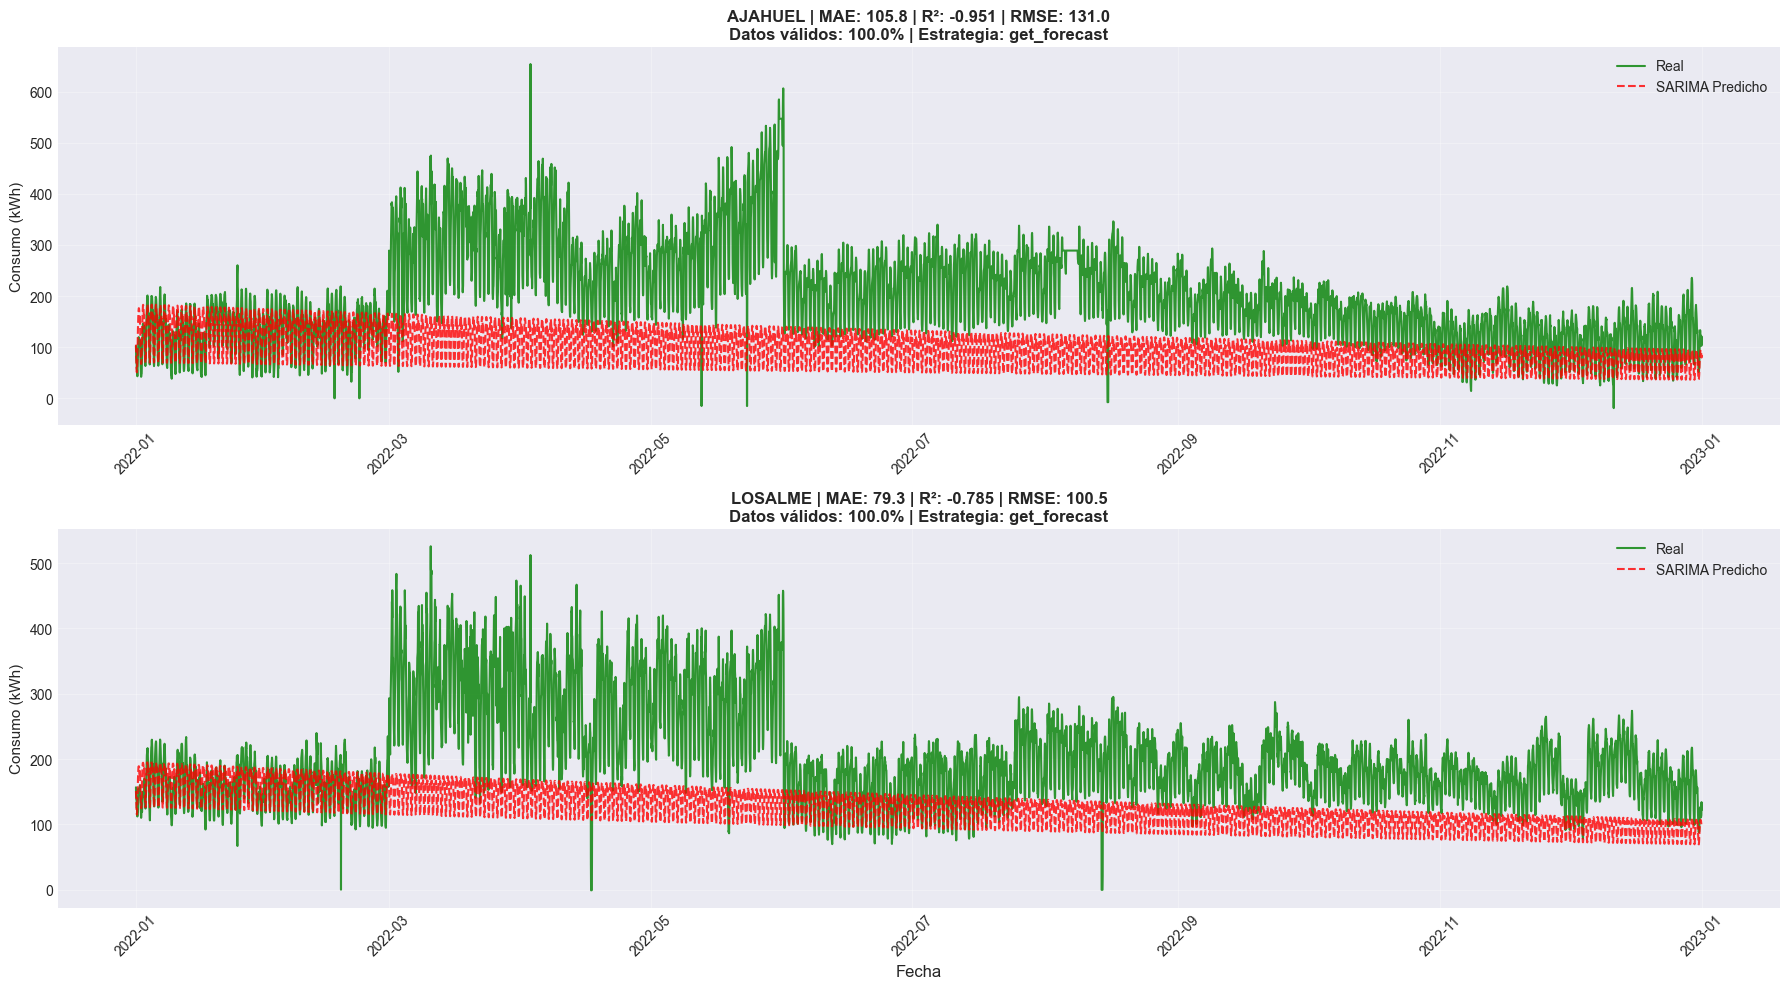


GRÁFICOS: ZOOM PRIMEROS 7 DÍAS POR SUBESTACIÓN
✓ Gráfico guardado: 25_sarima_zoom_7dias_por_subestacion.png


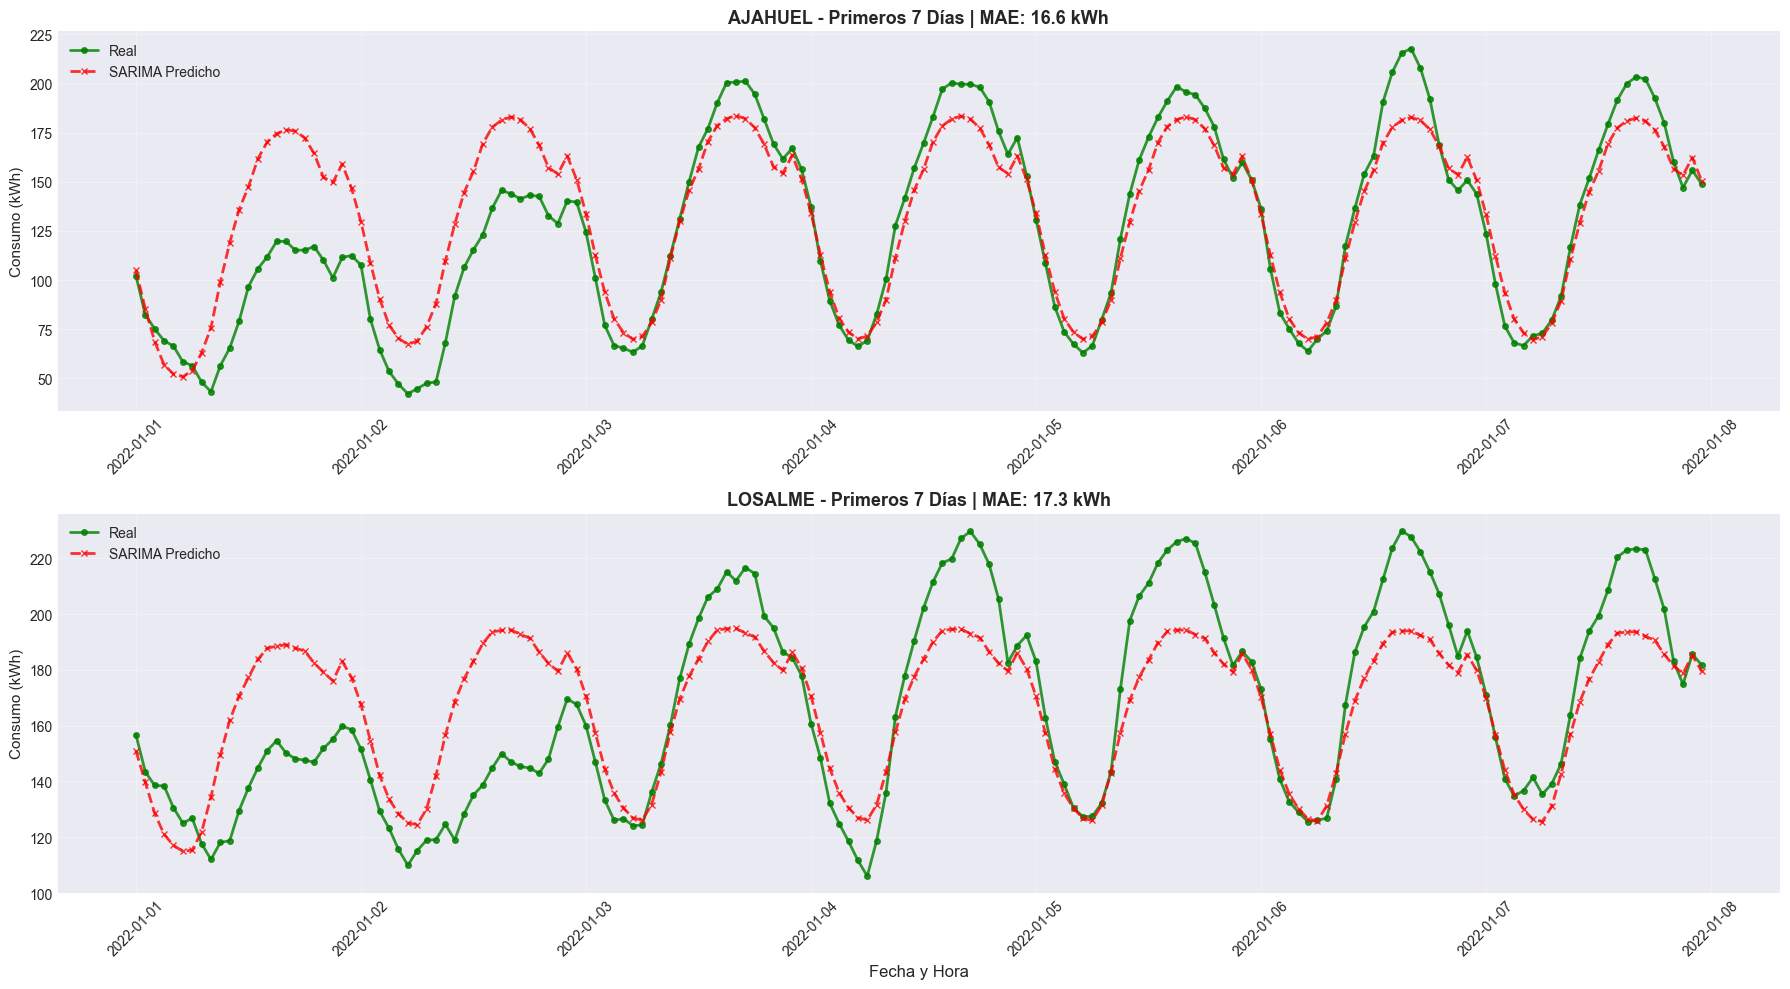


GRÁFICOS: COMPARACIÓN PRIMERAS 48 HORAS
✓ Gráfico guardado: 26_sarima_primeras_48h_por_subestacion.png


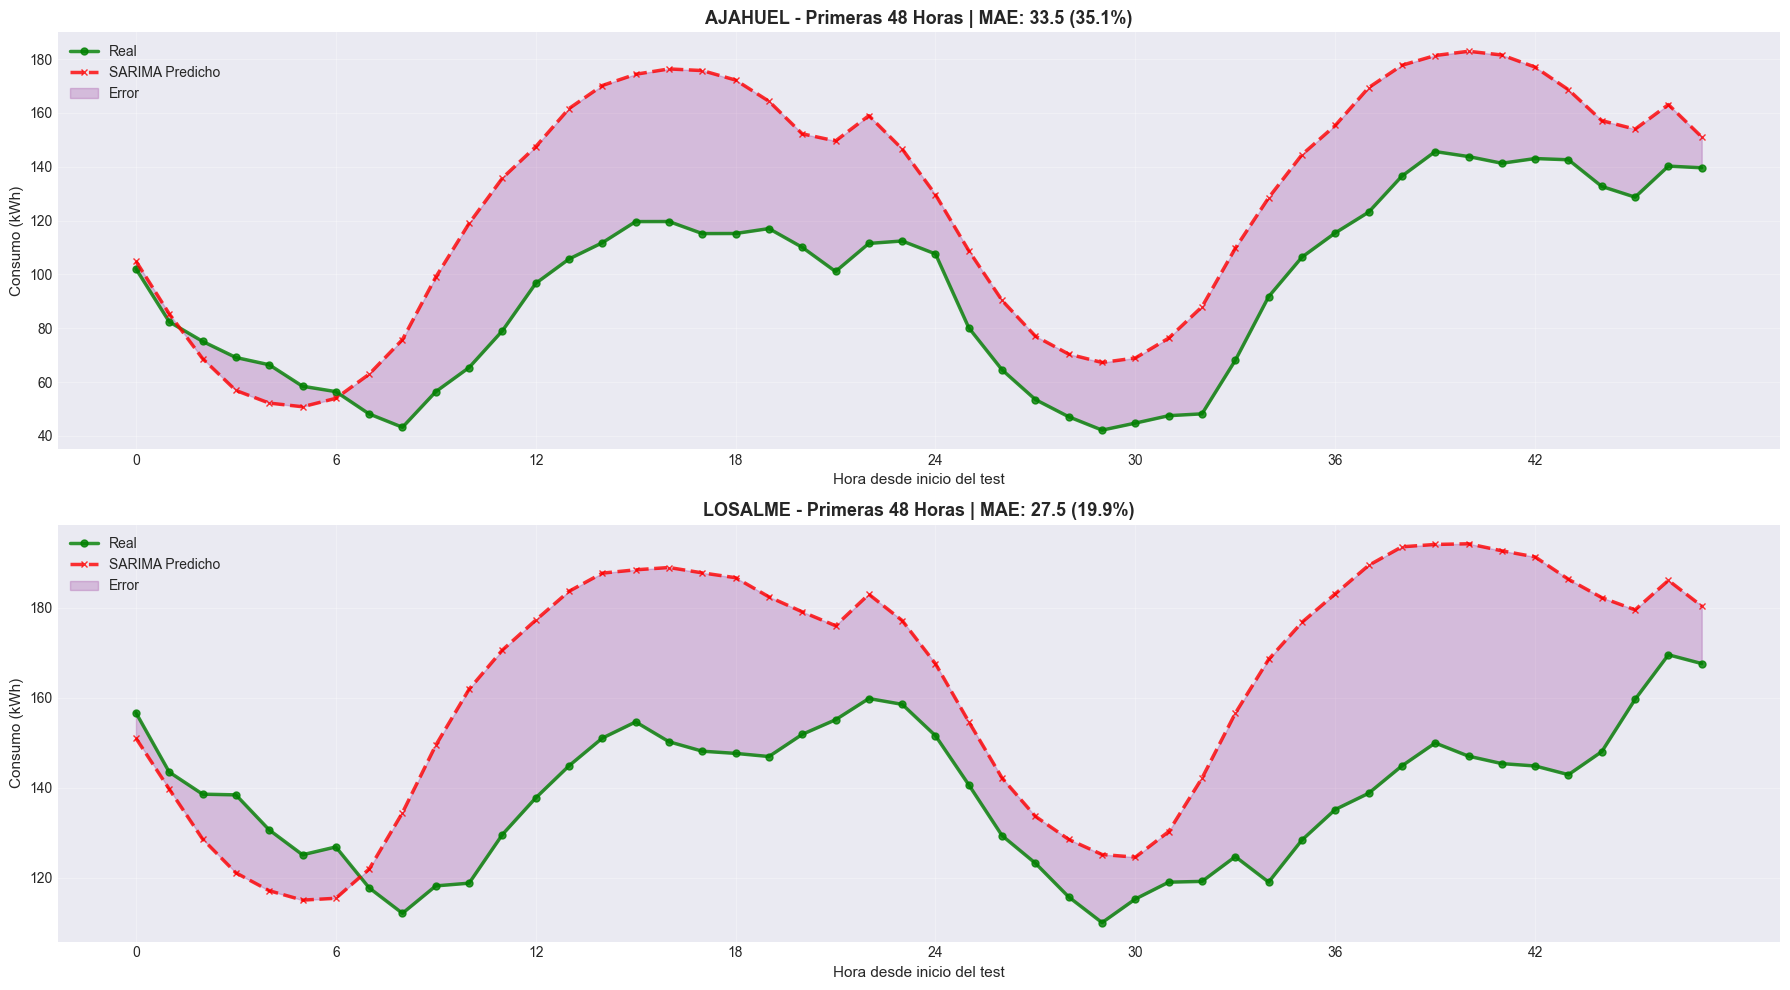


RESUMEN DE MÉTRICAS POR SUBESTACIÓN

Métricas por subestación (ordenadas por MAE):
Subestación  N_muestras  N_válidas  Validez (%)        MAE       RMSE        R²  MAPE (%)   Estrategia
    LOSALME        8759       8759        100.0  79.297408 100.524974 -0.785426 62.614341 get_forecast
    AJAHUEL        8759       8759        100.0 105.771919 131.024754 -0.950648 48.685287 get_forecast

✓ Gráfico guardado: 27_sarima_metricas_comparacion_subestaciones.png


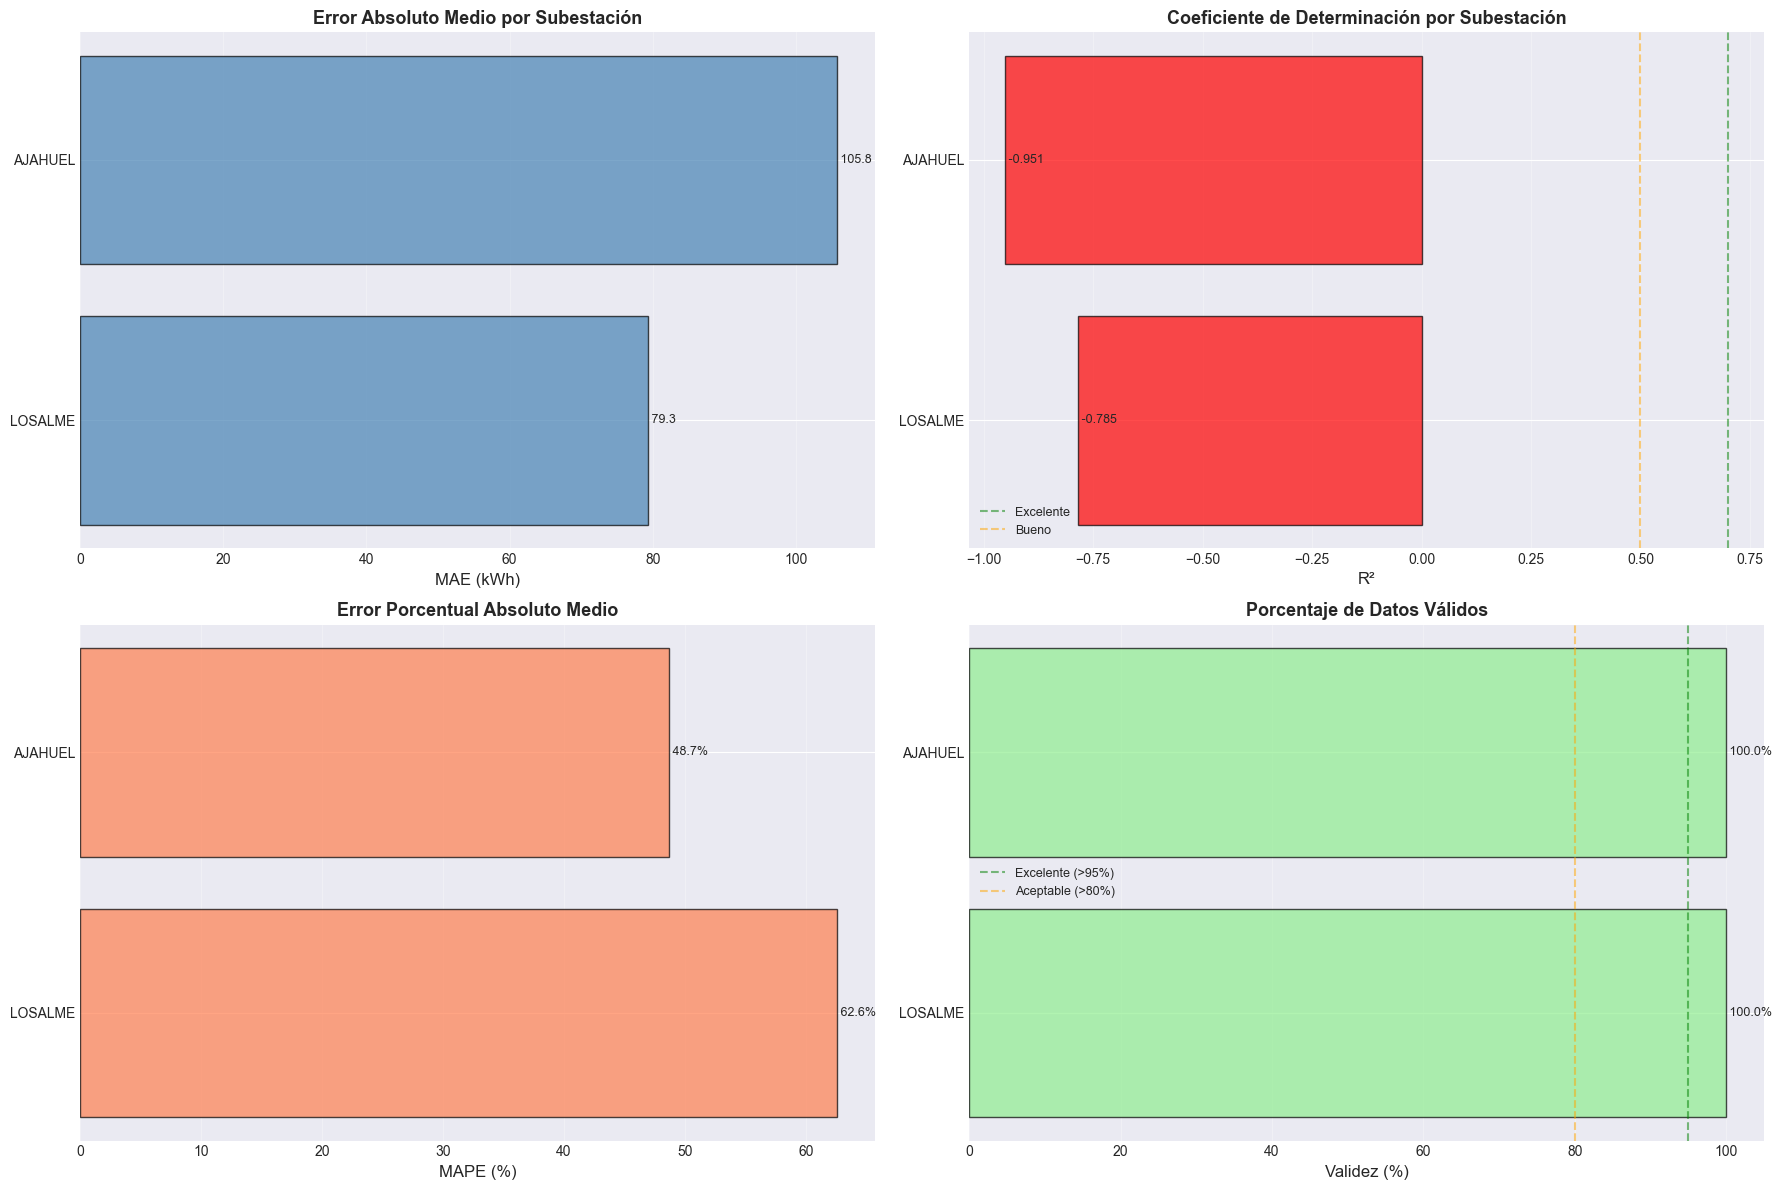


GUARDAR PREDICCIONES POR SUBESTACIÓN
✓ Predicciones guardadas: predicciones_sarima_por_subestacion.csv
  Total registros: 17,518
  Subestaciones: 2

Resumen por estrategia de predicción:
  get_forecast: 17,518 registros

Preview:


fecha subestacion  consumo_real  consumo_predicho_sarima  \
0 2022-01-01 00:00:00     AJAHUEL    102.093131               104.948404   
1 2022-01-01 01:00:00     AJAHUEL     82.379086                85.344241   
2 2022-01-01 02:00:00     AJAHUEL     75.126780                68.731587   
3 2022-01-01 03:00:00     AJAHUEL     69.140084                56.891600   
4 2022-01-01 04:00:00     AJAHUEL     66.442176                52.199647   
5 2022-01-01 05:00:00     AJAHUEL     58.462154                50.841251   
6 2022-01-01 06:00:00     AJAHUEL     56.457147                53.963905   
7 2022-01-01 07:00:00     AJAHUEL     48.162715                62.936295   
8 2022-01-01 08:00:00     AJAHUEL     43.210797                75.785551   
9 2022-01-01 09:00:00     AJAHUEL     56.440157                99.004517   

       error  error_abs estrategia_prediccion  
0  -2.855273   2.855273          get_forecast  
1  -2.965155   2.965155          get_forecast  
2   6.395193   6.395193          get_forecast  
3  12.248484  12.248484          get_forecast  
4  14.242529  14.242529          get_forecast  
5   7.620903   7.620903          get_forecast  
6   2.493242   2.493242          get_forecast  
7 -14.773580  14.773580          get_forecast  
8 -32.574754  32.574754          get_forecast  
9 -42.564360  42.564360          get_forecast


📋 RESUMEN FINAL - ANÁLISIS POR SUBESTACIÓN

✅ Subestaciones procesadas: 2/2

📊 Estadísticas generales:
  MAE promedio: 92.53 kWh
  R² promedio: -0.8680
  Validez promedio: 100.0%

🏆 Mejor subestación (menor MAE):
  LOSALME: MAE=79.30, R²=-0.7854

📁 Archivos generados:
  ✓ 24_sarima_predicciones_por_subestacion.png
  ✓ 25_sarima_zoom_7dias_por_subestacion.png
  ✓ 26_sarima_primeras_48h_por_subestacion.png
  ✓ 27_sarima_metricas_comparacion_subestaciones.png
  ✓ predicciones_sarima_por_subestacion.csv


In [24]:
# %%
# Visualización: Serie completa por subestación (CON CORRECCIONES)
print('\n' + '='*60)
print('GRÁFICOS: SERIE COMPLETA POR SUBESTACIÓN')
print('='*60)

if len(predicciones_por_sub) > 0:
    fig, axes = plt.subplots(len(predicciones_por_sub), 1, 
                             figsize=(18, 5*len(predicciones_por_sub)))

    if len(predicciones_por_sub) == 1:
        axes = [axes]

    for idx, (sub, datos) in enumerate(predicciones_por_sub.items()):
        ts_real = datos['real']
        ts_pred = datos['pred']
        estrategia = datos['estrategia']
        
        # Crear máscara de valores válidos
        mask_valido = ~(ts_real.isna() | ts_pred.isna() | 
                       np.isinf(ts_real) | np.isinf(ts_pred))
        
        ts_real_clean = ts_real[mask_valido]
        ts_pred_clean = ts_pred[mask_valido]
        
        if len(ts_real_clean) == 0:
            print(f'⚠ {sub}: No hay datos válidos para graficar')
            axes[idx].text(0.5, 0.5, f'{sub}: Sin datos válidos', 
                          ha='center', va='center', fontsize=14)
            axes[idx].set_xlim(0, 1)
            axes[idx].set_ylim(0, 1)
            continue
        
        # Gráfico de toda la serie test
        axes[idx].plot(ts_real_clean.index, ts_real_clean.values, 
                       label='Real', linewidth=1.5, color='green', alpha=0.8)
        axes[idx].plot(ts_pred_clean.index, ts_pred_clean.values, 
                       label='SARIMA Predicho', linewidth=1.5, color='red', 
                       linestyle='--', alpha=0.8)
        
        # Calcular métricas
        try:
            mae = mean_absolute_error(ts_real_clean, ts_pred_clean)
            r2 = r2_score(ts_real_clean, ts_pred_clean)
            rmse = np.sqrt(mean_squared_error(ts_real_clean, ts_pred_clean))
            
            # Añadir info de validez
            pct_valido = len(ts_real_clean) / len(ts_real) * 100
            
            title = f'{sub} | MAE: {mae:,.1f} | R²: {r2:.3f} | RMSE: {rmse:,.1f}\n'
            title += f'Datos válidos: {pct_valido:.1f}% | Estrategia: {estrategia}'
            
        except Exception as e:
            title = f'{sub} | Error calculando métricas: {str(e)[:50]}'
        
        axes[idx].set_ylabel('Consumo (kWh)', fontsize=11)
        axes[idx].set_title(title, fontsize=12, fontweight='bold')
        axes[idx].legend(loc='best', fontsize=10)
        axes[idx].grid(True, alpha=0.3)
        axes[idx].tick_params(axis='x', rotation=45)

    axes[-1].set_xlabel('Fecha', fontsize=12)
    plt.tight_layout()
    plt.savefig('24_sarima_predicciones_por_subestacion.png', dpi=200, bbox_inches='tight')
    print('✓ Gráfico guardado: 24_sarima_predicciones_por_subestacion.png')
    plt.show()
else:
    print('⚠ No hay predicciones para graficar')

# %%
# Visualización: Zoom primeros 7 días por subestación (CON CORRECCIONES)
print('\n' + '='*60)
print('GRÁFICOS: ZOOM PRIMEROS 7 DÍAS POR SUBESTACIÓN')
print('='*60)

dias_mostrar = 7

if len(predicciones_por_sub) > 0:
    fig, axes = plt.subplots(len(predicciones_por_sub), 1, 
                             figsize=(18, 5*len(predicciones_por_sub)))

    if len(predicciones_por_sub) == 1:
        axes = [axes]

    for idx, (sub, datos) in enumerate(predicciones_por_sub.items()):
        ts_real = datos['real']
        ts_pred = datos['pred']
        
        # Limpiar datos primero
        mask_valido = ~(ts_real.isna() | ts_pred.isna() | 
                       np.isinf(ts_real) | np.isinf(ts_pred))
        
        ts_real_clean = ts_real[mask_valido]
        ts_pred_clean = ts_pred[mask_valido]
        
        if len(ts_real_clean) == 0:
            print(f'⚠ {sub}: No hay datos válidos')
            axes[idx].text(0.5, 0.5, f'{sub}: Sin datos válidos', 
                          ha='center', va='center', fontsize=14)
            axes[idx].set_xlim(0, 1)
            axes[idx].set_ylim(0, 1)
            continue
        
        # Máscara para primeros días
        fecha_limite = ts_real_clean.index.min() + pd.Timedelta(days=dias_mostrar)
        mask_zoom = ts_real_clean.index < fecha_limite
        
        ts_real_zoom = ts_real_clean[mask_zoom]
        ts_pred_zoom = ts_pred_clean[mask_zoom]
        
        if len(ts_real_zoom) == 0:
            print(f'⚠ {sub}: No hay suficientes datos para zoom de {dias_mostrar} días')
            axes[idx].text(0.5, 0.5, f'{sub}: Datos insuficientes para zoom', 
                          ha='center', va='center', fontsize=14)
            axes[idx].set_xlim(0, 1)
            axes[idx].set_ylim(0, 1)
            continue
        
        # Gráfico con markers más visibles
        axes[idx].plot(ts_real_zoom.index, ts_real_zoom.values,
                       label='Real', linewidth=2, color='green', 
                       marker='o', markersize=4, alpha=0.8)
        axes[idx].plot(ts_pred_zoom.index, ts_pred_zoom.values,
                       label='SARIMA Predicho', linewidth=2, color='red', 
                       marker='x', markersize=4, linestyle='--', alpha=0.8)
        
        # Calcular error promedio en este período
        mae_zoom = mean_absolute_error(ts_real_zoom, ts_pred_zoom)
        
        axes[idx].set_ylabel('Consumo (kWh)', fontsize=11)
        axes[idx].set_title(f'{sub} - Primeros {dias_mostrar} Días | MAE: {mae_zoom:,.1f} kWh', 
                           fontsize=13, fontweight='bold')
        axes[idx].legend(loc='best', fontsize=10)
        axes[idx].grid(True, alpha=0.3)
        axes[idx].tick_params(axis='x', rotation=45)

    axes[-1].set_xlabel('Fecha y Hora', fontsize=12)
    plt.tight_layout()
    plt.savefig('25_sarima_zoom_7dias_por_subestacion.png', dpi=200, bbox_inches='tight')
    print('✓ Gráfico guardado: 25_sarima_zoom_7dias_por_subestacion.png')
    plt.show()
else:
    print('⚠ No hay predicciones para graficar')

# %%
# Visualización: Comparación primeras 48 horas (CON CORRECCIONES)
print('\n' + '='*60)
print('GRÁFICOS: COMPARACIÓN PRIMERAS 48 HORAS')
print('='*60)

horas_mostrar = 48

if len(predicciones_por_sub) > 0:
    fig, axes = plt.subplots(len(predicciones_por_sub), 1, 
                             figsize=(18, 5*len(predicciones_por_sub)))

    if len(predicciones_por_sub) == 1:
        axes = [axes]

    for idx, (sub, datos) in enumerate(predicciones_por_sub.items()):
        ts_real = datos['real']
        ts_pred = datos['pred']
        
        # Limpiar datos
        mask_valido = ~(ts_real.isna() | ts_pred.isna() | 
                       np.isinf(ts_real) | np.isinf(ts_pred))
        
        ts_real_clean = ts_real[mask_valido]
        ts_pred_clean = ts_pred[mask_valido]
        
        if len(ts_real_clean) == 0:
            print(f'⚠ {sub}: No hay datos válidos')
            axes[idx].text(0.5, 0.5, f'{sub}: Sin datos válidos', 
                          ha='center', va='center', fontsize=14)
            axes[idx].set_xlim(0, 1)
            axes[idx].set_ylim(0, 1)
            continue
        
        # Tomar primeras horas disponibles
        n_horas_disponibles = min(horas_mostrar, len(ts_real_clean))
        ts_real_48h = ts_real_clean.iloc[:n_horas_disponibles]
        ts_pred_48h = ts_pred_clean.iloc[:n_horas_disponibles]
        
        if len(ts_real_48h) < 10:
            print(f'⚠ {sub}: Menos de 10 horas disponibles ({len(ts_real_48h)})')
            axes[idx].text(0.5, 0.5, f'{sub}: Datos insuficientes (<10h)', 
                          ha='center', va='center', fontsize=14)
            axes[idx].set_xlim(0, 1)
            axes[idx].set_ylim(0, 1)
            continue
        
        # Crear índice numérico para mejor visualización
        x = range(len(ts_real_48h))
        
        axes[idx].plot(x, ts_real_48h.values,
                       label='Real', linewidth=2.5, color='green', 
                       marker='o', markersize=5, alpha=0.8)
        axes[idx].plot(x, ts_pred_48h.values,
                       label='SARIMA Predicho', linewidth=2.5, color='red', 
                       marker='x', markersize=5, linestyle='--', alpha=0.8)
        
        # Sombrear diferencias
        axes[idx].fill_between(x, ts_real_48h.values, ts_pred_48h.values, 
                               alpha=0.2, color='purple', label='Error')
        
        # Calcular métricas
        mae_48h = mean_absolute_error(ts_real_48h, ts_pred_48h)
        error_pct = (mae_48h / ts_real_48h.mean()) * 100
        
        axes[idx].set_ylabel('Consumo (kWh)', fontsize=11)
        axes[idx].set_xlabel('Hora desde inicio del test', fontsize=11)
        axes[idx].set_title(f'{sub} - Primeras {n_horas_disponibles} Horas | MAE: {mae_48h:,.1f} ({error_pct:.1f}%)', 
                           fontsize=13, fontweight='bold')
        axes[idx].legend(loc='best', fontsize=10)
        axes[idx].grid(True, alpha=0.3)
        
        # Marcar cada 6 horas
        tick_interval = max(1, n_horas_disponibles // 8)
        axes[idx].set_xticks(range(0, n_horas_disponibles, tick_interval))

    plt.tight_layout()
    plt.savefig('26_sarima_primeras_48h_por_subestacion.png', dpi=200, bbox_inches='tight')
    print('✓ Gráfico guardado: 26_sarima_primeras_48h_por_subestacion.png')
    plt.show()
else:
    print('⚠ No hay predicciones para graficar')

# %%
# Tabla resumen de métricas por subestación (CON CORRECCIONES)
print('\n' + '='*60)
print('RESUMEN DE MÉTRICAS POR SUBESTACIÓN')
print('='*60)

metricas_resumen = []

for sub, datos in predicciones_por_sub.items():
    ts_real = datos['real']
    ts_pred = datos['pred']
    estrategia = datos['estrategia']
    
    # Limpiar datos
    mask_valido = ~(ts_real.isna() | ts_pred.isna() | 
                   np.isinf(ts_real) | np.isinf(ts_pred))
    
    ts_real_clean = ts_real[mask_valido]
    ts_pred_clean = ts_pred[mask_valido]
    
    if len(ts_real_clean) == 0:
        print(f'⚠ {sub}: Sin datos válidos para métricas')
        continue
    
    try:
        mae = mean_absolute_error(ts_real_clean, ts_pred_clean)
        rmse = np.sqrt(mean_squared_error(ts_real_clean, ts_pred_clean))
        r2 = r2_score(ts_real_clean, ts_pred_clean)
        
        # MAPE (solo donde real != 0)
        mask_no_zero = ts_real_clean != 0
        if mask_no_zero.sum() > 0:
            mape = np.mean(np.abs((ts_real_clean[mask_no_zero] - ts_pred_clean[mask_no_zero]) / 
                                  ts_real_clean[mask_no_zero])) * 100
        else:
            mape = np.nan
        
        # Porcentaje de datos válidos
        pct_valido = (len(ts_real_clean) / len(ts_real)) * 100
        
        metricas_resumen.append({
            'Subestación': sub,
            'N_muestras': len(ts_real),
            'N_válidas': len(ts_real_clean),
            'Validez (%)': pct_valido,
            'MAE': mae,
            'RMSE': rmse,
            'R²': r2,
            'MAPE (%)': mape,
            'Estrategia': estrategia
        })
    except Exception as e:
        print(f'⚠ {sub}: Error calculando métricas: {str(e)[:50]}')
        continue

if len(metricas_resumen) > 0:
    df_metricas_sub = pd.DataFrame(metricas_resumen).sort_values('MAE')

    print('\nMétricas por subestación (ordenadas por MAE):')
    print(df_metricas_sub.to_string(index=False))

    # %%
    # Visualizar métricas (CON CORRECCIONES)
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    # 1. MAE
    axes[0, 0].barh(df_metricas_sub['Subestación'], df_metricas_sub['MAE'], 
                    color='steelblue', alpha=0.7, edgecolor='black')
    axes[0, 0].set_xlabel('MAE (kWh)', fontsize=12)
    axes[0, 0].set_title('Error Absoluto Medio por Subestación', fontsize=13, fontweight='bold')
    axes[0, 0].grid(axis='x', alpha=0.3)
    
    # Añadir valores
    for i, (sub, mae) in enumerate(zip(df_metricas_sub['Subestación'], df_metricas_sub['MAE'])):
        axes[0, 0].text(mae, i, f' {mae:.1f}', va='center', fontsize=9)

    # 2. R²
    colors_r2 = ['green' if x > 0.7 else 'orange' if x > 0.5 else 'red' 
                 for x in df_metricas_sub['R²']]
    axes[0, 1].barh(df_metricas_sub['Subestación'], df_metricas_sub['R²'], 
                    color=colors_r2, alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('R²', fontsize=12)
    axes[0, 1].set_title('Coeficiente de Determinación por Subestación', fontsize=13, fontweight='bold')
    axes[0, 1].axvline(x=0.7, color='green', linestyle='--', alpha=0.5, label='Excelente')
    axes[0, 1].axvline(x=0.5, color='orange', linestyle='--', alpha=0.5, label='Bueno')
    axes[0, 1].legend(fontsize=9)
    axes[0, 1].grid(axis='x', alpha=0.3)
    
    # Añadir valores
    for i, (sub, r2) in enumerate(zip(df_metricas_sub['Subestación'], df_metricas_sub['R²'])):
        axes[0, 1].text(r2, i, f' {r2:.3f}', va='center', fontsize=9)

    # 3. MAPE
    # Filtrar valores NaN en MAPE
    df_mape_valid = df_metricas_sub[~df_metricas_sub['MAPE (%)'].isna()]
    
    if len(df_mape_valid) > 0:
        axes[1, 0].barh(df_mape_valid['Subestación'], df_mape_valid['MAPE (%)'], 
                        color='coral', alpha=0.7, edgecolor='black')
        axes[1, 0].set_xlabel('MAPE (%)', fontsize=12)
        axes[1, 0].set_title('Error Porcentual Absoluto Medio', fontsize=13, fontweight='bold')
        axes[1, 0].grid(axis='x', alpha=0.3)
        
        # Añadir valores
        for i, (sub, mape) in enumerate(zip(df_mape_valid['Subestación'], df_mape_valid['MAPE (%)'])):
            axes[1, 0].text(mape, i, f' {mape:.1f}%', va='center', fontsize=9)
    else:
        axes[1, 0].text(0.5, 0.5, 'No hay valores MAPE válidos', 
                       ha='center', va='center', fontsize=14)
        axes[1, 0].set_xlim(0, 1)
        axes[1, 0].set_ylim(0, 1)

    # 4. Validez de datos
    axes[1, 1].barh(df_metricas_sub['Subestación'], df_metricas_sub['Validez (%)'], 
                    color='lightgreen', alpha=0.7, edgecolor='black')
    axes[1, 1].set_xlabel('Validez (%)', fontsize=12)
    axes[1, 1].set_title('Porcentaje de Datos Válidos', fontsize=13, fontweight='bold')
    axes[1, 1].axvline(x=95, color='green', linestyle='--', alpha=0.5, label='Excelente (>95%)')
    axes[1, 1].axvline(x=80, color='orange', linestyle='--', alpha=0.5, label='Aceptable (>80%)')
    axes[1, 1].legend(fontsize=9)
    axes[1, 1].grid(axis='x', alpha=0.3)
    axes[1, 1].set_xlim(0, 105)
    
    # Añadir valores
    for i, (sub, validez) in enumerate(zip(df_metricas_sub['Subestación'], df_metricas_sub['Validez (%)'])):
        axes[1, 1].text(validez, i, f' {validez:.1f}%', va='center', fontsize=9)

    plt.tight_layout()
    plt.savefig('27_sarima_metricas_comparacion_subestaciones.png', dpi=200, bbox_inches='tight')
    print('\n✓ Gráfico guardado: 27_sarima_metricas_comparacion_subestaciones.png')
    plt.show()

else:
    print('\n⚠ No hay métricas para visualizar')

# %%
# Guardar predicciones por subestación (CON CORRECCIONES)
print('\n' + '='*60)
print('GUARDAR PREDICCIONES POR SUBESTACIÓN')
print('='*60)

df_pred_todas = []

for sub, datos in predicciones_por_sub.items():
    ts_real = datos['real']
    ts_pred = datos['pred']
    estrategia = datos['estrategia']
    
    # Limpiar datos antes de guardar
    mask_valido = ~(ts_real.isna() | ts_pred.isna() | 
                   np.isinf(ts_real) | np.isinf(ts_pred))
    
    if mask_valido.sum() == 0:
        print(f'⚠ {sub}: Sin datos válidos para guardar')
        continue
    
    df_temp = pd.DataFrame({
        'fecha': ts_real[mask_valido].index,
        'subestacion': sub,
        'consumo_real': ts_real[mask_valido].values,
        'consumo_predicho_sarima': ts_pred[mask_valido].values,
        'error': ts_real[mask_valido].values - ts_pred[mask_valido].values,
        'error_abs': np.abs(ts_real[mask_valido].values - ts_pred[mask_valido].values),
        'estrategia_prediccion': estrategia
    })
    
    df_pred_todas.append(df_temp)

if len(df_pred_todas) > 0:
    df_predicciones_subs = pd.concat(df_pred_todas, ignore_index=True)

    output_path = 'predicciones_sarima_por_subestacion.csv'
    df_predicciones_subs.to_csv(output_path, index=False)
    print(f'✓ Predicciones guardadas: {output_path}')
    print(f'  Total registros: {len(df_predicciones_subs):,}')
    print(f'  Subestaciones: {df_predicciones_subs["subestacion"].nunique()}')
    
    # Resumen por estrategia
    print(f'\nResumen por estrategia de predicción:')
    estrategia_counts = df_predicciones_subs.groupby('estrategia_prediccion').size()
    for estrategia, count in estrategia_counts.items():
        print(f'  {estrategia}: {count:,} registros')

    print('\nPreview:')
    display(df_predicciones_subs.head(10))
else:
    print('⚠ No hay predicciones válidas para guardar')

# %%
# Resumen final
print('\n' + '='*60)
print('📋 RESUMEN FINAL - ANÁLISIS POR SUBESTACIÓN')
print('='*60)

print(f'\n✅ Subestaciones procesadas: {len(predicciones_por_sub)}/{len(top_subestaciones)}')

if len(metricas_resumen) > 0:
    print(f'\n📊 Estadísticas generales:')
    print(f'  MAE promedio: {df_metricas_sub["MAE"].mean():,.2f} kWh')
    print(f'  R² promedio: {df_metricas_sub["R²"].mean():.4f}')
    print(f'  Validez promedio: {df_metricas_sub["Validez (%)"].mean():.1f}%')
    
    print(f'\n🏆 Mejor subestación (menor MAE):')
    mejor = df_metricas_sub.iloc[0]
    print(f'  {mejor["Subestación"]}: MAE={mejor["MAE"]:.2f}, R²={mejor["R²"]:.4f}')
    
    print(f'\n📁 Archivos generados:')
    archivos = [
        '24_sarima_predicciones_por_subestacion.png',
        '25_sarima_zoom_7dias_por_subestacion.png',
        '26_sarima_primeras_48h_por_subestacion.png',
        '27_sarima_metricas_comparacion_subestaciones.png',
        'predicciones_sarima_por_subestacion.csv'
    ]
    
    for archivo in archivos:
        if os.path.exists(archivo):
            print(f'  ✓ {archivo}')
else:
    print('\n⚠ No se pudieron calcular métricas')

LTSM

PREPARACIÓN PARA MODELO LSTM

¿Qué es LSTM?
------------------------------------------------------------
LSTM = Long Short-Term Memory
  - Red neuronal recurrente especializada en secuencias
  - Captura dependencias temporales de largo plazo
  - Aprende patrones complejos no lineales
  - Requiere datos en formato 3D: (samples, timesteps, features)
✓ TensorFlow y Keras importados
  Versión TensorFlow: 2.20.0
  ℹ Usando CPU

CREACIÓN DE FEATURES PARA LSTM
Aplicando features a train y test...
✓ Train LSTM: (244391, 26)
✓ Test LSTM:  (61313, 26)

SELECCIÓN DE FEATURES

Features seleccionados: 23
   1. hour
   2. weekday
   3. month
   4. day
   5. is_weekend
   6. hour_sin
   7. hour_cos
   8. weekday_sin
   9. weekday_cos
  10. month_sin
  11. month_cos
  12. lag_1
  13. lag_2
  14. lag_3
  15. lag_6
  16. lag_12
  17. lag_24
  18. rolling_mean_6
  19. rolling_mean_12
  20. rolling_mean_24
  21. rolling_std_6
  22. rolling_std_12
  23. rolling_std_24

MANEJO DE VALORES NULOS

Nulos en tra

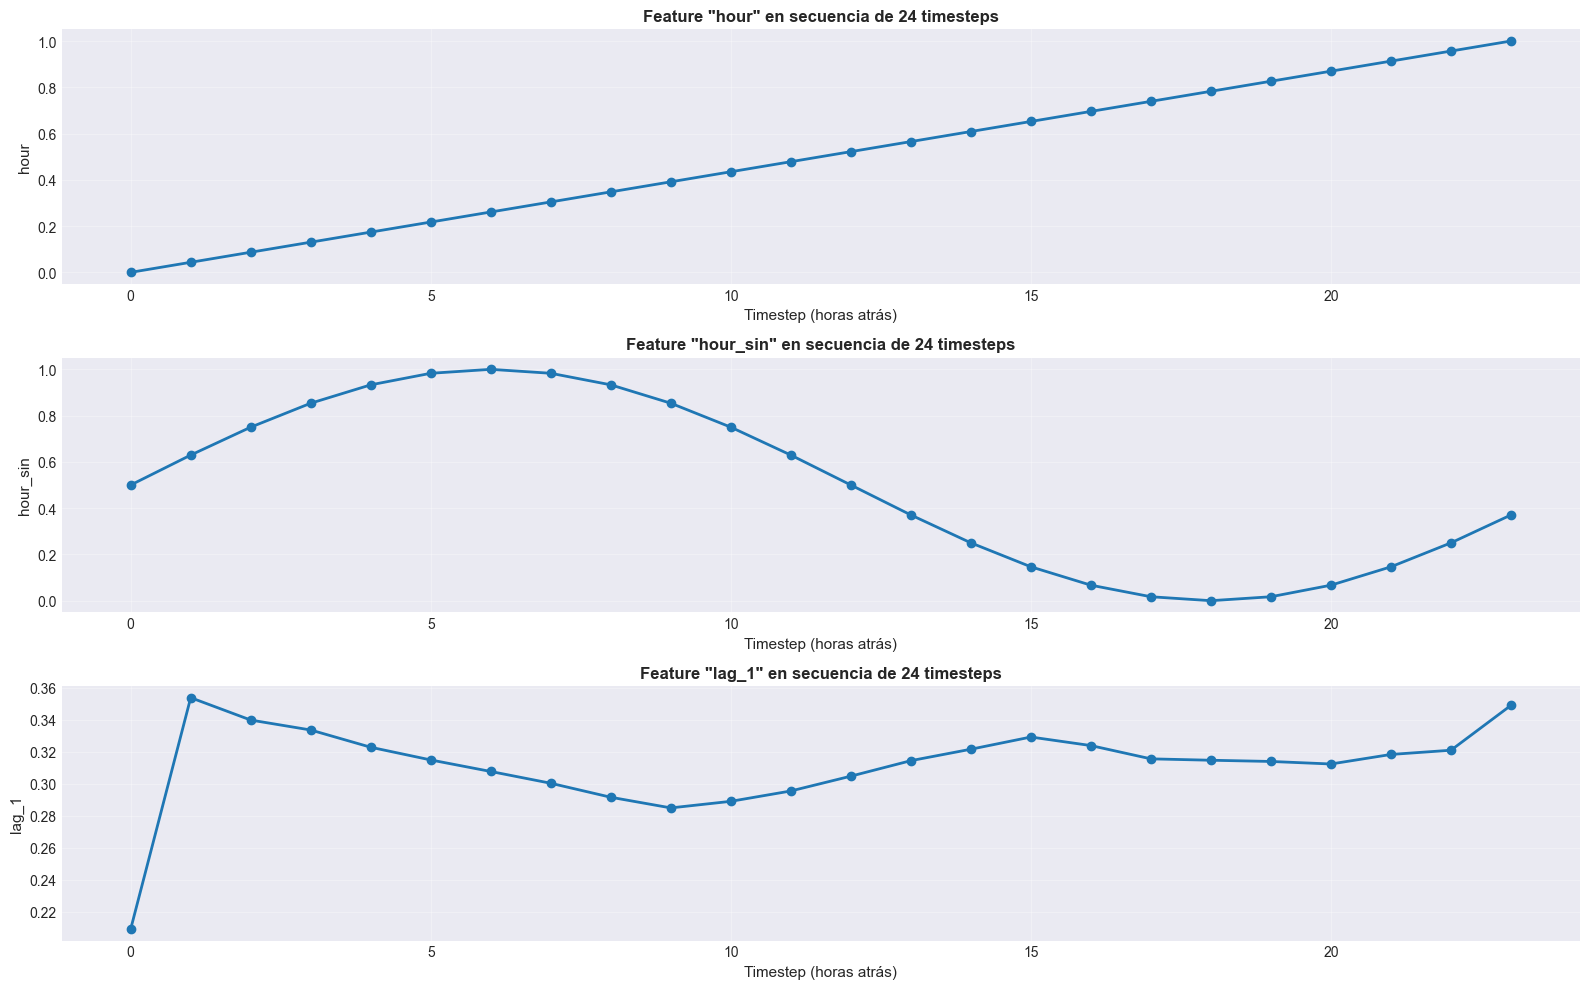


SPLIT DE VALIDACIÓN TEMPORAL

División temporal:
  Train: 195,493 secuencias (80%)
  Val:   48,874 secuencias (20%)
  Test:  61,289 secuencias

📋 RESUMEN DE PREPARACIÓN LSTM

📊 Estructura de datos:
  Lookback: 24 horas
  Features: 23
  Train:    (195493, 24, 23)
  Val:      (48874, 24, 23)
  Test:     (61289, 24, 23)

✅ Preparación completada:
  ✓ Features temporales creados
  ✓ Datos normalizados (MinMaxScaler)
  ✓ Secuencias 3D creadas
  ✓ Split temporal realizado
  ✓ Sin valores nulos

➡️ Listo para construir y entrenar modelo LSTM


In [26]:
# %% [markdown]
# ## Parte 6b: Preparación de Datos para LSTM

# %%
print('='*60)
print('PREPARACIÓN PARA MODELO LSTM')
print('='*60)

print('\n¿Qué es LSTM?')
print('-' * 60)
print('LSTM = Long Short-Term Memory')
print('  - Red neuronal recurrente especializada en secuencias')
print('  - Captura dependencias temporales de largo plazo')
print('  - Aprende patrones complejos no lineales')
print('  - Requiere datos en formato 3D: (samples, timesteps, features)')

# %%
# Importar librerías para LSTM
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    from sklearn.preprocessing import MinMaxScaler
    
    print('✓ TensorFlow y Keras importados')
    print(f'  Versión TensorFlow: {tf.__version__}')
    
    # Configurar GPU si está disponible
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f'  ✓ GPU disponible: {len(gpus)} dispositivo(s)')
    else:
        print(f'  ℹ Usando CPU')
        
except ImportError:
    print('⚠ TensorFlow no instalado')
    print('  Instalar con: pip install tensorflow')
    raise

# %%
# Crear features para LSTM
print('\n' + '='*60)
print('CREACIÓN DE FEATURES PARA LSTM')
print('='*60)

def preparar_datos_lstm(df, lookback=24):
    """
    Prepara datos para LSTM
    
    Parámetros:
    - df: DataFrame con fecha, subestacion, consumo
    - lookback: ventana temporal (horas hacia atrás)
    
    Retorna:
    - DataFrame con features temporales
    """
    df = df.copy()
    df = df.sort_values(['subestacion', 'fecha']).reset_index(drop=True)
    
    # Features temporales básicos
    df['hour'] = df['fecha'].dt.hour
    df['weekday'] = df['fecha'].dt.weekday
    df['month'] = df['fecha'].dt.month
    df['day'] = df['fecha'].dt.day
    df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)
    
    # Features cíclicos (importantes para LSTM)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # Lags importantes (LSTM aprenderá de estos)
    for lag in [1, 2, 3, 6, 12, 24]:
        df[f'lag_{lag}'] = df.groupby('subestacion')['consumo'].shift(lag)
    
    # Rolling statistics
    for window in [6, 12, 24]:
        df[f'rolling_mean_{window}'] = df.groupby('subestacion')['consumo'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
        df[f'rolling_std_{window}'] = df.groupby('subestacion')['consumo'].transform(
            lambda x: x.rolling(window=window, min_periods=1).std()
        )
    
    return df

print('Aplicando features a train y test...')
train_lstm = preparar_datos_lstm(train, lookback=24)
test_lstm = preparar_datos_lstm(test, lookback=24)

print(f'✓ Train LSTM: {train_lstm.shape}')
print(f'✓ Test LSTM:  {test_lstm.shape}')

# %%
# Seleccionar features para LSTM
print('\n' + '='*60)
print('SELECCIÓN DE FEATURES')
print('='*60)

# Features numéricos (excluir fecha, subestacion, consumo)
feature_cols_lstm = [
    'hour', 'weekday', 'month', 'day', 'is_weekend',
    'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos',
    'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12', 'lag_24',
    'rolling_mean_6', 'rolling_mean_12', 'rolling_mean_24',
    'rolling_std_6', 'rolling_std_12', 'rolling_std_24'
]

print(f'\nFeatures seleccionados: {len(feature_cols_lstm)}')
for i, feat in enumerate(feature_cols_lstm, 1):
    print(f'  {i:2d}. {feat}')

# %%
# Manejar valores nulos
print('\n' + '='*60)
print('MANEJO DE VALORES NULOS')
print('='*60)

print(f'\nNulos en train antes: {train_lstm[feature_cols_lstm].isnull().sum().sum()}')
print(f'Nulos en test antes:  {test_lstm[feature_cols_lstm].isnull().sum().sum()}')

# Rellenar lags y rolling con forward fill y luego con 0
for col in feature_cols_lstm:
    if 'lag' in col or 'rolling' in col:
        train_lstm[col] = train_lstm.groupby('subestacion')[col].fillna(method='ffill').fillna(0)
        test_lstm[col] = test_lstm.groupby('subestacion')[col].fillna(method='ffill').fillna(0)

# Rellenar cualquier nulo restante con 0
train_lstm[feature_cols_lstm] = train_lstm[feature_cols_lstm].fillna(0)
test_lstm[feature_cols_lstm] = test_lstm[feature_cols_lstm].fillna(0)

print(f'\nNulos en train después: {train_lstm[feature_cols_lstm].isnull().sum().sum()}')
print(f'Nulos en test después:  {test_lstm[feature_cols_lstm].isnull().sum().sum()}')
print('✓ Valores nulos eliminados')

# %%
# Normalización (CRÍTICO para LSTM)
print('\n' + '='*60)
print('NORMALIZACIÓN DE DATOS')
print('='*60)

print('\n¿Por qué normalizar?')
print('  ✓ LSTM es sensible a la escala de los datos')
print('  ✓ MinMaxScaler escala features a rango [0, 1]')
print('  ✓ Mejora convergencia y estabilidad del entrenamiento')

# Scaler para features
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Ajustar scalers SOLO con train (evitar data leakage)
X_train_scaled = scaler_X.fit_transform(train_lstm[feature_cols_lstm])
y_train_scaled = scaler_y.fit_transform(train_lstm[['consumo']])

# Transformar test con scalers ya ajustados
X_test_scaled = scaler_X.transform(test_lstm[feature_cols_lstm])
y_test_scaled = scaler_y.transform(test_lstm[['consumo']])

print(f'\n✓ Datos normalizados')
print(f'  X_train_scaled: {X_train_scaled.shape}')
print(f'  y_train_scaled: {y_train_scaled.shape}')
print(f'  X_test_scaled:  {X_test_scaled.shape}')
print(f'  y_test_scaled:  {y_test_scaled.shape}')

# %%
# Crear secuencias para LSTM
print('\n' + '='*60)
print('CREACIÓN DE SECUENCIAS TEMPORALES')
print('='*60)

def crear_secuencias(X, y, lookback=24):
    """
    Convierte datos a formato de secuencias para LSTM
    
    Parámetros:
    - X: features (2D array)
    - y: target (1D array)
    - lookback: número de timesteps hacia atrás
    
    Retorna:
    - X_seq: shape (samples, lookback, features)
    - y_seq: shape (samples,)
    """
    X_seq, y_seq = [], []
    
    for i in range(lookback, len(X)):
        X_seq.append(X[i-lookback:i])  # Ventana de lookback timesteps
        y_seq.append(y[i])              # Target actual
    
    return np.array(X_seq), np.array(y_seq)

# Definir lookback (ventana temporal)
lookback = 24  # 24 horas hacia atrás

print(f'\nCreando secuencias con lookback={lookback} horas...')

X_train_seq, y_train_seq = crear_secuencias(X_train_scaled, y_train_scaled, lookback)
X_test_seq, y_test_seq = crear_secuencias(X_test_scaled, y_test_scaled, lookback)

print(f'\n✓ Secuencias creadas')
print(f'  X_train_seq: {X_train_seq.shape} → (samples, timesteps, features)')
print(f'  y_train_seq: {y_train_seq.shape}')
print(f'  X_test_seq:  {X_test_seq.shape}')
print(f'  y_test_seq:  {y_test_seq.shape}')

print(f'\nInterpretación:')
print(f'  - {X_train_seq.shape[0]:,} secuencias de entrenamiento')
print(f'  - Cada secuencia tiene {X_train_seq.shape[1]} timesteps (horas pasadas)')
print(f'  - Cada timestep tiene {X_train_seq.shape[2]} features')

# %%
# Visualizar ejemplo de secuencia
print('\n' + '='*60)
print('EJEMPLO DE SECUENCIA')
print('='*60)

# Tomar primera secuencia como ejemplo
ejemplo_seq = X_train_seq[0]  # shape: (24, n_features)

fig, axes = plt.subplots(3, 1, figsize=(16, 10))

# Visualizar algunos features a través del tiempo
features_ejemplo = ['hour', 'hour_sin', 'lag_1']
indices_features = [feature_cols_lstm.index(f) for f in features_ejemplo]

for idx, (feat_name, feat_idx) in enumerate(zip(features_ejemplo, indices_features)):
    axes[idx].plot(range(lookback), ejemplo_seq[:, feat_idx], 
                  marker='o', linewidth=2, markersize=6)
    axes[idx].set_ylabel(feat_name, fontsize=11)
    axes[idx].set_title(f'Feature "{feat_name}" en secuencia de {lookback} timesteps', 
                       fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xlabel('Timestep (horas atrás)', fontsize=11)

plt.tight_layout()
plt.savefig('18_lstm_ejemplo_secuencia.png', dpi=200, bbox_inches='tight')
print('✓ Gráfico guardado: 18_lstm_ejemplo_secuencia.png')
plt.show()

# %%
# Split de validación temporal
print('\n' + '='*60)
print('SPLIT DE VALIDACIÓN TEMPORAL')
print('='*60)

# Usar últimos 20% de train como validación (manteniendo orden temporal)
split_idx = int(len(X_train_seq) * 0.8)

X_train_final = X_train_seq[:split_idx]
y_train_final = y_train_seq[:split_idx]

X_val = X_train_seq[split_idx:]
y_val = y_train_seq[split_idx:]

print(f'\nDivisión temporal:')
print(f'  Train: {X_train_final.shape[0]:,} secuencias ({(split_idx/len(X_train_seq)*100):.0f}%)')
print(f'  Val:   {X_val.shape[0]:,} secuencias ({((len(X_train_seq)-split_idx)/len(X_train_seq)*100):.0f}%)')
print(f'  Test:  {X_test_seq.shape[0]:,} secuencias')

# %%
# Resumen de preparación
print('\n' + '='*60)
print('📋 RESUMEN DE PREPARACIÓN LSTM')
print('='*60)

print(f'\n📊 Estructura de datos:')
print(f'  Lookback: {lookback} horas')
print(f'  Features: {len(feature_cols_lstm)}')
print(f'  Train:    {X_train_final.shape}')
print(f'  Val:      {X_val.shape}')
print(f'  Test:     {X_test_seq.shape}')

print(f'\n✅ Preparación completada:')
print(f'  ✓ Features temporales creados')
print(f'  ✓ Datos normalizados (MinMaxScaler)')
print(f'  ✓ Secuencias 3D creadas')
print(f'  ✓ Split temporal realizado')
print(f'  ✓ Sin valores nulos')

print(f'\n➡️ Listo para construir y entrenar modelo LSTM')

CONSTRUCCIÓN DEL MODELO LSTM

Arquitecturas disponibles:
  1. Simple:   1 LSTM(64) + Dense
  2. Medio:    2 LSTM(128,64) + Dense
  3. Profundo: 3 LSTM(256,128,64) + BatchNorm + Dense

Input shape: (24, 23) → (timesteps=24, features=23)

✓ Modelo creado: arquitectura "medio"

RESUMEN DE LA ARQUITECTURA


Model: "LSTM_medio"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 24, 128)        │        77,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,345 (505.25 KB)

 Trainable params: 129,345 (505.25 KB)

 Non-trainable params: 0 (0.00 B)


Total de parámetros entrenables: 129,345

COMPILACIÓN DEL MODELO
✓ Modelo compilado
  Optimizador: Adam (lr=0.001)
  Loss: MSE
  Métricas: MAE, MSE

CONFIGURACIÓN DE CALLBACKS
✓ Callbacks configurados:
  1. EarlyStopping: detiene si no mejora en 15 epochs
  2. ReduceLROnPlateau: reduce LR si se estanca

ENTRENAMIENTO DEL MODELO LSTM
⚠ Esto puede tardar varios minutos...

Parámetros de entrenamiento:
  Batch size: 64
  Epochs máximos: 100
  Train samples: 195,493
  Val samples: 48,874
Epoch 1/100
3055/3055 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - loss: 0.0022 - mae: 0.0291 - mse: 0.0022 - val_loss: 3.6569e-04 - val_mae: 0.0133 - val_mse: 3.6569e-04 - learning_rate: 0.0010
Epoch 2/100
3055/3055 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - loss: 8.5572e-04 - mae: 0.0184 - mse: 8.5572e-04 - val_loss: 2.2202e-04 - val_mae: 0.0098 - val_mse: 2.2202e-04 - learning_rate: 0.0010
Epoch 3/100
3055/3055 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - loss: 6.5692e-04 - mae: 0.0154 - mse: 6.5692e-04 - val_loss: 2.1587e-

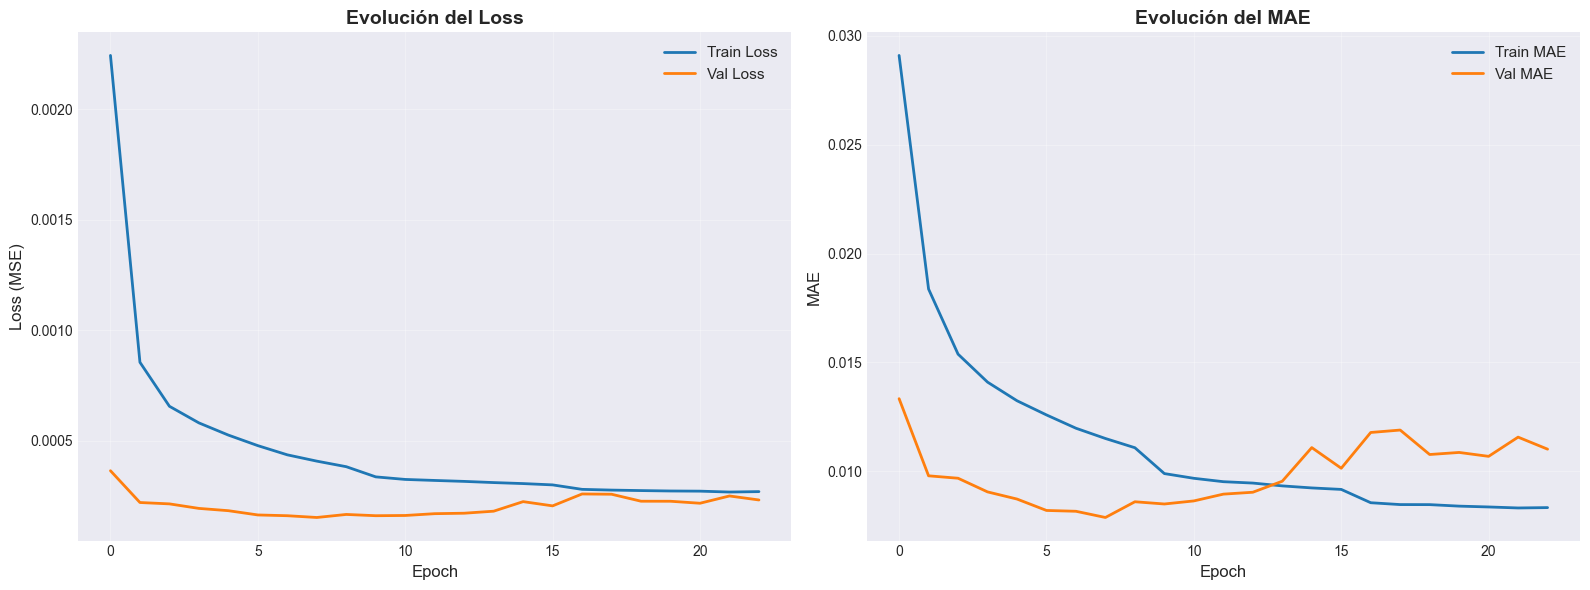


📊 Análisis del Entrenamiento:
  Epochs entrenados: 23
  Mejor epoch: 8
  Mejor val_loss: 0.000154
  Mejor val_mae: 0.007868

  Train loss final: 0.000271
  Val loss final: 0.000234
  Gap: 13.9%
  △ Ligero overfitting (gap 10-20%)

EVALUACIÓN EN VALIDACIÓN

Métricas en Validación:
  MSE:  139.64
  RMSE: 11.82
  MAE:  7.48
  R²:   0.9841

✓ Gráfico guardado: 20_lstm_validacion.png


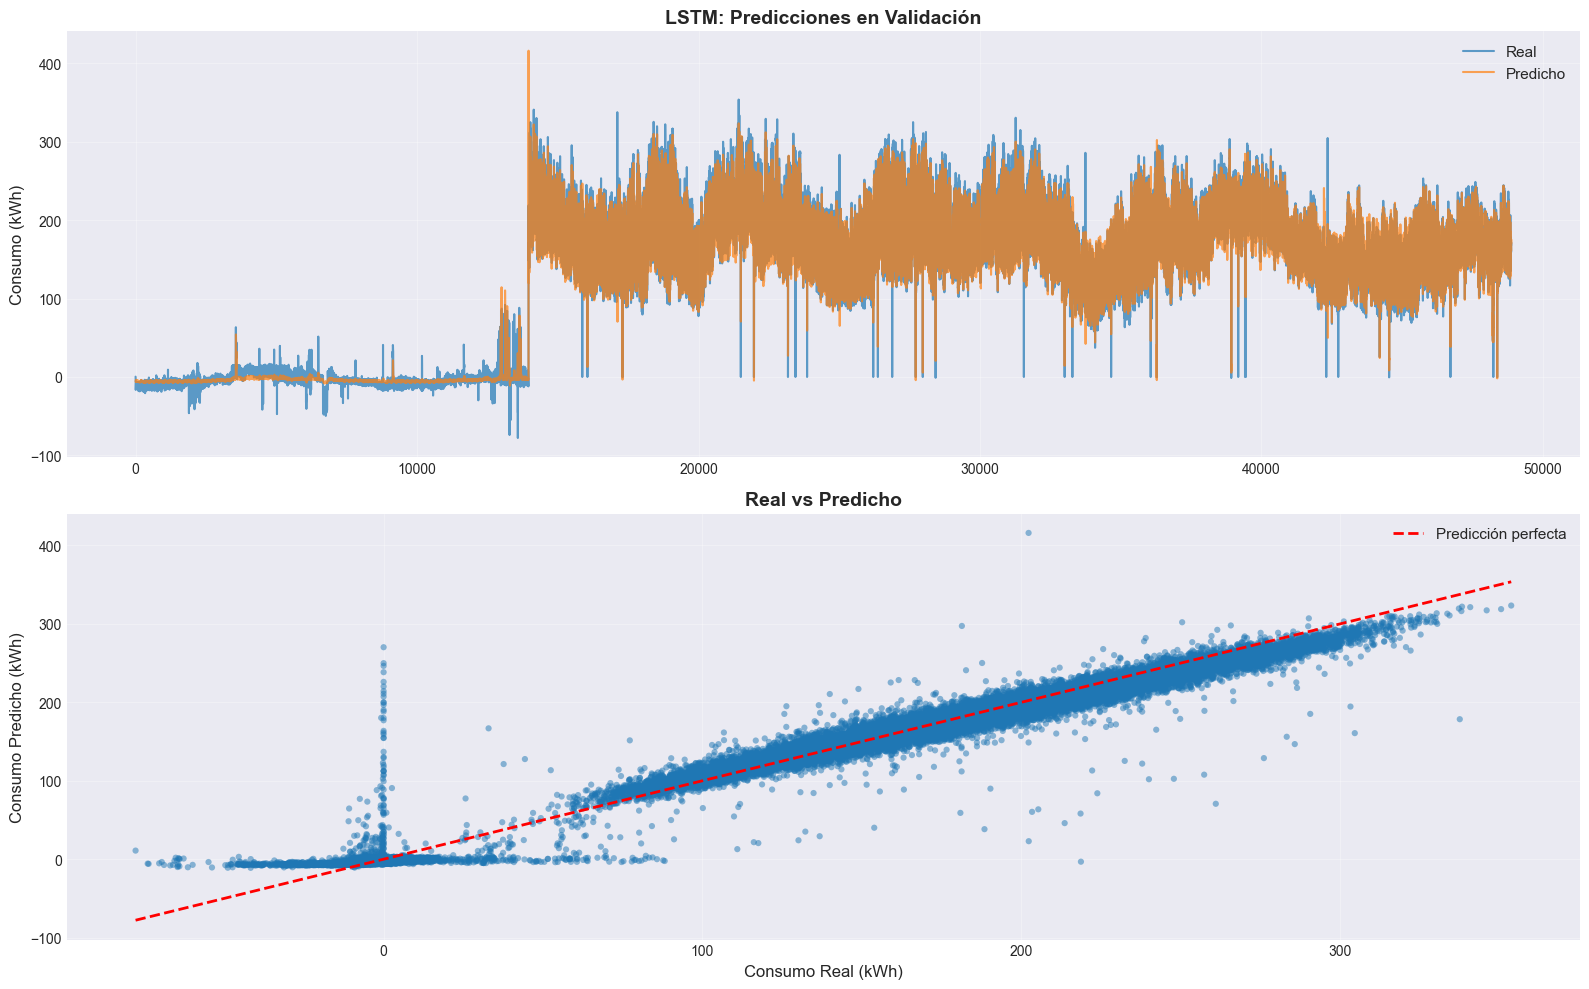


GUARDAR MODELO
✓ Modelo guardado: modelo_lstm_consumo.h5
✓ Scalers guardados: scaler_X.pkl, scaler_y.pkl

📋 RESUMEN DEL ENTRENAMIENTO LSTM

🏗️ Arquitectura: medio
   Parámetros: 129,345

⏱️ Entrenamiento:
   Tiempo: 14.5 minutos
   Epochs: 23
   Mejor epoch: 8

📊 Métricas (Validación):
   MAE:  7.48 kWh
   RMSE: 11.82 kWh
   R²:   0.9841

💾 Archivos guardados:
   ✓ modelo_lstm_consumo.h5
   ✓ scaler_X.pkl
   ✓ scaler_y.pkl

➡️ Listo para hacer predicciones en test


In [27]:
# %% [markdown]
# ## Parte 7b: Arquitectura y Entrenamiento LSTM

# %%
print('='*60)
print('CONSTRUCCIÓN DEL MODELO LSTM')
print('='*60)

# Configurar semilla para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

# %%
# Función para crear arquitectura LSTM
def crear_modelo_lstm(input_shape, arquitectura='simple'):
    """
    Crea modelo LSTM con diferentes arquitecturas
    
    Parámetros:
    - input_shape: (timesteps, features)
    - arquitectura: 'simple', 'medio', 'profundo'
    """
    model = Sequential(name=f'LSTM_{arquitectura}')
    
    if arquitectura == 'simple':
        # Arquitectura simple: 1 capa LSTM
        model.add(LSTM(64, input_shape=input_shape, name='lstm_1'))
        model.add(Dropout(0.2, name='dropout_1'))
        model.add(Dense(32, activation='relu', name='dense_1'))
        model.add(Dense(1, name='output'))
        
    elif arquitectura == 'medio':
        # Arquitectura media: 2 capas LSTM
        model.add(LSTM(128, return_sequences=True, input_shape=input_shape, name='lstm_1'))
        model.add(Dropout(0.2, name='dropout_1'))
        model.add(LSTM(64, name='lstm_2'))
        model.add(Dropout(0.2, name='dropout_2'))
        model.add(Dense(32, activation='relu', name='dense_1'))
        model.add(Dense(1, name='output'))
        
    elif arquitectura == 'profundo':
        # Arquitectura profunda: 3 capas LSTM con BatchNorm
        model.add(LSTM(256, return_sequences=True, input_shape=input_shape, name='lstm_1'))
        model.add(BatchNormalization(name='bn_1'))
        model.add(Dropout(0.3, name='dropout_1'))
        model.add(LSTM(128, return_sequences=True, name='lstm_2'))
        model.add(BatchNormalization(name='bn_2'))
        model.add(Dropout(0.3, name='dropout_2'))
        model.add(LSTM(64, name='lstm_3'))
        model.add(Dropout(0.2, name='dropout_3'))
        model.add(Dense(32, activation='relu', name='dense_1'))
        model.add(Dense(1, name='output'))
    
    return model

# %%
# Crear modelos con diferentes arquitecturas
print('\nArquitecturas disponibles:')
print('  1. Simple:   1 LSTM(64) + Dense')
print('  2. Medio:    2 LSTM(128,64) + Dense')
print('  3. Profundo: 3 LSTM(256,128,64) + BatchNorm + Dense')

input_shape = (X_train_final.shape[1], X_train_final.shape[2])
print(f'\nInput shape: {input_shape} → (timesteps={input_shape[0]}, features={input_shape[1]})')

# Probaremos arquitectura 'medio' (buen balance)
arquitectura_elegida = 'medio'
modelo_lstm = crear_modelo_lstm(input_shape, arquitectura=arquitectura_elegida)

print(f'\n✓ Modelo creado: arquitectura "{arquitectura_elegida}"')

# %%
# Ver resumen del modelo
print('\n' + '='*60)
print('RESUMEN DE LA ARQUITECTURA')
print('='*60)
modelo_lstm.summary()

# Contar parámetros
total_params = modelo_lstm.count_params()
print(f'\nTotal de parámetros entrenables: {total_params:,}')

# %%
# Compilar modelo
print('\n' + '='*60)
print('COMPILACIÓN DEL MODELO')
print('='*60)

# Optimizador
optimizer = keras.optimizers.Adam(learning_rate=0.001)

# Compilar
modelo_lstm.compile(
    optimizer=optimizer,
    loss='mse',           # Mean Squared Error
    metrics=['mae', 'mse'] # Mean Absolute Error, MSE
)

print('✓ Modelo compilado')
print(f'  Optimizador: Adam (lr=0.001)')
print(f'  Loss: MSE')
print(f'  Métricas: MAE, MSE')

# %%
# Callbacks para entrenamiento
print('\n' + '='*60)
print('CONFIGURACIÓN DE CALLBACKS')
print('='*60)

# Early Stopping: detener si no mejora
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau: reducir learning rate si se estanca
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=1e-6,
    verbose=1
)

callbacks = [early_stop, reduce_lr]

print('✓ Callbacks configurados:')
print('  1. EarlyStopping: detiene si no mejora en 15 epochs')
print('  2. ReduceLROnPlateau: reduce LR si se estanca')

# %%
# Entrenamiento
print('\n' + '='*60)
print('ENTRENAMIENTO DEL MODELO LSTM')
print('='*60)
print('⚠ Esto puede tardar varios minutos...')

batch_size = 64
epochs = 100

print(f'\nParámetros de entrenamiento:')
print(f'  Batch size: {batch_size}')
print(f'  Epochs máximos: {epochs}')
print(f'  Train samples: {len(X_train_final):,}')
print(f'  Val samples: {len(X_val):,}')

start_time = time.time()

# Entrenar
history = modelo_lstm.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)

elapsed = time.time() - start_time
print(f'\n✓ Entrenamiento completado en {elapsed/60:.1f} minutos')

# %%
# Visualizar curvas de aprendizaje
print('\n' + '='*60)
print('CURVAS DE APRENDIZAJE')
print('='*60)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('Evolución del Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Train MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Val MAE', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].set_title('Evolución del MAE', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('19_lstm_curvas_aprendizaje.png', dpi=200, bbox_inches='tight')
print('✓ Gráfico guardado: 19_lstm_curvas_aprendizaje.png')
plt.show()

# %%
# Analizar entrenamiento
print('\n📊 Análisis del Entrenamiento:')

epochs_trained = len(history.history['loss'])
best_epoch = np.argmin(history.history['val_loss']) + 1
best_val_loss = np.min(history.history['val_loss'])
best_val_mae = history.history['val_mae'][best_epoch - 1]

print(f'  Epochs entrenados: {epochs_trained}')
print(f'  Mejor epoch: {best_epoch}')
print(f'  Mejor val_loss: {best_val_loss:.6f}')
print(f'  Mejor val_mae: {best_val_mae:.6f}')

# Verificar overfitting
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
gap = abs(final_val_loss - final_train_loss) / final_train_loss * 100

print(f'\n  Train loss final: {final_train_loss:.6f}')
print(f'  Val loss final: {final_val_loss:.6f}')
print(f'  Gap: {gap:.1f}%')

if gap < 10:
    print('  ✓ Buen ajuste (gap < 10%)')
elif gap < 20:
    print('  △ Ligero overfitting (gap 10-20%)')
else:
    print('  ⚠ Overfitting detectado (gap > 20%)')

# %%
# Evaluación en conjunto de validación
print('\n' + '='*60)
print('EVALUACIÓN EN VALIDACIÓN')
print('='*60)

# Predicciones en validación (escaladas)
y_val_pred_scaled = modelo_lstm.predict(X_val, verbose=0)

# Desnormalizar predicciones y valores reales
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
y_val_real = scaler_y.inverse_transform(y_val)

# Calcular métricas
mse_val = mean_squared_error(y_val_real, y_val_pred)
mae_val = mean_absolute_error(y_val_real, y_val_pred)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_val_real, y_val_pred)

print(f'\nMétricas en Validación:')
print(f'  MSE:  {mse_val:,.2f}')
print(f'  RMSE: {rmse_val:,.2f}')
print(f'  MAE:  {mae_val:,.2f}')
print(f'  R²:   {r2_val:.4f}')

# %%
# Visualizar predicciones en validación
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Gráfico 1: Serie temporal
axes[0].plot(y_val_real, label='Real', linewidth=1.5, alpha=0.7)
axes[0].plot(y_val_pred, label='Predicho', linewidth=1.5, alpha=0.7)
axes[0].set_ylabel('Consumo (kWh)', fontsize=12)
axes[0].set_title('LSTM: Predicciones en Validación', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Gráfico 2: Scatter
axes[1].scatter(y_val_real, y_val_pred, alpha=0.5, s=20, edgecolors='none')
axes[1].plot([y_val_real.min(), y_val_real.max()], 
             [y_val_real.min(), y_val_real.max()], 
             'r--', lw=2, label='Predicción perfecta')
axes[1].set_xlabel('Consumo Real (kWh)', fontsize=12)
axes[1].set_ylabel('Consumo Predicho (kWh)', fontsize=12)
axes[1].set_title('Real vs Predicho', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('20_lstm_validacion.png', dpi=200, bbox_inches='tight')
print('\n✓ Gráfico guardado: 20_lstm_validacion.png')
plt.show()

# %%
# Guardar modelo entrenado
print('\n' + '='*60)
print('GUARDAR MODELO')
print('='*60)

modelo_path = 'modelo_lstm_consumo.h5'
modelo_lstm.save(modelo_path)
print(f'✓ Modelo guardado: {modelo_path}')

# Guardar scalers (importantes para predicciones futuras)
import joblib
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')
print(f'✓ Scalers guardados: scaler_X.pkl, scaler_y.pkl')

# %%
# Resumen del entrenamiento
print('\n' + '='*60)
print('📋 RESUMEN DEL ENTRENAMIENTO LSTM')
print('='*60)

print(f'\n🏗️ Arquitectura: {arquitectura_elegida}')
print(f'   Parámetros: {total_params:,}')

print(f'\n⏱️ Entrenamiento:')
print(f'   Tiempo: {elapsed/60:.1f} minutos')
print(f'   Epochs: {epochs_trained}')
print(f'   Mejor epoch: {best_epoch}')

print(f'\n📊 Métricas (Validación):')
print(f'   MAE:  {mae_val:,.2f} kWh')
print(f'   RMSE: {rmse_val:,.2f} kWh')
print(f'   R²:   {r2_val:.4f}')

print(f'\n💾 Archivos guardados:')
print(f'   ✓ modelo_lstm_consumo.h5')
print(f'   ✓ scaler_X.pkl')
print(f'   ✓ scaler_y.pkl')

print(f'\n➡️ Listo para hacer predicciones en test')

PREDICCIONES EN CONJUNTO DE TEST

Generando predicciones en test...
1916/1916 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
✓ Predicciones generadas: 61,289 valores

MÉTRICAS EN TEST

Métricas del modelo LSTM en Test:
  MSE:  1,319.69
  RMSE: 36.33
  MAE:  19.57
  R²:   0.9757
  MAPE: inf%

📊 Comparación Validación vs Test:
  MAE:  Val=7.48 | Test=19.57 | Δ=12.09
  R²:   Val=0.9841 | Test=0.9757 | Δ=0.0084

  △ Hay diferencia entre val y test (revisar)

VISUALIZACIÓN DE PREDICCIONES
✓ Gráfico guardado: 21_lstm_predicciones_test.png


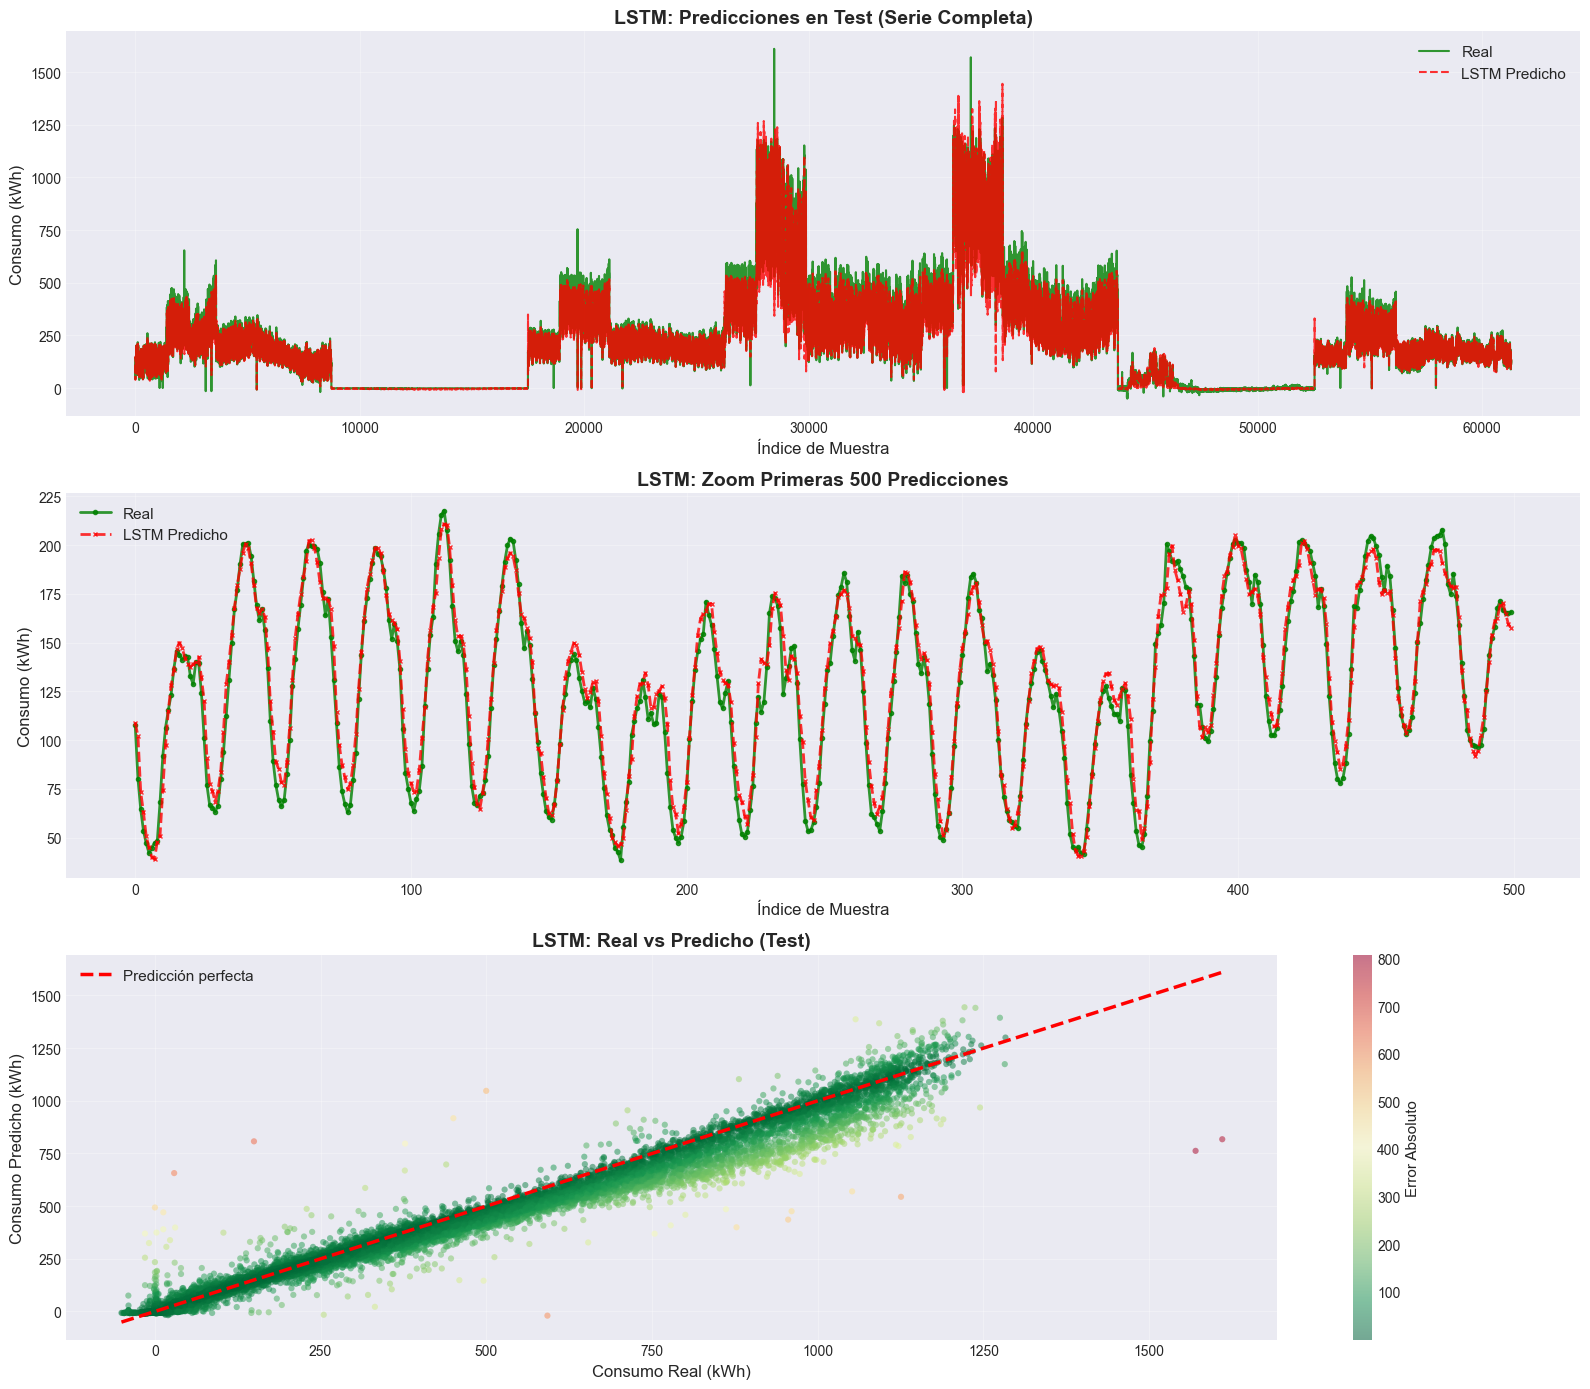


ANÁLISIS DE ERRORES EN TEST
✓ Gráfico guardado: 22_lstm_analisis_errores.png


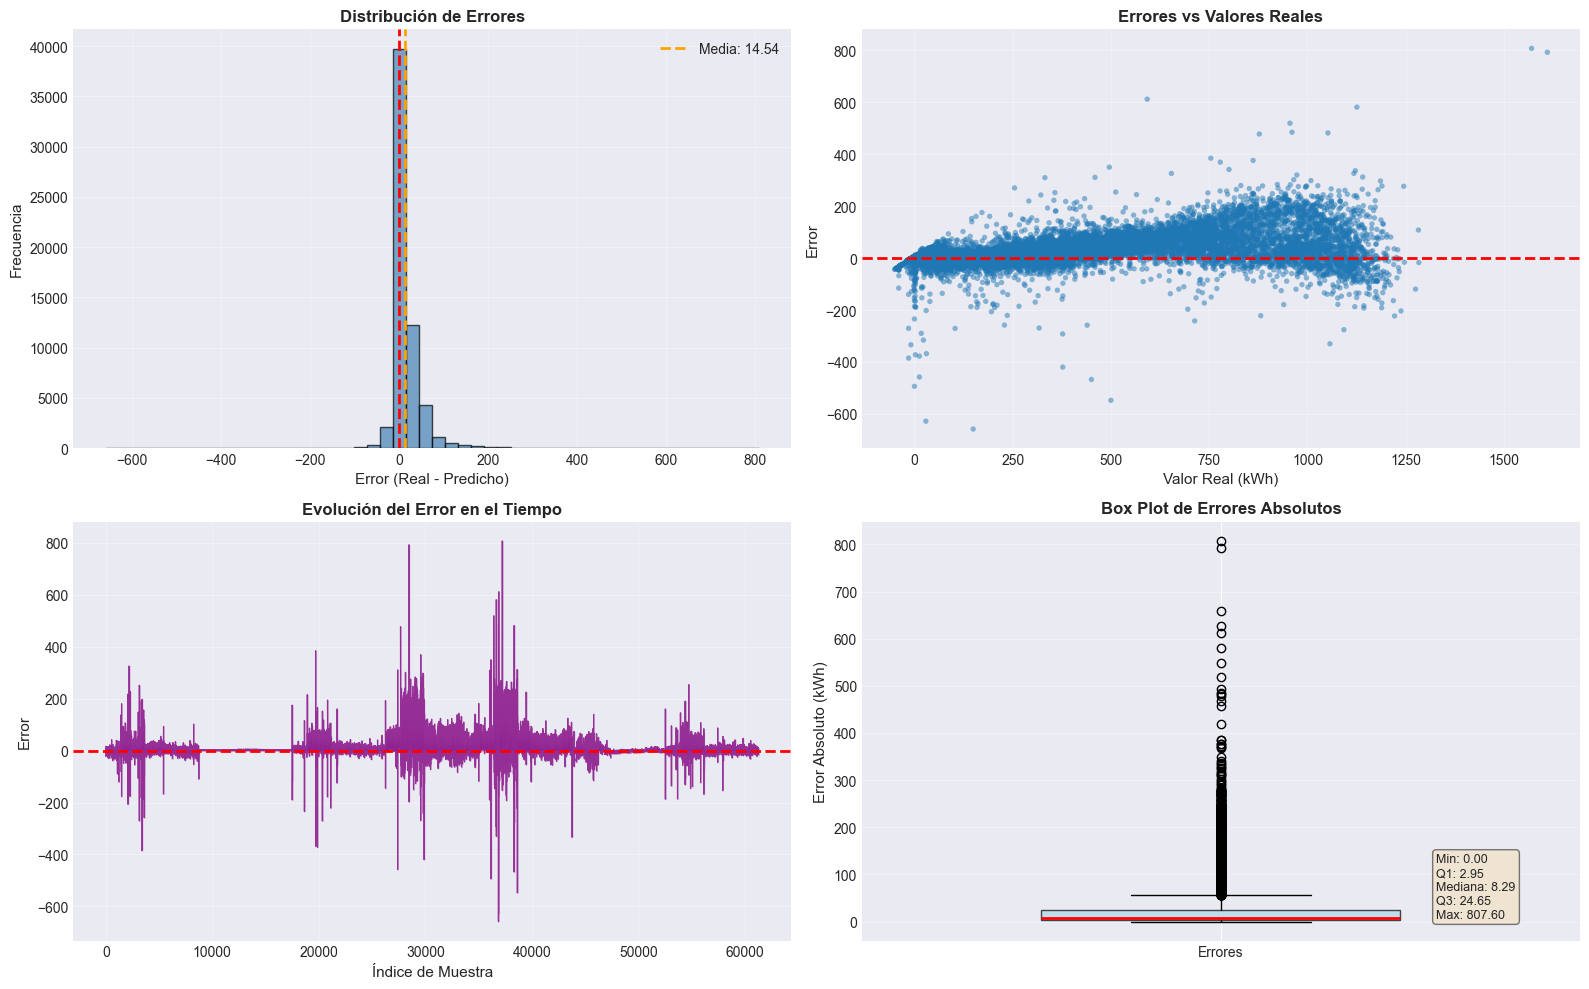


📊 Estadísticas Detalladas de Errores:
  Error medio: 14.54 kWh
  Error mediano: 4.58 kWh
  Error absoluto medio: 19.57 kWh
  Desv. estándar errores: 33.29 kWh
  Error máximo: 807.60 kWh
  Error mínimo: -658.20 kWh

  MAPE: inf%
  Errores dentro de ±10%: 58.4%
  Errores dentro de ±20%: 73.2%
  Errores dentro de ±30%: 76.5%

GUARDAR PREDICCIONES CON FECHAS

Verificación de dimensiones:
  test_lstm original: 61,313
  Después de lookback: 61,289
  Predicciones: 61,289
  ✓ Dimensiones coinciden

✓ Predicciones guardadas: predicciones_lstm.csv

Preview de predicciones:


fecha subestacion  consumo_real  consumo_predicho_lstm  \
0 2022-01-02 00:00:00     AJAHUEL    107.606628             108.997826   
1 2022-01-02 01:00:00     AJAHUEL     80.150942             102.092705   
2 2022-01-02 02:00:00     AJAHUEL     64.522861              73.389198   
3 2022-01-02 03:00:00     AJAHUEL     53.499480              62.965847   
4 2022-01-02 04:00:00     AJAHUEL     47.108195              50.733780   
5 2022-01-02 05:00:00     AJAHUEL     42.150013              45.015316   
6 2022-01-02 06:00:00     AJAHUEL     44.764585              40.038879   
7 2022-01-02 07:00:00     AJAHUEL     47.514916              38.944756   
8 2022-01-02 08:00:00     AJAHUEL     48.201944              48.002468   
9 2022-01-02 09:00:00     AJAHUEL     68.092886              51.128387   

       error  error_abs  error_pct  
0  -1.391198   1.391198  -1.292855  
1 -21.941763  21.941763 -27.375552  
2  -8.866337   8.866337 -13.741389  
3  -9.466367   9.466367 -17.694316  
4  -3.625585   3.625585  -7.696293  
5  -2.865303   2.865303  -6.797870  
6   4.725706   4.725706  10.556795  
7   8.570160   8.570160  18.036779  
8   0.199476   0.199476   0.413834  
9  16.964499  16.964499  24.913761


ANÁLISIS POR SUBESTACIÓN

Top 10 subestaciones por MAE (mejor desempeño):
                   mae       rmse         r2  n_samples
subestacion                                            
BUIN          2.515553   3.019493 -19.625263     8759.0
FLORIDA       7.290934  12.341551   0.832513     8759.0
LOSALME      10.600127  17.218987   0.947615     8759.0
AJAHUEL      12.614962  21.147333   0.949117     8735.0
CHENA        15.142834  23.851177   0.950013     8759.0
CNAVIA       42.837961  59.332014   0.935003     8759.0
ELSALTO      45.975620  65.124290   0.933608     8759.0

Bottom 5 subestaciones por MAE (peor desempeño):
                   mae       rmse        r2  n_samples
subestacion                                           
LOSALME      10.600127  17.218987  0.947615     8759.0
AJAHUEL      12.614962  21.147333  0.949117     8735.0
CHENA        15.142834  23.851177  0.950013     8759.0
CNAVIA       42.837961  59.332014  0.935003     8759.0
ELSALTO      45.975620  65.124290  0.9336

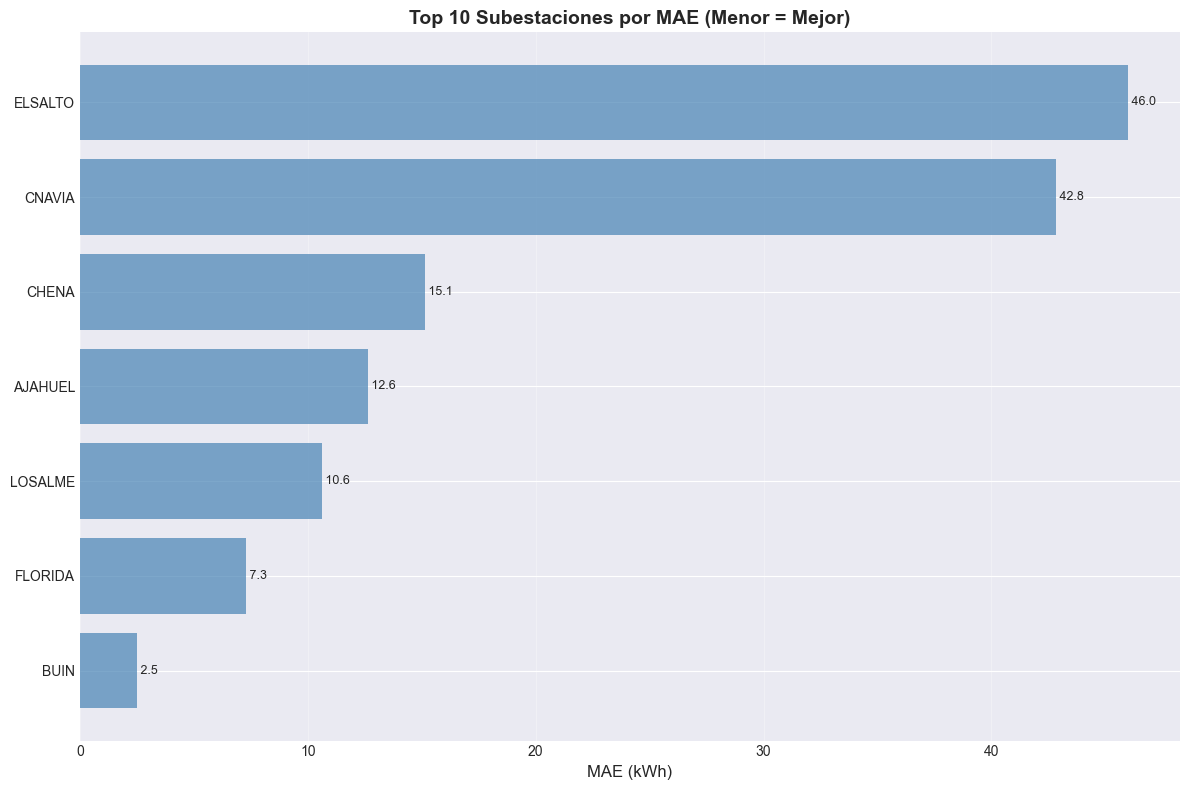


📋 RESUMEN MODELO LSTM

🏗️ Arquitectura:
   Tipo: medio
   Parámetros: 129,345
   Lookback: 24 horas
   Features: 23

📊 Métricas en Test:
   MAE:  19.57 kWh
   RMSE: 36.33 kWh
   R²:   0.9757
   MAPE: inf%

✅ Fortalezas:
   ✓ Captura patrones no lineales complejos
   ✓ Aprende dependencias de largo plazo
   ✓ Usa múltiples features (no solo serie univariada)
   ✓ Adaptable a cambios en patrones

⚠️ Limitaciones:
   △ Requiere muchos datos para entrenar
   △ Tiempo de entrenamiento mayor
   △ Menos interpretable que modelos estadísticos
   △ Necesita normalización y preprocesamiento cuidadoso

📁 Archivos generados:
   ✓ 18_lstm_ejemplo_secuencia.png
   ✓ 19_lstm_curvas_aprendizaje.png
   ✓ 20_lstm_validacion.png
   ✓ 21_lstm_predicciones_test.png
   ✓ 22_lstm_analisis_errores.png
   ✓ 23_lstm_mae_por_subestacion.png
   ✓ modelo_lstm_consumo.h5
   ✓ scaler_X.pkl
   ✓ scaler_y.pkl
   ✓ predicciones_lstm.csv


In [28]:
# %% [markdown]
# ## Parte 8b: Predicciones LSTM en Test

# %%
print('='*60)
print('PREDICCIONES EN CONJUNTO DE TEST')
print('='*60)

# Predicciones en test (datos ya escalados y en secuencias)
print('\nGenerando predicciones en test...')
y_test_pred_scaled = modelo_lstm.predict(X_test_seq, verbose=1)

# Desnormalizar predicciones
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
y_test_real = scaler_y.inverse_transform(y_test_seq)

print(f'✓ Predicciones generadas: {len(y_test_pred):,} valores')

# %%
# Calcular métricas en test
print('\n' + '='*60)
print('MÉTRICAS EN TEST')
print('='*60)

mse_test = mean_squared_error(y_test_real, y_test_pred)
mae_test = mean_absolute_error(y_test_real, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_real, y_test_pred)

# MAPE
mape_test = np.mean(np.abs((y_test_real - y_test_pred) / y_test_real)) * 100

print(f'\nMétricas del modelo LSTM en Test:')
print(f'  MSE:  {mse_test:,.2f}')
print(f'  RMSE: {rmse_test:,.2f}')
print(f'  MAE:  {mae_test:,.2f}')
print(f'  R²:   {r2_test:.4f}')
print(f'  MAPE: {mape_test:.2f}%')

# Comparar con validación
print(f'\n📊 Comparación Validación vs Test:')
print(f'  MAE:  Val={mae_val:,.2f} | Test={mae_test:,.2f} | Δ={abs(mae_test-mae_val):,.2f}')
print(f'  R²:   Val={r2_val:.4f} | Test={r2_test:.4f} | Δ={abs(r2_test-r2_val):.4f}')

if abs(mae_test - mae_val) / mae_val < 0.1:
    print('\n  ✓ Modelo generaliza bien (diferencia < 10%)')
else:
    print('\n  △ Hay diferencia entre val y test (revisar)')

# %%
# Visualización: Predicciones en Test
print('\n' + '='*60)
print('VISUALIZACIÓN DE PREDICCIONES')
print('='*60)

fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# Gráfico 1: Serie temporal completa
axes[0].plot(y_test_real, label='Real', linewidth=1.5, alpha=0.8, color='green')
axes[0].plot(y_test_pred, label='LSTM Predicho', linewidth=1.5, alpha=0.8, 
             color='red', linestyle='--')
axes[0].set_ylabel('Consumo (kWh)', fontsize=12)
axes[0].set_xlabel('Índice de Muestra', fontsize=12)
axes[0].set_title('LSTM: Predicciones en Test (Serie Completa)', 
                  fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Gráfico 2: Zoom primeras 500 muestras
zoom_samples = min(500, len(y_test_real))
axes[1].plot(range(zoom_samples), y_test_real[:zoom_samples], 
             label='Real', linewidth=2, alpha=0.8, color='green', marker='o', markersize=3)
axes[1].plot(range(zoom_samples), y_test_pred[:zoom_samples], 
             label='LSTM Predicho', linewidth=2, alpha=0.8, 
             color='red', marker='x', markersize=3, linestyle='--')
axes[1].set_ylabel('Consumo (kWh)', fontsize=12)
axes[1].set_xlabel('Índice de Muestra', fontsize=12)
axes[1].set_title(f'LSTM: Zoom Primeras {zoom_samples} Predicciones', 
                  fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

# Gráfico 3: Scatter Real vs Predicho
axes[2].scatter(y_test_real, y_test_pred, alpha=0.5, s=20, 
               c=np.abs(y_test_real - y_test_pred), cmap='RdYlGn_r', edgecolors='none')
axes[2].plot([y_test_real.min(), y_test_real.max()], 
            [y_test_real.min(), y_test_real.max()], 
            'r--', lw=2.5, label='Predicción perfecta')
axes[2].set_xlabel('Consumo Real (kWh)', fontsize=12)
axes[2].set_ylabel('Consumo Predicho (kWh)', fontsize=12)
axes[2].set_title('LSTM: Real vs Predicho (Test)', fontsize=14, fontweight='bold')
axes[2].legend(fontsize=11)
axes[2].grid(True, alpha=0.3)
cbar = plt.colorbar(axes[2].collections[0], ax=axes[2])
cbar.set_label('Error Absoluto', fontsize=11)

plt.tight_layout()
plt.savefig('21_lstm_predicciones_test.png', dpi=200, bbox_inches='tight')
print('✓ Gráfico guardado: 21_lstm_predicciones_test.png')
plt.show()

# %%
# Análisis de errores
print('\n' + '='*60)
print('ANÁLISIS DE ERRORES EN TEST')
print('='*60)

errores_lstm = y_test_real.flatten() - y_test_pred.flatten()
errores_abs_lstm = np.abs(errores_lstm)
errores_pct_lstm = (errores_lstm / y_test_real.flatten()) * 100

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Distribución de errores
axes[0, 0].hist(errores_lstm, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].axvline(x=errores_lstm.mean(), color='orange', linestyle='--', linewidth=2,
                   label=f'Media: {errores_lstm.mean():.2f}')
axes[0, 0].set_xlabel('Error (Real - Predicho)', fontsize=11)
axes[0, 0].set_ylabel('Frecuencia', fontsize=11)
axes[0, 0].set_title('Distribución de Errores', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Errores vs valores reales
axes[0, 1].scatter(y_test_real, errores_lstm, alpha=0.5, s=15, edgecolors='none')
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Valor Real (kWh)', fontsize=11)
axes[0, 1].set_ylabel('Error', fontsize=11)
axes[0, 1].set_title('Errores vs Valores Reales', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Errores en el tiempo
axes[1, 0].plot(errores_lstm, linewidth=0.8, alpha=0.7, color='purple')
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].fill_between(range(len(errores_lstm)), errores_lstm, 0, 
                        alpha=0.3, color='purple')
axes[1, 0].set_xlabel('Índice de Muestra', fontsize=11)
axes[1, 0].set_ylabel('Error', fontsize=11)
axes[1, 0].set_title('Evolución del Error en el Tiempo', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Box plot de errores absolutos
bp = axes[1, 1].boxplot([errores_abs_lstm], vert=True, widths=0.5, patch_artist=True,
                        boxprops=dict(facecolor='lightblue', alpha=0.7),
                        medianprops=dict(color='red', linewidth=2))
axes[1, 1].set_ylabel('Error Absoluto (kWh)', fontsize=11)
axes[1, 1].set_title('Box Plot de Errores Absolutos', fontsize=12, fontweight='bold')
axes[1, 1].set_xticklabels(['Errores'])
axes[1, 1].grid(axis='y', alpha=0.3)

# Estadísticas en el gráfico
stats_text = f'Min: {errores_abs_lstm.min():.2f}\n'
stats_text += f'Q1: {np.percentile(errores_abs_lstm, 25):.2f}\n'
stats_text += f'Mediana: {np.median(errores_abs_lstm):.2f}\n'
stats_text += f'Q3: {np.percentile(errores_abs_lstm, 75):.2f}\n'
stats_text += f'Max: {errores_abs_lstm.max():.2f}'
axes[1, 1].text(1.3, np.median(errores_abs_lstm), stats_text, fontsize=9,
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('22_lstm_analisis_errores.png', dpi=200, bbox_inches='tight')
print('✓ Gráfico guardado: 22_lstm_analisis_errores.png')
plt.show()

# %%
# Estadísticas detalladas de errores
print('\n📊 Estadísticas Detalladas de Errores:')
print(f'  Error medio: {errores_lstm.mean():.2f} kWh')
print(f'  Error mediano: {np.median(errores_lstm):.2f} kWh')
print(f'  Error absoluto medio: {errores_abs_lstm.mean():.2f} kWh')
print(f'  Desv. estándar errores: {errores_lstm.std():.2f} kWh')
print(f'  Error máximo: {errores_lstm.max():.2f} kWh')
print(f'  Error mínimo: {errores_lstm.min():.2f} kWh')

print(f'\n  MAPE: {mape_test:.2f}%')
print(f'  Errores dentro de ±10%: {(np.abs(errores_pct_lstm) < 10).sum() / len(errores_pct_lstm) * 100:.1f}%')
print(f'  Errores dentro de ±20%: {(np.abs(errores_pct_lstm) < 20).sum() / len(errores_pct_lstm) * 100:.1f}%')
print(f'  Errores dentro de ±30%: {(np.abs(errores_pct_lstm) < 30).sum() / len(errores_pct_lstm) * 100:.1f}%')

# %%
# Reconstruir fechas para test (considerando lookback)
print('\n' + '='*60)
print('GUARDAR PREDICCIONES CON FECHAS')
print('='*60)

# Las secuencias empiezan después de 'lookback' muestras
test_lstm_con_seq = test_lstm.iloc[lookback:].reset_index(drop=True)

# Verificar alineación
print(f'\nVerificación de dimensiones:')
print(f'  test_lstm original: {test_lstm.shape[0]:,}')
print(f'  Después de lookback: {test_lstm_con_seq.shape[0]:,}')
print(f'  Predicciones: {len(y_test_pred):,}')

if len(test_lstm_con_seq) == len(y_test_pred):
    print('  ✓ Dimensiones coinciden')
    
    # Crear DataFrame con predicciones
    df_predicciones_lstm = pd.DataFrame({
        'fecha': test_lstm_con_seq['fecha'].values,
        'subestacion': test_lstm_con_seq['subestacion'].values,
        'consumo_real': y_test_real.flatten(),
        'consumo_predicho_lstm': y_test_pred.flatten(),
        'error': errores_lstm,
        'error_abs': errores_abs_lstm,
        'error_pct': errores_pct_lstm
    })
    
    output_path = 'predicciones_lstm.csv'
    df_predicciones_lstm.to_csv(output_path, index=False)
    print(f'\n✓ Predicciones guardadas: {output_path}')
    
    # Preview
    print('\nPreview de predicciones:')
    display(df_predicciones_lstm.head(10))
    
else:
    print('  ⚠ Dimensiones no coinciden, guardando sin fechas')
    df_predicciones_lstm = pd.DataFrame({
        'consumo_real': y_test_real.flatten(),
        'consumo_predicho_lstm': y_test_pred.flatten(),
        'error': errores_lstm,
        'error_abs': errores_abs_lstm
    })
    df_predicciones_lstm.to_csv('predicciones_lstm.csv', index=False)

# %%
# Análisis por subestación (top 5)
print('\n' + '='*60)
print('ANÁLISIS POR SUBESTACIÓN')
print('='*60)

if 'subestacion' in df_predicciones_lstm.columns:
    # Calcular métricas por subestación
    metricas_por_sub = df_predicciones_lstm.groupby('subestacion').apply(
        lambda x: pd.Series({
            'mae': mean_absolute_error(x['consumo_real'], x['consumo_predicho_lstm']),
            'rmse': np.sqrt(mean_squared_error(x['consumo_real'], x['consumo_predicho_lstm'])),
            'r2': r2_score(x['consumo_real'], x['consumo_predicho_lstm']),
            'n_samples': len(x)
        })
    ).sort_values('mae')
    
    print('\nTop 10 subestaciones por MAE (mejor desempeño):')
    print(metricas_por_sub.head(10).to_string())
    
    print('\nBottom 5 subestaciones por MAE (peor desempeño):')
    print(metricas_por_sub.tail(5).to_string())
    
    # Visualizar
    top_subs = metricas_por_sub.head(10)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    bars = ax.barh(range(len(top_subs)), top_subs['mae'].values, color='steelblue', alpha=0.7)
    ax.set_yticks(range(len(top_subs)))
    ax.set_yticklabels(top_subs.index, fontsize=10)
    ax.set_xlabel('MAE (kWh)', fontsize=12)
    ax.set_title('Top 10 Subestaciones por MAE (Menor = Mejor)', 
                fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Añadir valores
    for i, (bar, val) in enumerate(zip(bars, top_subs['mae'].values)):
        ax.text(val, i, f' {val:.1f}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('23_lstm_mae_por_subestacion.png', dpi=200, bbox_inches='tight')
    print('\n✓ Gráfico guardado: 23_lstm_mae_por_subestacion.png')
    plt.show()

# %%
# Resumen final LSTM
print('\n' + '='*60)
print('📋 RESUMEN MODELO LSTM')
print('='*60)

print(f'\n🏗️ Arquitectura:')
print(f'   Tipo: {arquitectura_elegida}')
print(f'   Parámetros: {total_params:,}')
print(f'   Lookback: {lookback} horas')
print(f'   Features: {len(feature_cols_lstm)}')

print(f'\n📊 Métricas en Test:')
print(f'   MAE:  {mae_test:,.2f} kWh')
print(f'   RMSE: {rmse_test:,.2f} kWh')
print(f'   R²:   {r2_test:.4f}')
print(f'   MAPE: {mape_test:.2f}%')

print(f'\n✅ Fortalezas:')
print(f'   ✓ Captura patrones no lineales complejos')
print(f'   ✓ Aprende dependencias de largo plazo')
print(f'   ✓ Usa múltiples features (no solo serie univariada)')
print(f'   ✓ Adaptable a cambios en patrones')

print(f'\n⚠️ Limitaciones:')
print(f'   △ Requiere muchos datos para entrenar')
print(f'   △ Tiempo de entrenamiento mayor')
print(f'   △ Menos interpretable que modelos estadísticos')
print(f'   △ Necesita normalización y preprocesamiento cuidadoso')

print(f'\n📁 Archivos generados:')
archivos_lstm = [
    '18_lstm_ejemplo_secuencia.png',
    '19_lstm_curvas_aprendizaje.png',
    '20_lstm_validacion.png',
    '21_lstm_predicciones_test.png',
    '22_lstm_analisis_errores.png',
    '23_lstm_mae_por_subestacion.png',
    'modelo_lstm_consumo.h5',
    'scaler_X.pkl',
    'scaler_y.pkl',
    'predicciones_lstm.csv'
]

for archivo in archivos_lstm:
    if os.path.exists(archivo):
        print(f'   ✓ {archivo}')

Analizando 2 subestaciones específicas...


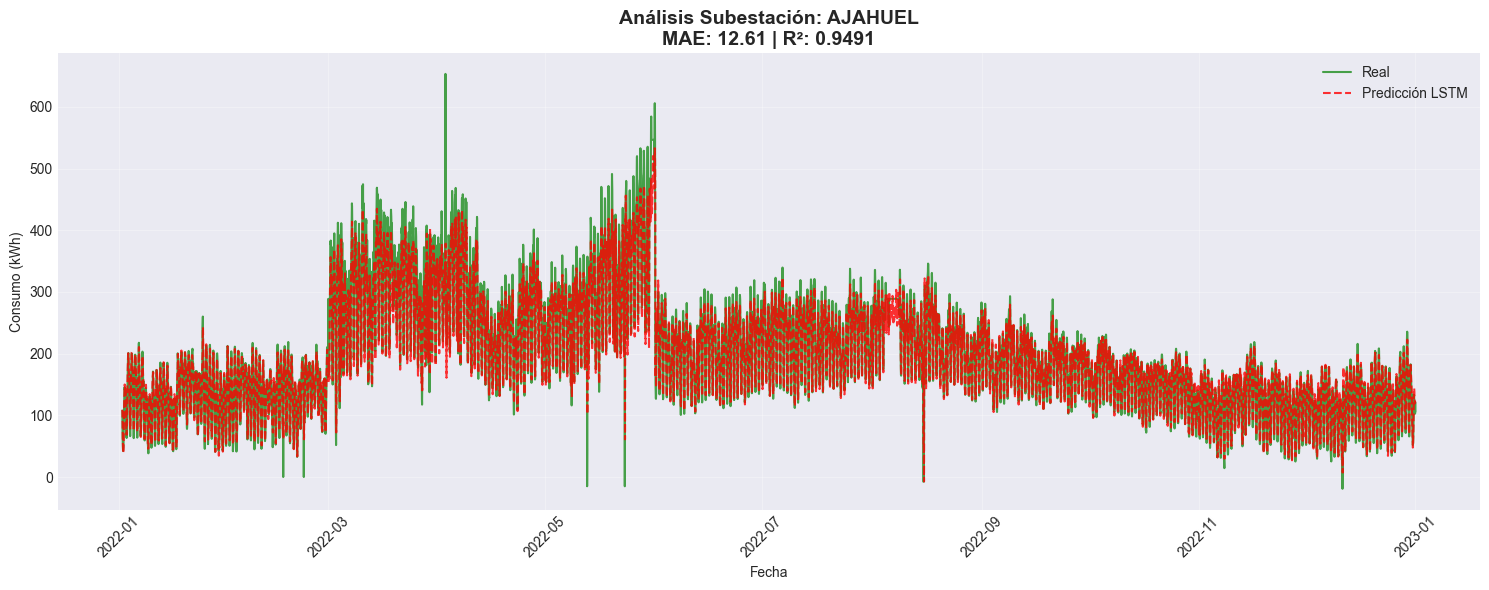

✓ Reporte generado para AJAHUEL
  Datos procesados: 8735 registros
------------------------------------------------------------


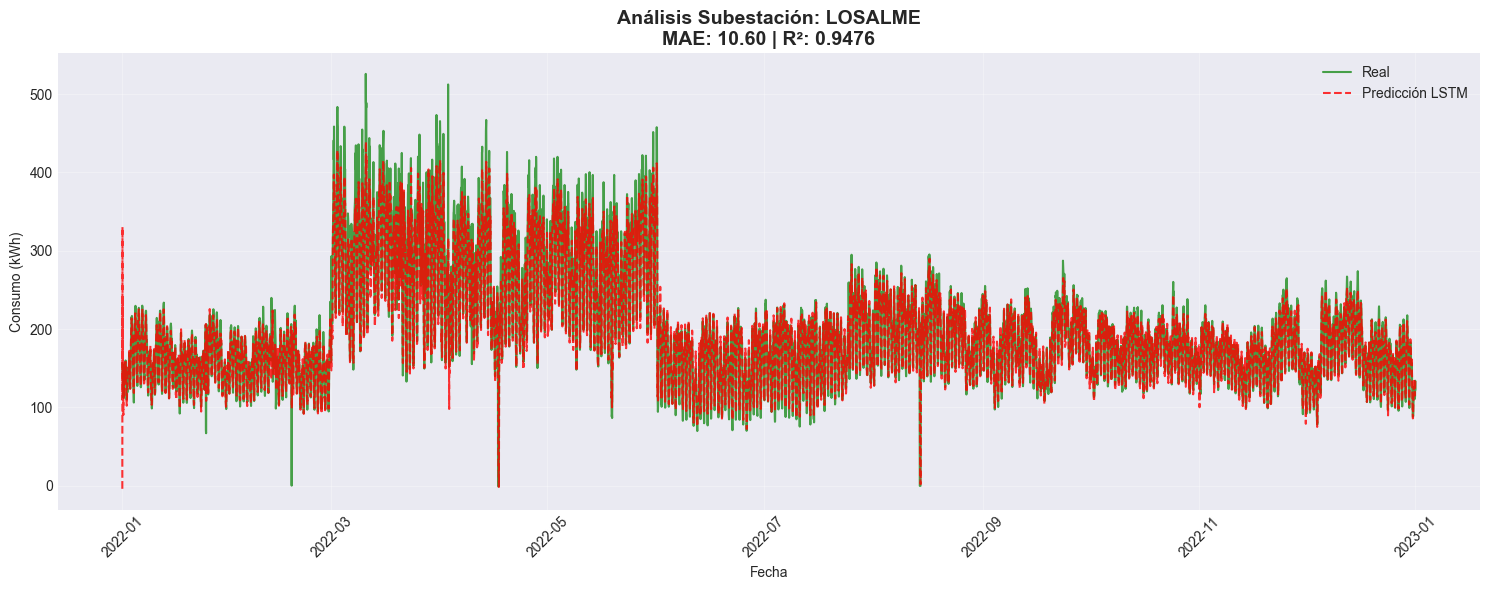

✓ Reporte generado para LOSALME
  Datos procesados: 8759 registros
------------------------------------------------------------


In [29]:
# %% [markdown]
# ## Parte 8c: Análisis Detallado por Subestación

# 1. Configuración: Define aquí las subestaciones que quieres inspeccionar
# Si no sabes los nombres, puedes verlos con: df_predicciones_lstm['subestacion'].unique()
subestaciones_interes = ['AJAHUEL', 'LOSALME'] 

# O si quieres seleccionar automáticamente las 3 con mayor error para revisarlas:
# subestaciones_interes = metricas_por_sub.tail(3).index.tolist() 

print(f'Analizando {len(subestaciones_interes)} subestaciones específicas...')

for nombre_sub in subestaciones_interes:
    # Filtramos el dataframe general creado en el paso anterior
    df_sub = df_predicciones_lstm[df_predicciones_lstm['subestacion'] == nombre_sub].copy()
    
    # Ordenamos por fecha para asegurar continuidad en el gráfico
    df_sub = df_sub.sort_values('fecha')
    
    if len(df_sub) == 0:
        print(f"⚠️ No se encontraron datos para la subestación: {nombre_sub}")
        continue

    # Calcular métricas locales
    mse_sub = mean_squared_error(df_sub['consumo_real'], df_sub['consumo_predicho_lstm'])
    mae_sub = mean_absolute_error(df_sub['consumo_real'], df_sub['consumo_predicho_lstm'])
    r2_sub = r2_score(df_sub['consumo_real'], df_sub['consumo_predicho_lstm'])
    
    # Visualización
    plt.figure(figsize=(15, 6))
    
    # Plot Real vs Predicho
    plt.plot(df_sub['fecha'], df_sub['consumo_real'], label='Real', 
             color='green', alpha=0.7, linewidth=1.5)
    plt.plot(df_sub['fecha'], df_sub['consumo_predicho_lstm'], label='Predicción LSTM', 
             color='red', linestyle='--', alpha=0.8, linewidth=1.5)
    
    # Formato del gráfico
    plt.title(f'Análisis Subestación: {nombre_sub}\nMAE: {mae_sub:.2f} | R²: {r2_sub:.4f}', 
              fontsize=14, fontweight='bold')
    plt.ylabel('Consumo (kWh)')
    plt.xlabel('Fecha')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Guardar gráfico individual
    nombre_archivo = f'analisis_sub_{nombre_sub.replace(" ", "_")}.png'
    plt.tight_layout()
    # plt.savefig(nombre_archivo) # Descomentar si quieres guardar la imagen
    plt.show()
    
    print(f"✓ Reporte generado para {nombre_sub}")
    print(f"  Datos procesados: {len(df_sub)} registros")
    print("-" * 60)

COMPARACIÓN SARIMA vs LSTM
✓ Modelo SARIMA disponible
✓ Modelo LSTM disponible

✓ Comparando 2 modelos

MÉTRICAS CONSOLIDADAS

Comparación de métricas:
Modelo        MAE       RMSE        R²  MAPE (%)  Muestras
SARIMA 578.457735 832.784229 -0.289463 48.685287      8759
  LSTM  19.571008  36.327606  0.975728       inf     61289

🏆 Mejor modelo por métrica:
  MAE (menor es mejor): LSTM
  RMSE (menor es mejor): LSTM
  R² (mayor es mejor): LSTM
  MAPE (menor es mejor): SARIMA

🥇 Ganador general: LSTM (3/4 métricas)

VISUALIZACIÓN COMPARATIVA
✓ Gráfico guardado: 28_comparacion_sarima_vs_lstm.png


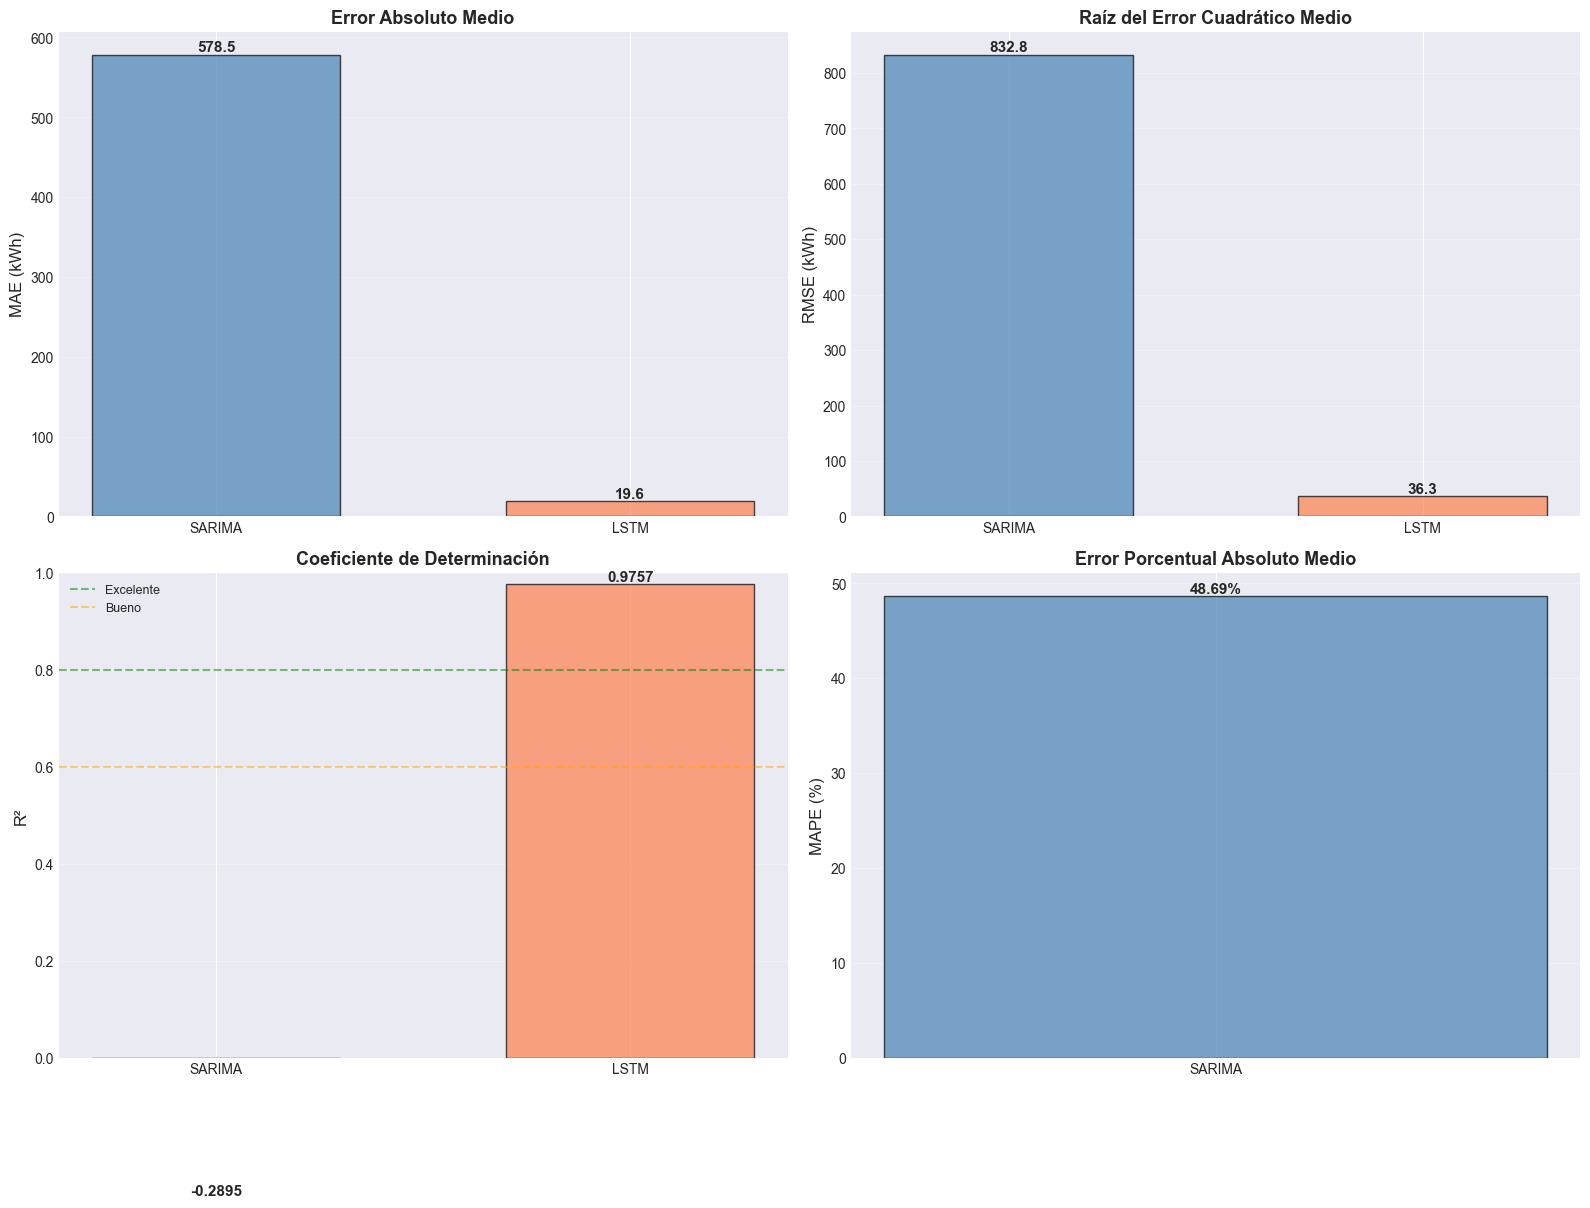


COMPARACIÓN VISUAL DE PREDICCIONES
✓ Gráfico guardado: 29_comparacion_predicciones_zoom.png


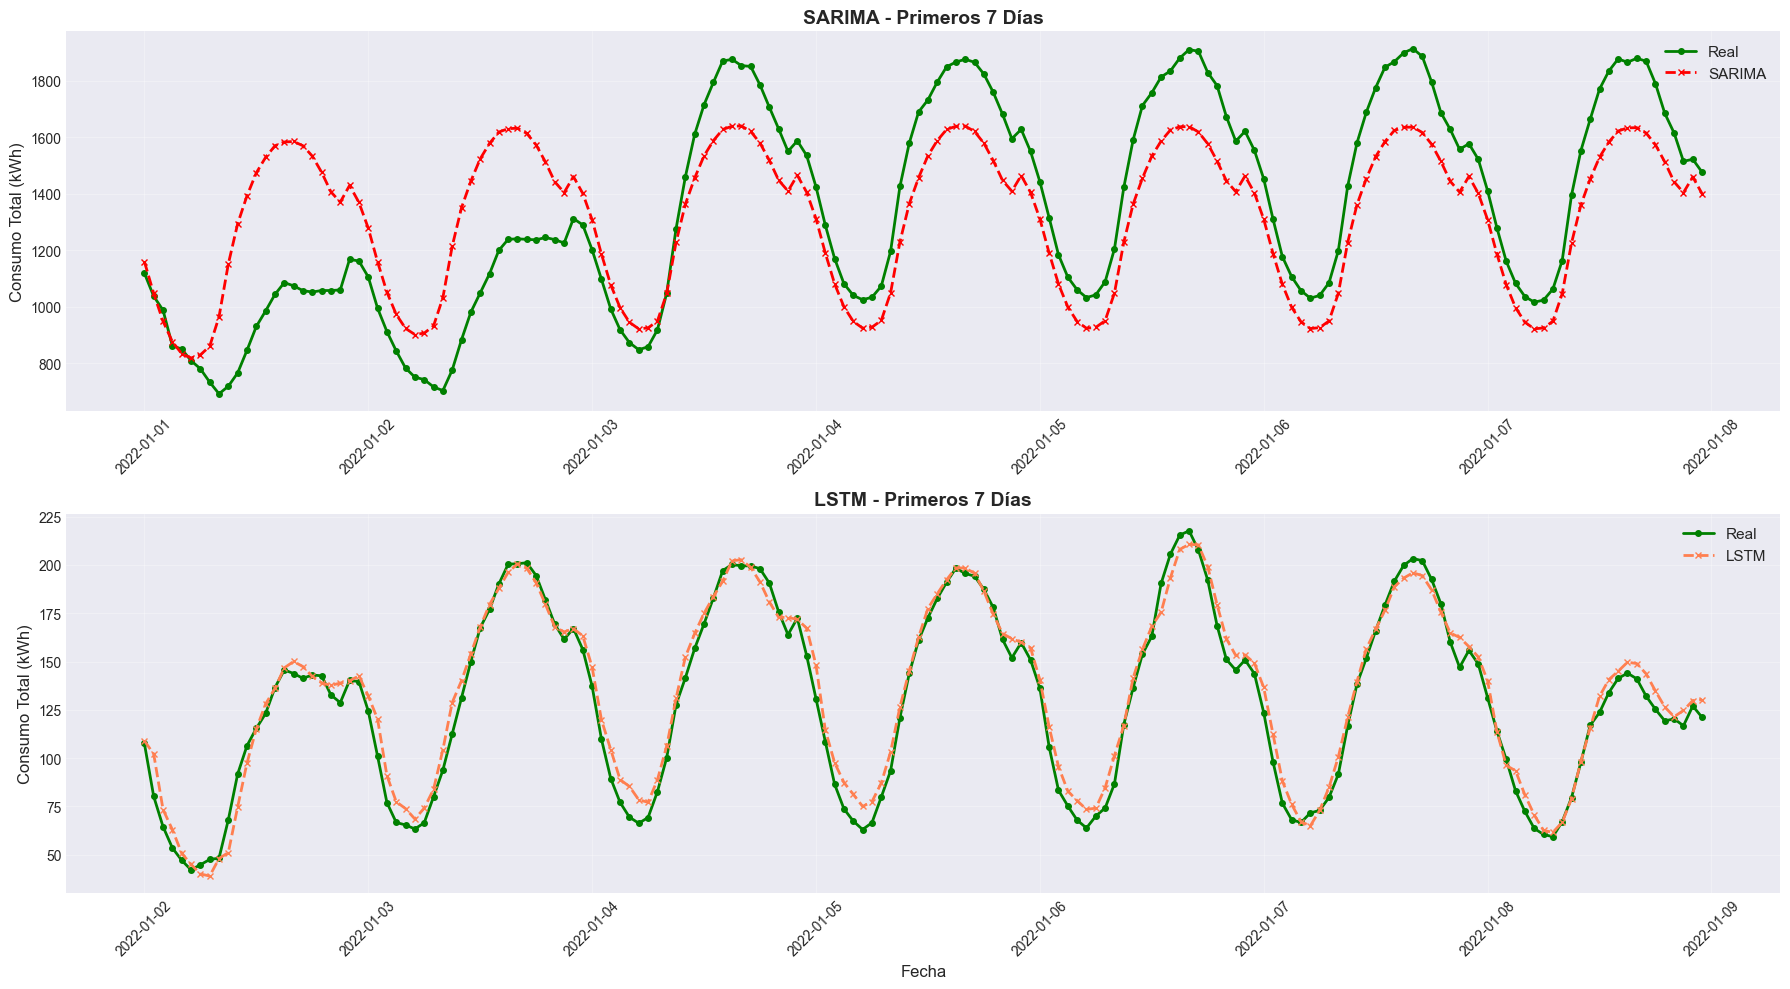


ANÁLISIS COMPARATIVO

📊 SARIMA:
  Fortalezas:
    ✓ Interpretable estadísticamente
    ✓ Captura estacionalidad automáticamente
    ✓ No requiere gran cantidad de datos
    ✓ Rápido de entrenar
    ✓ Funciona bien con patrones estacionales claros

  Debilidades:
    △ Solo usa información temporal (univariado)
    △ Asume relaciones lineales
    △ Puede degradarse en predicciones muy largas
    △ Sensible a valores atípicos

📊 LSTM:
  Fortalezas:
    ✓ Captura patrones no lineales complejos
    ✓ Usa múltiples features (multivariado)
    ✓ Aprende dependencias de largo plazo
    ✓ Adaptable a cambios en patrones

  Debilidades:
    △ Requiere muchos datos para entrenar
    △ Tiempo de entrenamiento mayor
    △ Menos interpretable ("caja negra")
    △ Requiere normalización y preprocesamiento cuidadoso
    △ Puede hacer overfitting con pocos datos

💡 RECOMENDACIÓN:
  → LSTM es mejor (96.6% menos error)
  → Los datos tienen patrones complejos que LSTM captura mejor
  → Vale la pena la m

In [30]:
# %% [markdown]
# ## Parte 9: Comparación Final SARIMA vs LSTM

# %%
print('='*60)
print('COMPARACIÓN SARIMA vs LSTM')
print('='*60)

# Verificar que ambos modelos existen
modelos_disponibles = []

if 'mae_sarima' in locals() and 'predicciones_sarima_clean' in locals():
    modelos_disponibles.append('SARIMA')
    print('✓ Modelo SARIMA disponible')
else:
    print('⚠ Modelo SARIMA no encontrado')

if 'mae_test' in locals() and 'y_test_pred' in locals():
    modelos_disponibles.append('LSTM')
    print('✓ Modelo LSTM disponible')
else:
    print('⚠ Modelo LSTM no encontrado')

if len(modelos_disponibles) < 2:
    print('\n✗ Se necesitan ambos modelos entrenados para comparar')
    print('  Ejecuta primero las secciones de SARIMA y LSTM')
else:
    print(f'\n✓ Comparando {len(modelos_disponibles)} modelos')

# %%
# Consolidar métricas de ambos modelos
print('\n' + '='*60)
print('MÉTRICAS CONSOLIDADAS')
print('='*60)

if len(modelos_disponibles) == 2:
    # DataFrame comparativo
    comparacion = pd.DataFrame({
        'Modelo': ['SARIMA', 'LSTM'],
        'MAE': [mae_sarima, mae_test],
        'RMSE': [rmse_sarima, rmse_test],
        'R²': [r2_sarima, r2_test],
        'MAPE (%)': [mape, mape_test],
        'Muestras': [len(ts_test_sarima_clean), len(y_test_real)]
    })
    
    print('\nComparación de métricas:')
    print(comparacion.to_string(index=False))
    
    # Determinar ganador por métrica
    print('\n🏆 Mejor modelo por métrica:')
    mejor_mae = comparacion.loc[comparacion['MAE'].idxmin(), 'Modelo']
    mejor_rmse = comparacion.loc[comparacion['RMSE'].idxmin(), 'Modelo']
    mejor_r2 = comparacion.loc[comparacion['R²'].idxmax(), 'Modelo']
    mejor_mape = comparacion.loc[comparacion['MAPE (%)'].idxmin(), 'Modelo']
    
    print(f'  MAE (menor es mejor): {mejor_mae}')
    print(f'  RMSE (menor es mejor): {mejor_rmse}')
    print(f'  R² (mayor es mejor): {mejor_r2}')
    print(f'  MAPE (menor es mejor): {mejor_mape}')
    
    # Score general
    scores = {'SARIMA': 0, 'LSTM': 0}
    scores[mejor_mae] += 1
    scores[mejor_rmse] += 1
    scores[mejor_r2] += 1
    scores[mejor_mape] += 1
    
    ganador_general = max(scores, key=scores.get)
    print(f'\n🥇 Ganador general: {ganador_general} ({scores[ganador_general]}/4 métricas)')

# %%
# Gráfico comparativo de métricas
print('\n' + '='*60)
print('VISUALIZACIÓN COMPARATIVA')
print('='*60)

if len(modelos_disponibles) == 2:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Colores por modelo
    colors = {'SARIMA': 'steelblue', 'LSTM': 'coral'}
    
    # 1. MAE
    axes[0, 0].bar(comparacion['Modelo'], comparacion['MAE'], 
                   color=[colors[m] for m in comparacion['Modelo']], 
                   alpha=0.7, edgecolor='black', width=0.6)
    axes[0, 0].set_ylabel('MAE (kWh)', fontsize=12)
    axes[0, 0].set_title('Error Absoluto Medio', fontsize=13, fontweight='bold')
    axes[0, 0].grid(axis='y', alpha=0.3)
    # Añadir valores
    for i, (modelo, mae) in enumerate(zip(comparacion['Modelo'], comparacion['MAE'])):
        axes[0, 0].text(i, mae, f'{mae:,.1f}', ha='center', va='bottom', 
                       fontsize=11, fontweight='bold')
    
    # 2. RMSE
    axes[0, 1].bar(comparacion['Modelo'], comparacion['RMSE'], 
                   color=[colors[m] for m in comparacion['Modelo']], 
                   alpha=0.7, edgecolor='black', width=0.6)
    axes[0, 1].set_ylabel('RMSE (kWh)', fontsize=12)
    axes[0, 1].set_title('Raíz del Error Cuadrático Medio', fontsize=13, fontweight='bold')
    axes[0, 1].grid(axis='y', alpha=0.3)
    for i, (modelo, rmse) in enumerate(zip(comparacion['Modelo'], comparacion['RMSE'])):
        axes[0, 1].text(i, rmse, f'{rmse:,.1f}', ha='center', va='bottom', 
                       fontsize=11, fontweight='bold')
    
    # 3. R²
    axes[1, 0].bar(comparacion['Modelo'], comparacion['R²'], 
                   color=[colors[m] for m in comparacion['Modelo']], 
                   alpha=0.7, edgecolor='black', width=0.6)
    axes[1, 0].set_ylabel('R²', fontsize=12)
    axes[1, 0].set_title('Coeficiente de Determinación', fontsize=13, fontweight='bold')
    axes[1, 0].axhline(y=0.8, color='green', linestyle='--', alpha=0.5, label='Excelente')
    axes[1, 0].axhline(y=0.6, color='orange', linestyle='--', alpha=0.5, label='Bueno')
    axes[1, 0].legend(fontsize=9)
    axes[1, 0].grid(axis='y', alpha=0.3)
    axes[1, 0].set_ylim(0, 1)
    for i, (modelo, r2) in enumerate(zip(comparacion['Modelo'], comparacion['R²'])):
        axes[1, 0].text(i, r2, f'{r2:.4f}', ha='center', va='bottom', 
                       fontsize=11, fontweight='bold')
    
    # 4. MAPE
    axes[1, 1].bar(comparacion['Modelo'], comparacion['MAPE (%)'], 
                   color=[colors[m] for m in comparacion['Modelo']], 
                   alpha=0.7, edgecolor='black', width=0.6)
    axes[1, 1].set_ylabel('MAPE (%)', fontsize=12)
    axes[1, 1].set_title('Error Porcentual Absoluto Medio', fontsize=13, fontweight='bold')
    axes[1, 1].grid(axis='y', alpha=0.3)
    for i, (modelo, mape) in enumerate(zip(comparacion['Modelo'], comparacion['MAPE (%)'])):
        axes[1, 1].text(i, mape, f'{mape:.2f}%', ha='center', va='bottom', 
                       fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('28_comparacion_sarima_vs_lstm.png', dpi=200, bbox_inches='tight')
    print('✓ Gráfico guardado: 28_comparacion_sarima_vs_lstm.png')
    plt.show()

# %%
# Comparación visual de predicciones (primeros días)
print('\n' + '='*60)
print('COMPARACIÓN VISUAL DE PREDICCIONES')
print('='*60)

if len(modelos_disponibles) == 2:
    # Tomar primeros 7 días para comparar
    dias_comparar = 7
    
    # SARIMA (serie agregada)
    fecha_limite_sarima = ts_test_sarima_clean.index.min() + pd.Timedelta(days=dias_comparar)
    mask_sarima = ts_test_sarima_clean.index < fecha_limite_sarima
    
    ts_real_sarima_zoom = ts_test_sarima_clean[mask_sarima]
    ts_pred_sarima_zoom = predicciones_sarima_clean[mask_sarima]
    
    # LSTM (convertir a serie temporal agregada para comparar)
    # Reconstruir fechas del test LSTM
    if 'test_lstm_con_seq' in locals():
        df_lstm_zoom = test_lstm_con_seq.iloc[:min(dias_comparar*24, len(y_test_real))]
        fechas_lstm = df_lstm_zoom['fecha'].values
        
        # Agregar por fecha
        df_temp_lstm = pd.DataFrame({
            'fecha': fechas_lstm,
            'real': y_test_real.flatten()[:len(fechas_lstm)],
            'pred': y_test_pred.flatten()[:len(fechas_lstm)]
        })
        
        ts_real_lstm_agg = df_temp_lstm.groupby('fecha')['real'].sum()
        ts_pred_lstm_agg = df_temp_lstm.groupby('fecha')['pred'].sum()
        
        # Gráfico comparativo
        fig, axes = plt.subplots(2, 1, figsize=(18, 10))
        
        # SARIMA
        axes[0].plot(ts_real_sarima_zoom.index, ts_real_sarima_zoom.values,
                    label='Real', linewidth=2, color='green', marker='o', markersize=4)
        axes[0].plot(ts_pred_sarima_zoom.index, ts_pred_sarima_zoom.values,
                    label='SARIMA', linewidth=2, color='red', marker='x', markersize=4, linestyle='--')
        axes[0].set_ylabel('Consumo Total (kWh)', fontsize=12)
        axes[0].set_title(f'SARIMA - Primeros {dias_comparar} Días', fontsize=14, fontweight='bold')
        axes[0].legend(fontsize=11)
        axes[0].grid(True, alpha=0.3)
        axes[0].tick_params(axis='x', rotation=45)
        
        # LSTM
        axes[1].plot(ts_real_lstm_agg.index, ts_real_lstm_agg.values,
                    label='Real', linewidth=2, color='green', marker='o', markersize=4)
        axes[1].plot(ts_pred_lstm_agg.index, ts_pred_lstm_agg.values,
                    label='LSTM', linewidth=2, color='coral', marker='x', markersize=4, linestyle='--')
        axes[1].set_xlabel('Fecha', fontsize=12)
        axes[1].set_ylabel('Consumo Total (kWh)', fontsize=12)
        axes[1].set_title(f'LSTM - Primeros {dias_comparar} Días', fontsize=14, fontweight='bold')
        axes[1].legend(fontsize=11)
        axes[1].grid(True, alpha=0.3)
        axes[1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.savefig('29_comparacion_predicciones_zoom.png', dpi=200, bbox_inches='tight')
        print('✓ Gráfico guardado: 29_comparacion_predicciones_zoom.png')
        plt.show()

# %%
# Análisis de fortalezas y debilidades
print('\n' + '='*60)
print('ANÁLISIS COMPARATIVO')
print('='*60)

if len(modelos_disponibles) == 2:
    print('\n📊 SARIMA:')
    print('  Fortalezas:')
    print('    ✓ Interpretable estadísticamente')
    print('    ✓ Captura estacionalidad automáticamente')
    print('    ✓ No requiere gran cantidad de datos')
    print('    ✓ Rápido de entrenar')
    print('    ✓ Funciona bien con patrones estacionales claros')
    
    print('\n  Debilidades:')
    print('    △ Solo usa información temporal (univariado)')
    print('    △ Asume relaciones lineales')
    print('    △ Puede degradarse en predicciones muy largas')
    print('    △ Sensible a valores atípicos')
    
    print('\n📊 LSTM:')
    print('  Fortalezas:')
    print('    ✓ Captura patrones no lineales complejos')
    print('    ✓ Usa múltiples features (multivariado)')
    print('    ✓ Aprende dependencias de largo plazo')
    print('    ✓ Adaptable a cambios en patrones')
    
    print('\n  Debilidades:')
    print('    △ Requiere muchos datos para entrenar')
    print('    △ Tiempo de entrenamiento mayor')
    print('    △ Menos interpretable ("caja negra")')
    print('    △ Requiere normalización y preprocesamiento cuidadoso')
    print('    △ Puede hacer overfitting con pocos datos')
    
    # Recomendación
    print('\n💡 RECOMENDACIÓN:')
    
    diferencia_mae = abs(mae_sarima - mae_test) / min(mae_sarima, mae_test) * 100
    
    if diferencia_mae < 5:
        print(f'  → Ambos modelos tienen desempeño similar (diferencia: {diferencia_mae:.1f}%)')
        print('  → Usar SARIMA por ser más simple e interpretable')
    elif mae_sarima < mae_test:
        mejora = ((mae_test - mae_sarima) / mae_test) * 100
        print(f'  → SARIMA es mejor ({mejora:.1f}% menos error)')
        print('  → Los datos tienen patrones estacionales claros que SARIMA captura bien')
    else:
        mejora = ((mae_sarima - mae_test) / mae_sarima) * 100
        print(f'  → LSTM es mejor ({mejora:.1f}% menos error)')
        print('  → Los datos tienen patrones complejos que LSTM captura mejor')
        print('  → Vale la pena la mayor complejidad')

# %%
# Tabla resumen exportable
print('\n' + '='*60)
print('TABLA RESUMEN EXPORTABLE')
print('='*60)

if len(modelos_disponibles) == 2:
    # Crear tabla detallada
    resumen_detallado = pd.DataFrame({
        'Métrica': ['MAE (kWh)', 'RMSE (kWh)', 'R²', 'MAPE (%)', 'Muestras'],
        'SARIMA': [
            f'{mae_sarima:,.2f}',
            f'{rmse_sarima:,.2f}',
            f'{r2_sarima:.4f}',
            f'{mape:.2f}',
            f'{len(ts_test_sarima_clean):,}'
        ],
        'LSTM': [
            f'{mae_test:,.2f}',
            f'{rmse_test:,.2f}',
            f'{r2_test:.4f}',
            f'{mape_test:.2f}',
            f'{len(y_test_real):,}'
        ],
        'Ganador': [
            mejor_mae,
            mejor_rmse,
            mejor_r2,
            mejor_mape,
            '-'
        ]
    })
    
    print('\n')
    print(resumen_detallado.to_string(index=False))
    
    # Guardar a CSV
    output_path = 'comparacion_sarima_vs_lstm.csv'
    resumen_detallado.to_csv(output_path, index=False)
    print(f'\n✓ Tabla guardada: {output_path}')

# %%
# Resumen final
print('\n' + '='*60)
print('📋 RESUMEN DE COMPARACIÓN')
print('='*60)

if len(modelos_disponibles) == 2:
    print(f'\n🏆 Modelo ganador: {ganador_general}')
    print(f'   Score: {scores[ganador_general]}/4 métricas')
    
    print(f'\n📊 Diferencias clave:')
    dif_mae = ((abs(mae_sarima - mae_test) / min(mae_sarima, mae_test)) * 100)
    dif_r2 = abs(r2_sarima - r2_test)
    
    print(f'   MAE: diferencia de {dif_mae:.1f}%')
    print(f'   R²: diferencia de {dif_r2:.4f}')
    
    print(f'\n📁 Archivos generados:')
    archivos_comp = [
        '28_comparacion_sarima_vs_lstm.png',
        '29_comparacion_predicciones_zoom.png',
        'comparacion_sarima_vs_lstm.csv'
    ]
    
    for archivo in archivos_comp:
        if os.path.exists(archivo):
            print(f'   ✓ {archivo}')